# Import Packages and Define Helper Functions

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from itertools import combinations

In [2]:
# Takes in a list of dataframes, a feature column, and a list of targets
# Creates a matplotlib figure with 2 seaborn plots per frame (each frame's plots are on a row)
# Plot 1: histogram of feature, hued by target
# Plot 2: boxplot of feature, grouped by target
def plot_distributions(frames, column, targets, kde = True, bins = 'auto'):
    num_frames = len(frames)
    
    # Create figure, ax objects based on number of passed in frames
    fig, ax = plt.subplots(num_frames, 2, figsize = (12, 6 * num_frames))
    
    plt.tight_layout(pad = 3.0)
    
    # Loop through frames to plot each row
    for index, frame in enumerate(frames):
        # Select global variable name for each frame for use in title labels
        frame_name = [i for i, j in globals().items() if frame.equals(j)][0]
        
        # If number of frames = 1, axis object is not subscriptable
        if num_frames != 1:
            axrow = ax[index]
        else:
            axrow = ax
        
        # Create seaborn histplot of feature, hued by target
        sns.histplot(data = frame,
                     x = frame[column],
                     hue = frame[targets[index]],
                     palette = 'tab10',
                     multiple = 'layer',
                     alpha = 0.5,
                     kde = kde,
                     bins = bins,
                     ax = axrow[0]);
        axrow[0].set_title('{} : {} Histogram'.format(frame_name, column));
        axrow[0].set_xlabel(column);

        # Create seaborn boxplot of feature, grouped by target
        sns.boxplot(data = frame,
                    x = frame[column],
                    y = frame[targets[index]],
                    orient = 'h',
                    ax = axrow[1]);
        axrow[1].set_title('{} : {} Boxplot'.format(frame_name, column));
        axrow[1].set_xlabel(column);

    return

# Load Dataframes

In [3]:
# Set up dataframes
multi_class = pd.read_csv('multi_class_data.csv')
binary_class = pd.read_csv('binary_class_data.csv')

# Inspect Correlations

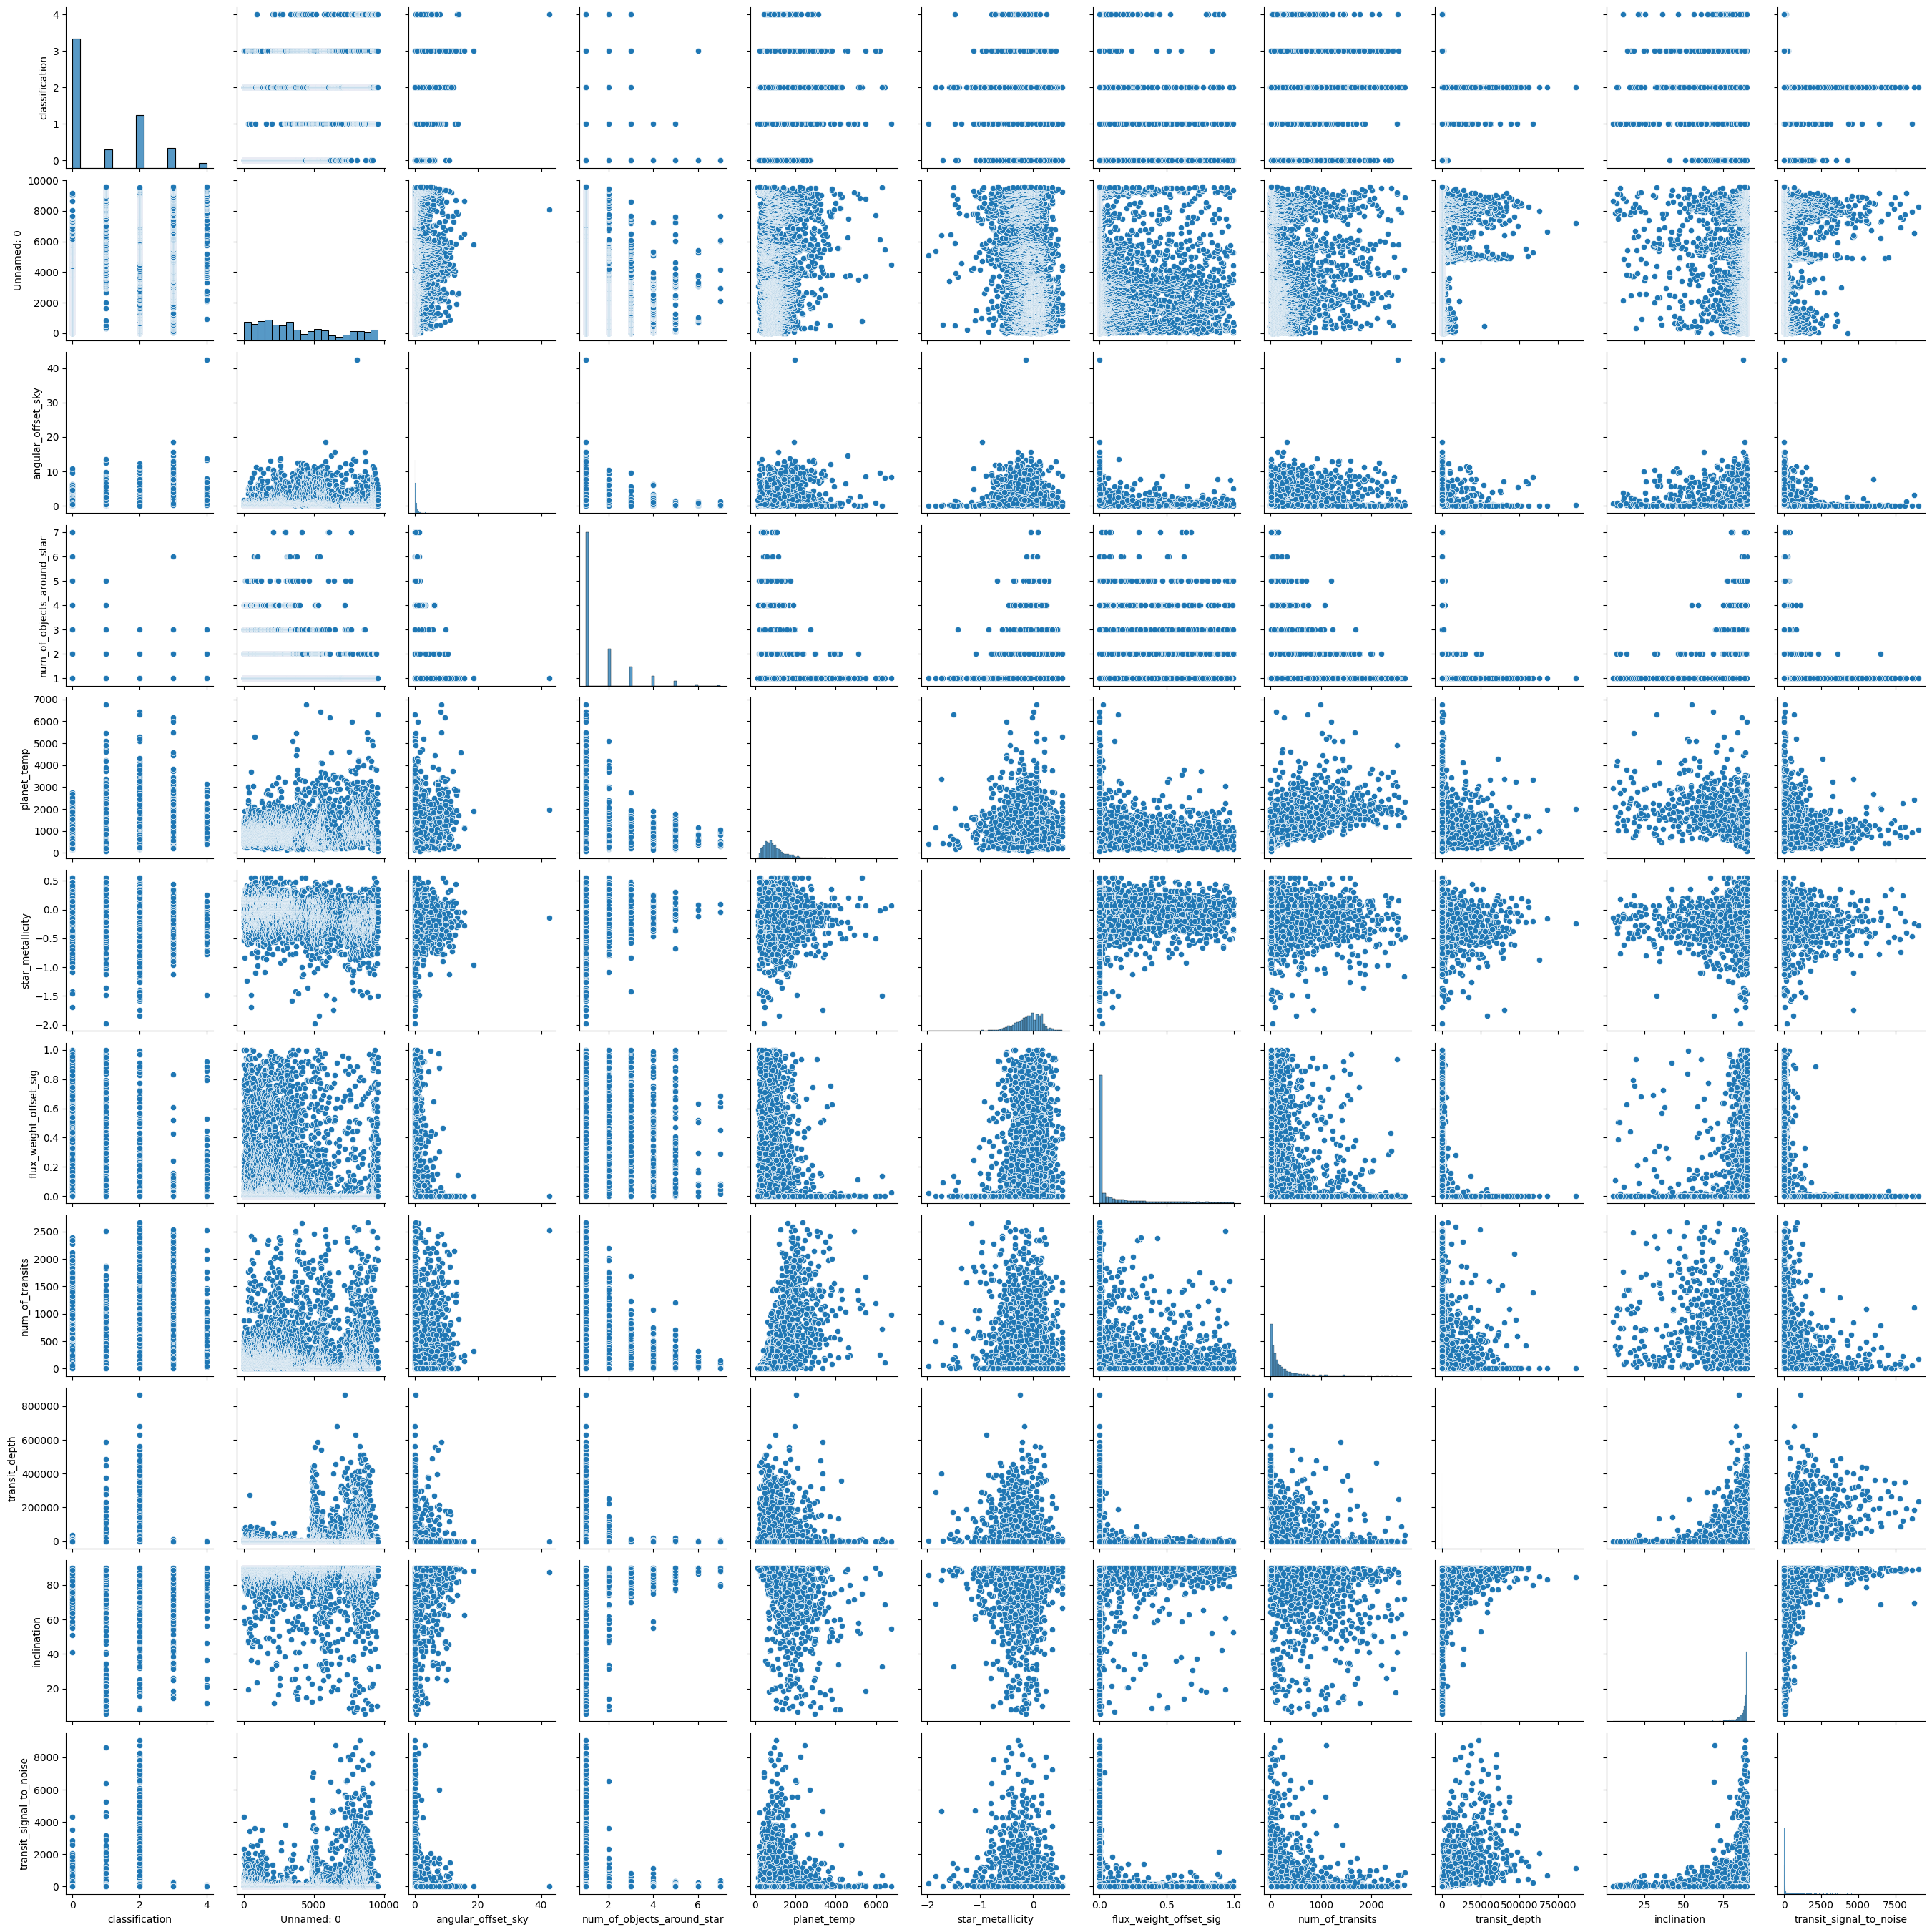

In [4]:
# Inspect pairplot of features with highest correlation with target variable for multi-class dataset
highest_corr_multi = multi_class.corr(numeric_only = True).abs().classification.nlargest(11).index.values.tolist()
sns.pairplot(multi_class[highest_corr_multi]);

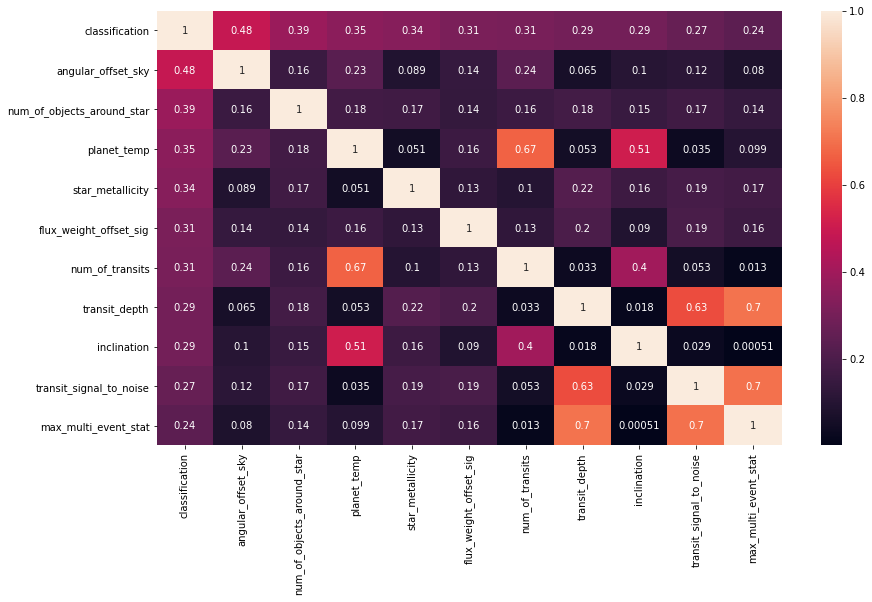

In [5]:
# Inspect heatmap of features with highest correlation with target variable for multi-class dataset
fig, ax = plt.subplots(figsize = (14, 8))
sns.heatmap(multi_class[highest_corr_multi].corr().abs(), annot = True, ax = ax);

# Inspect Distributions of Features

In [5]:
# Select numerical columns to inspect distributions
numerical_columns = multi_class.drop('classification', axis = 1).columns

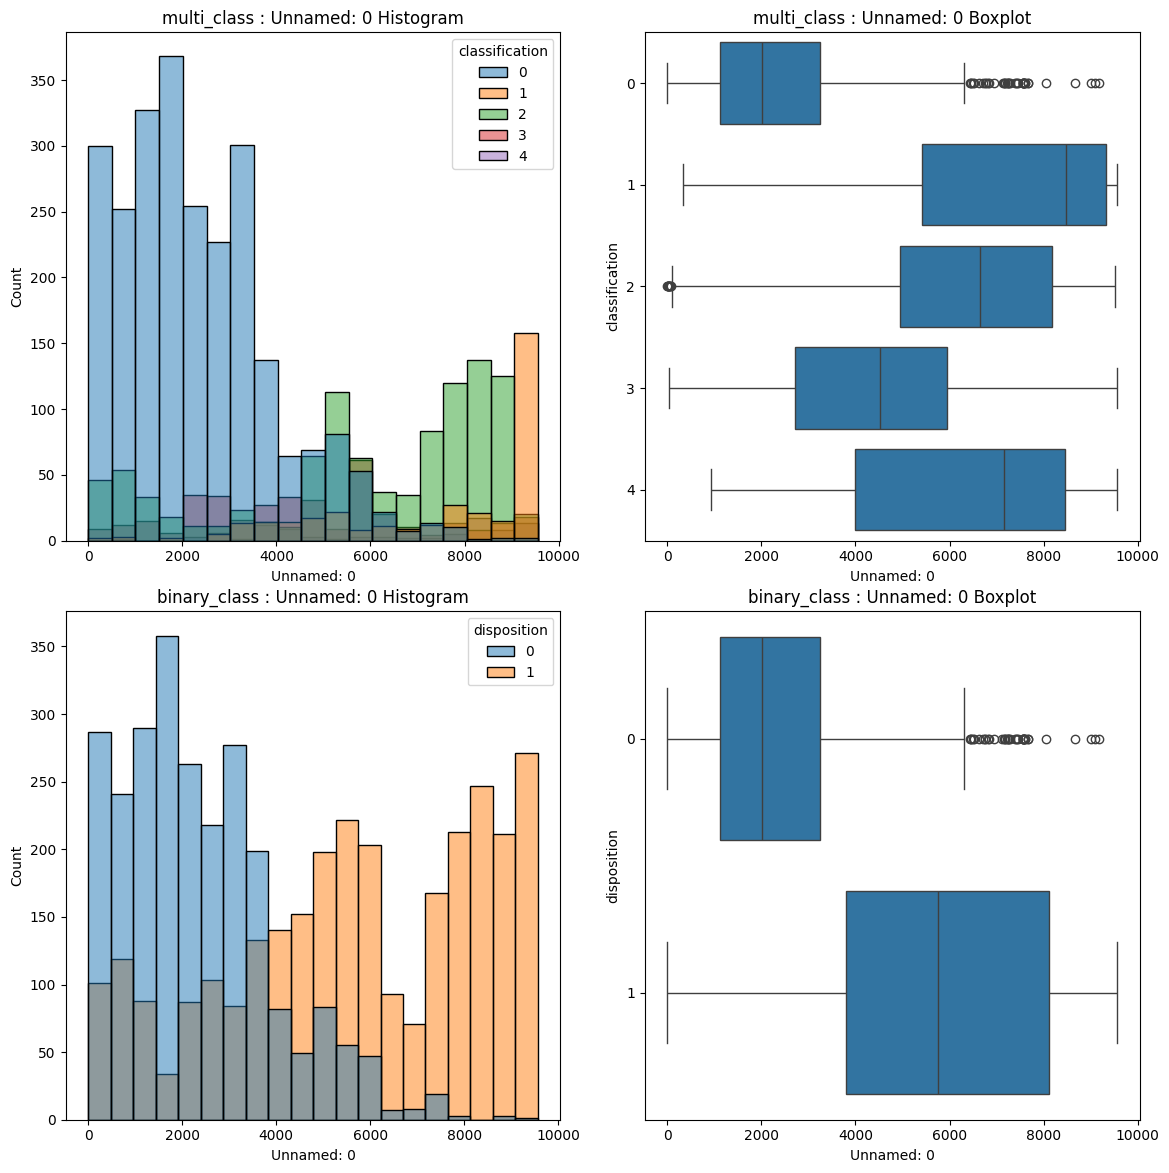

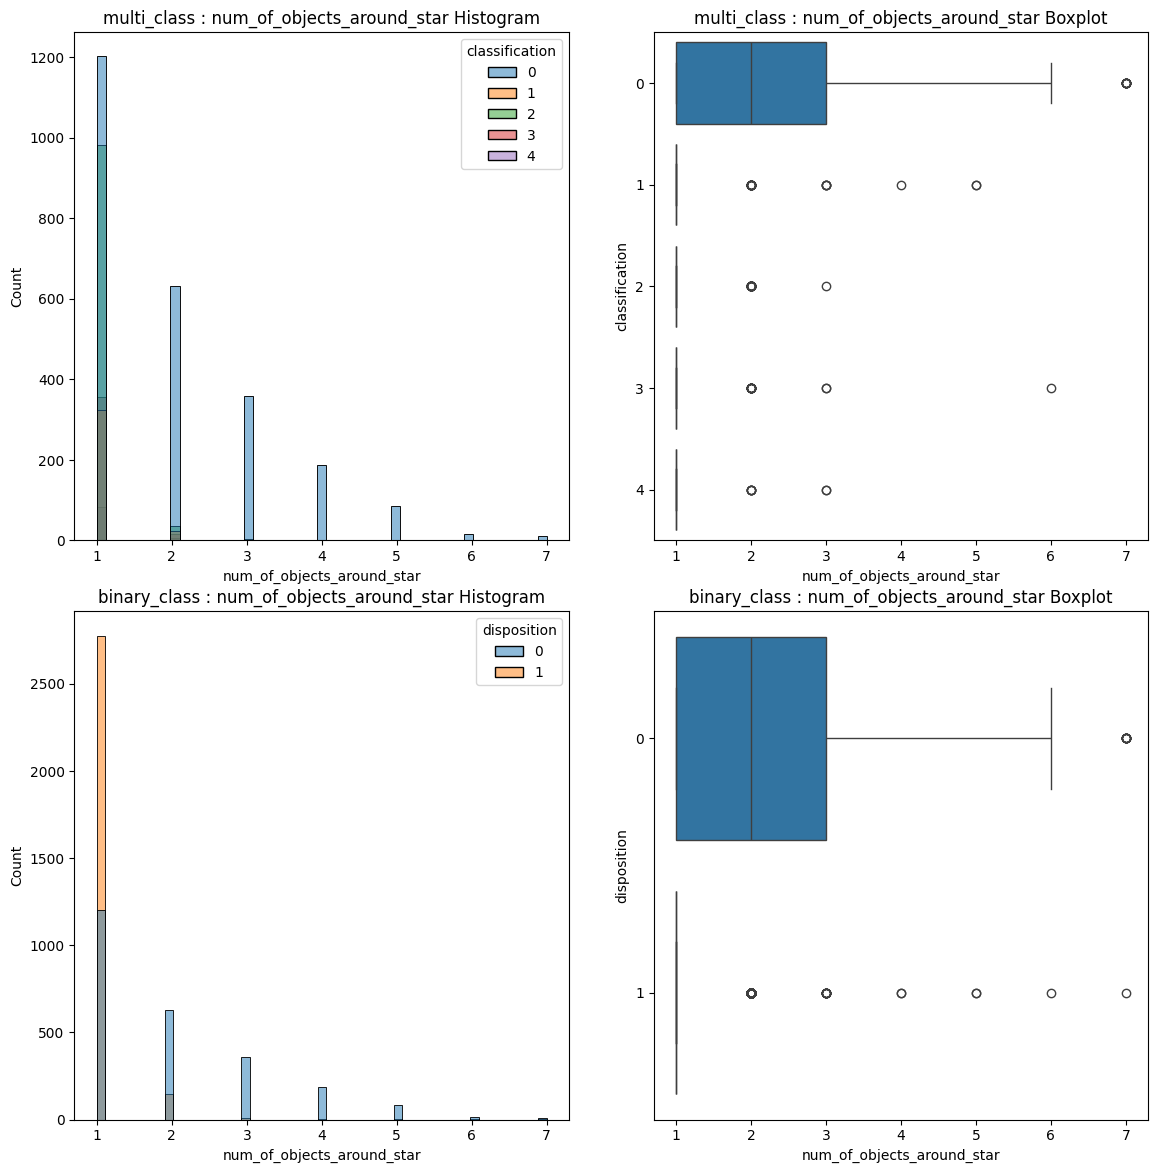

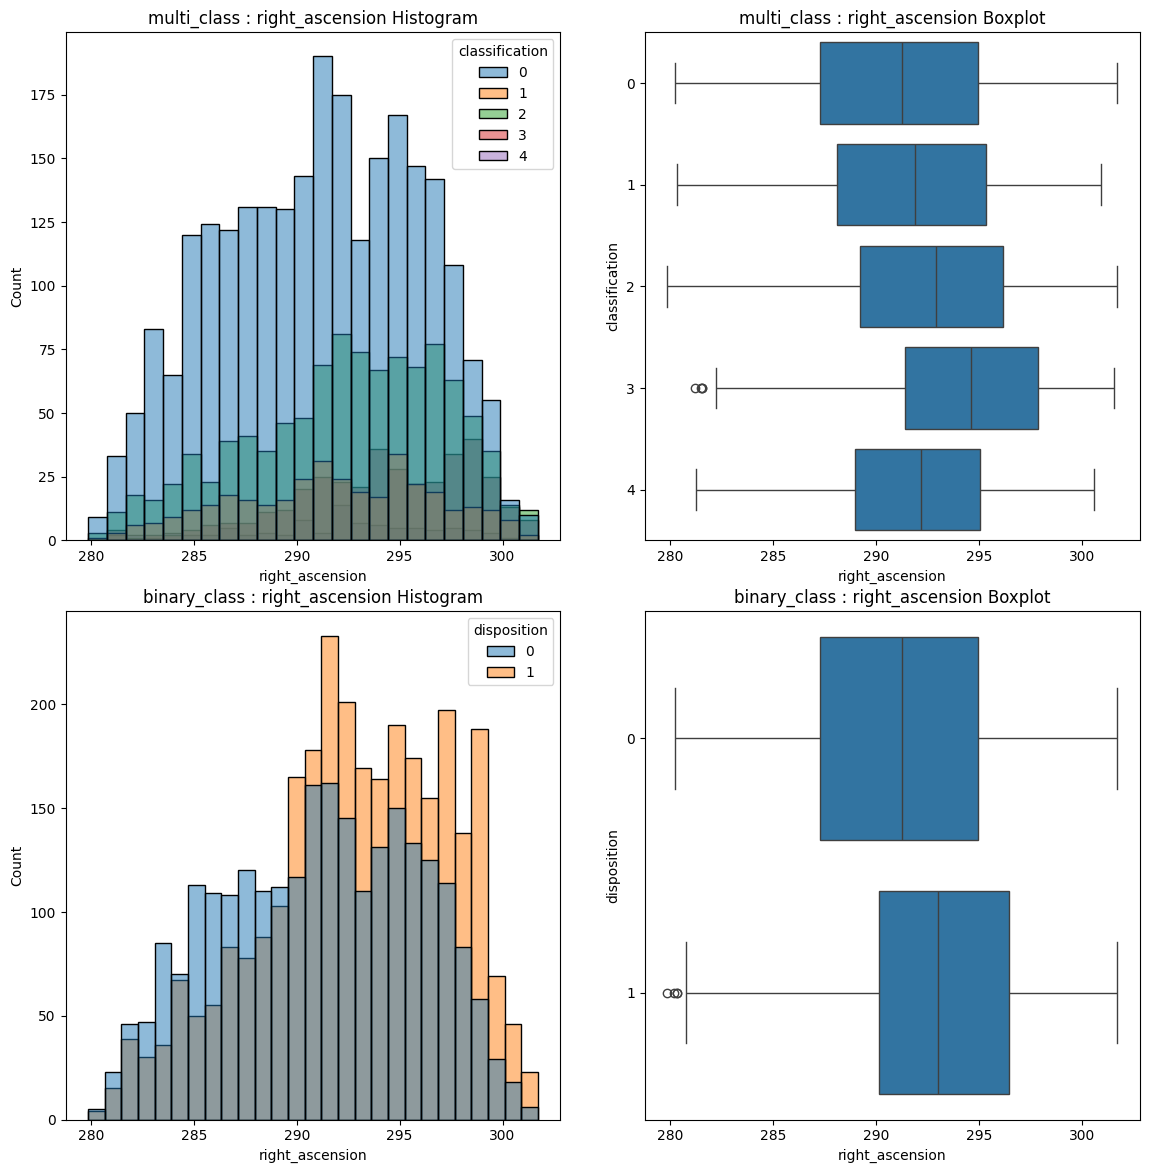

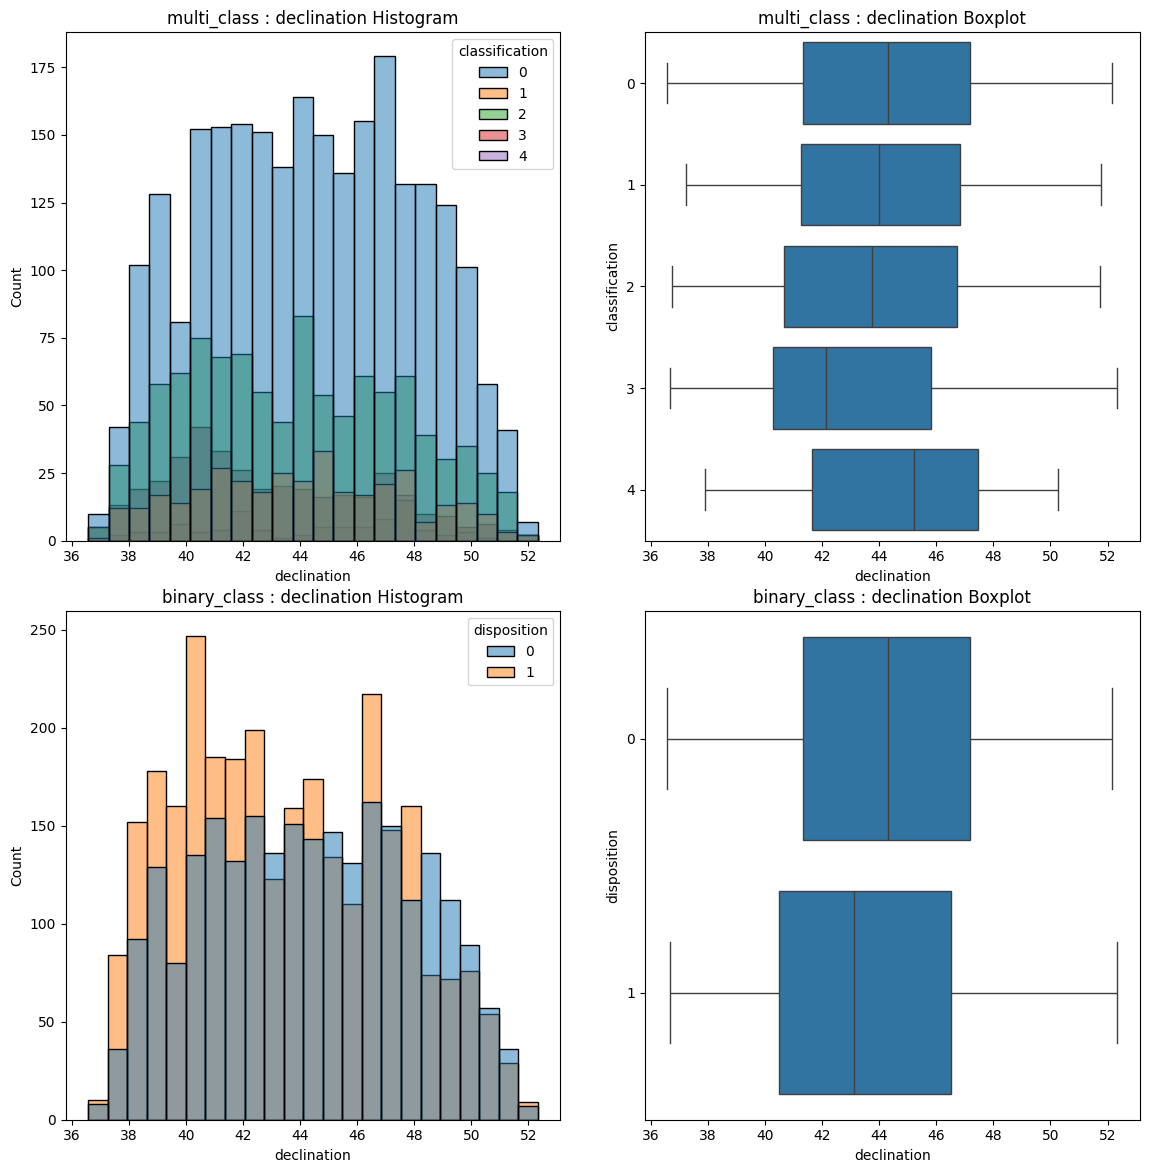

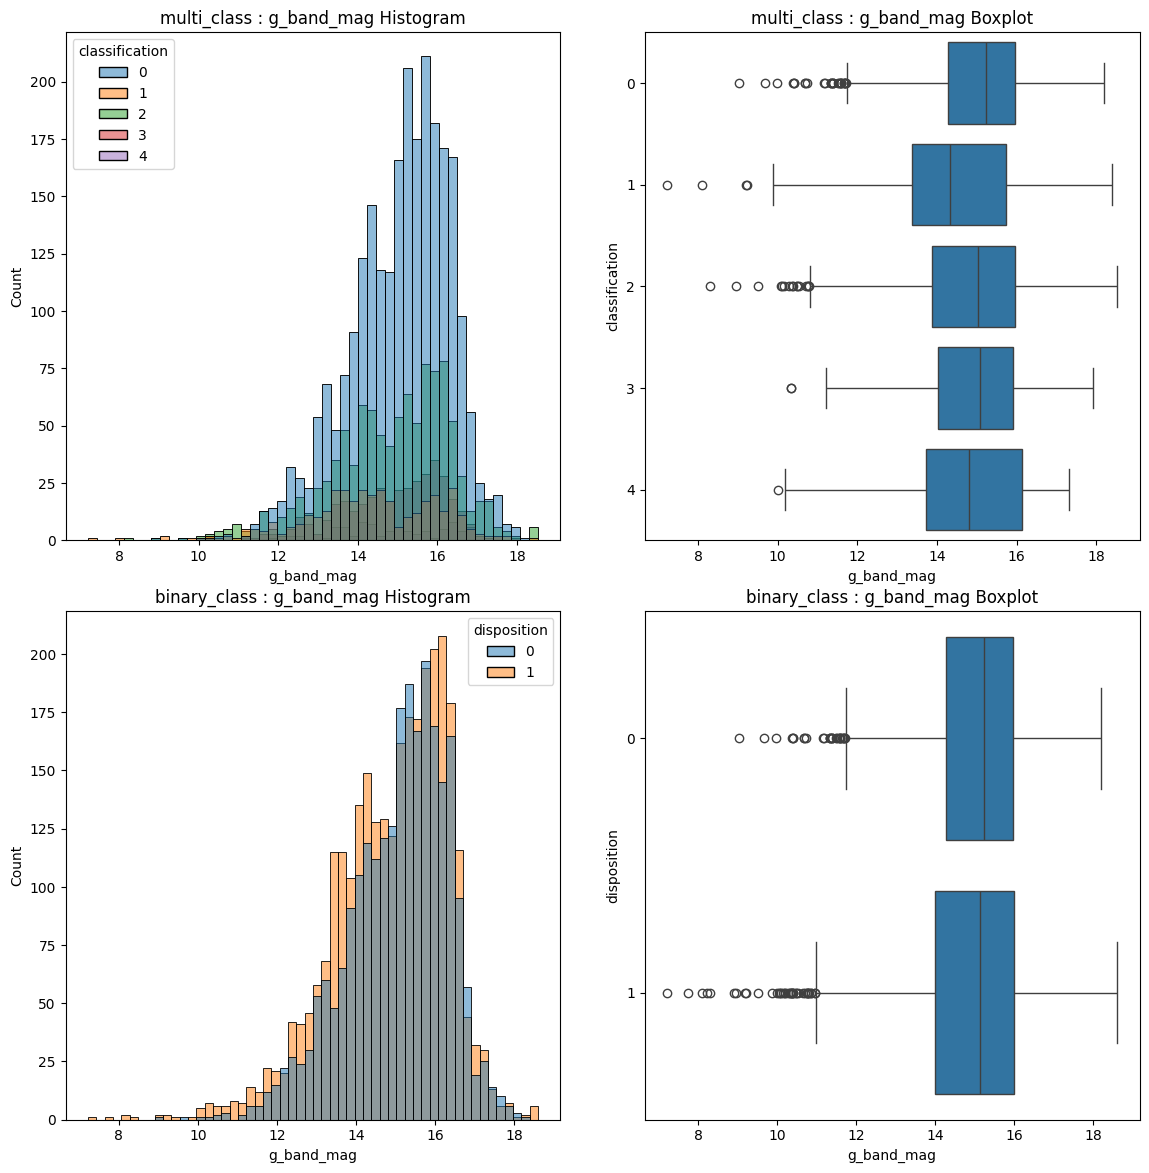

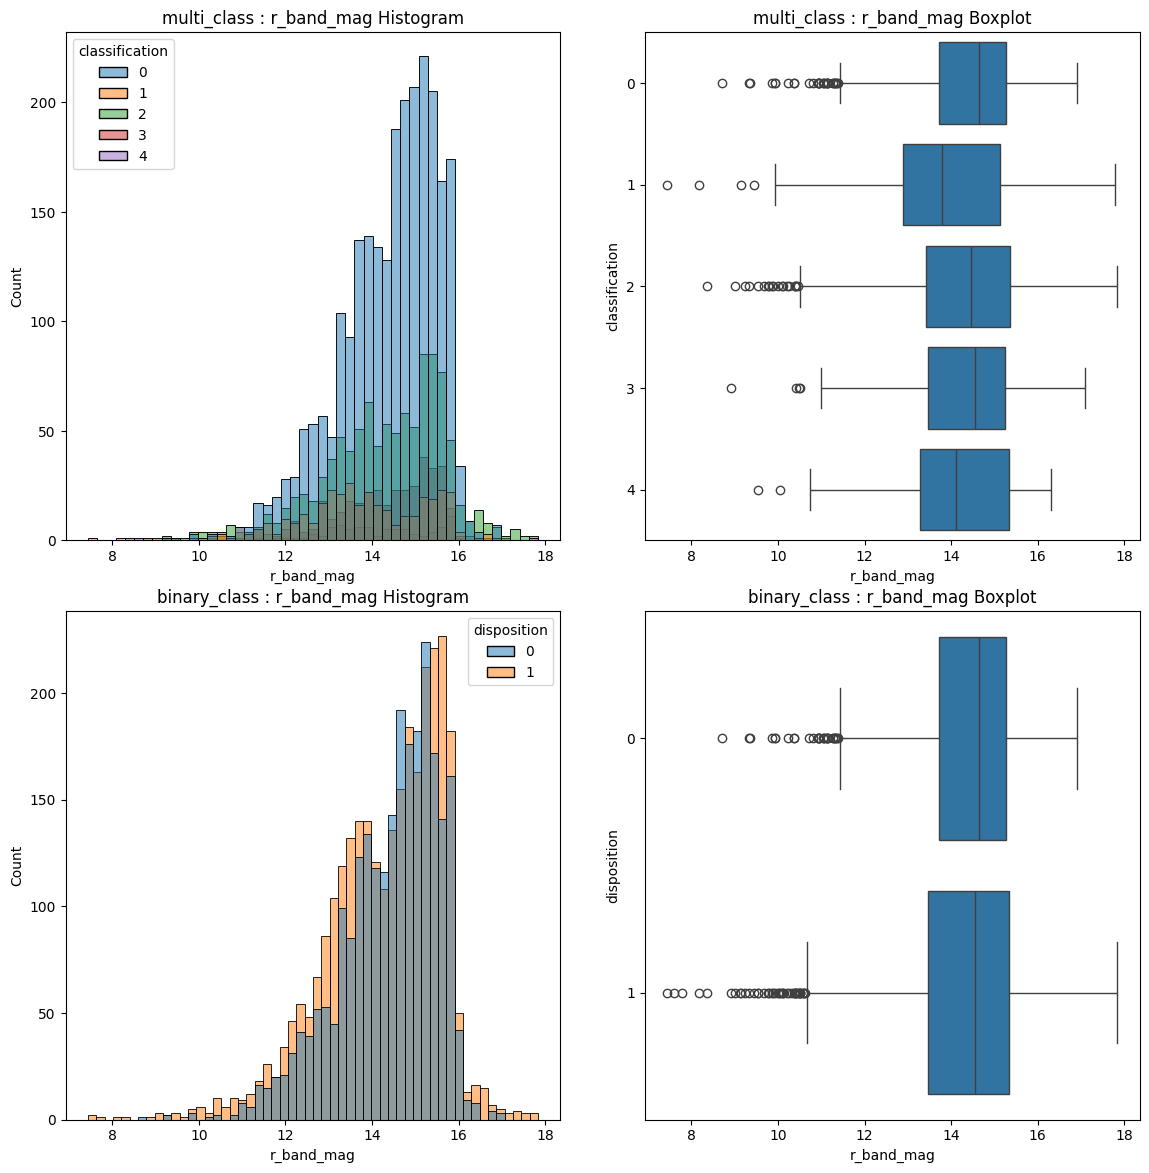

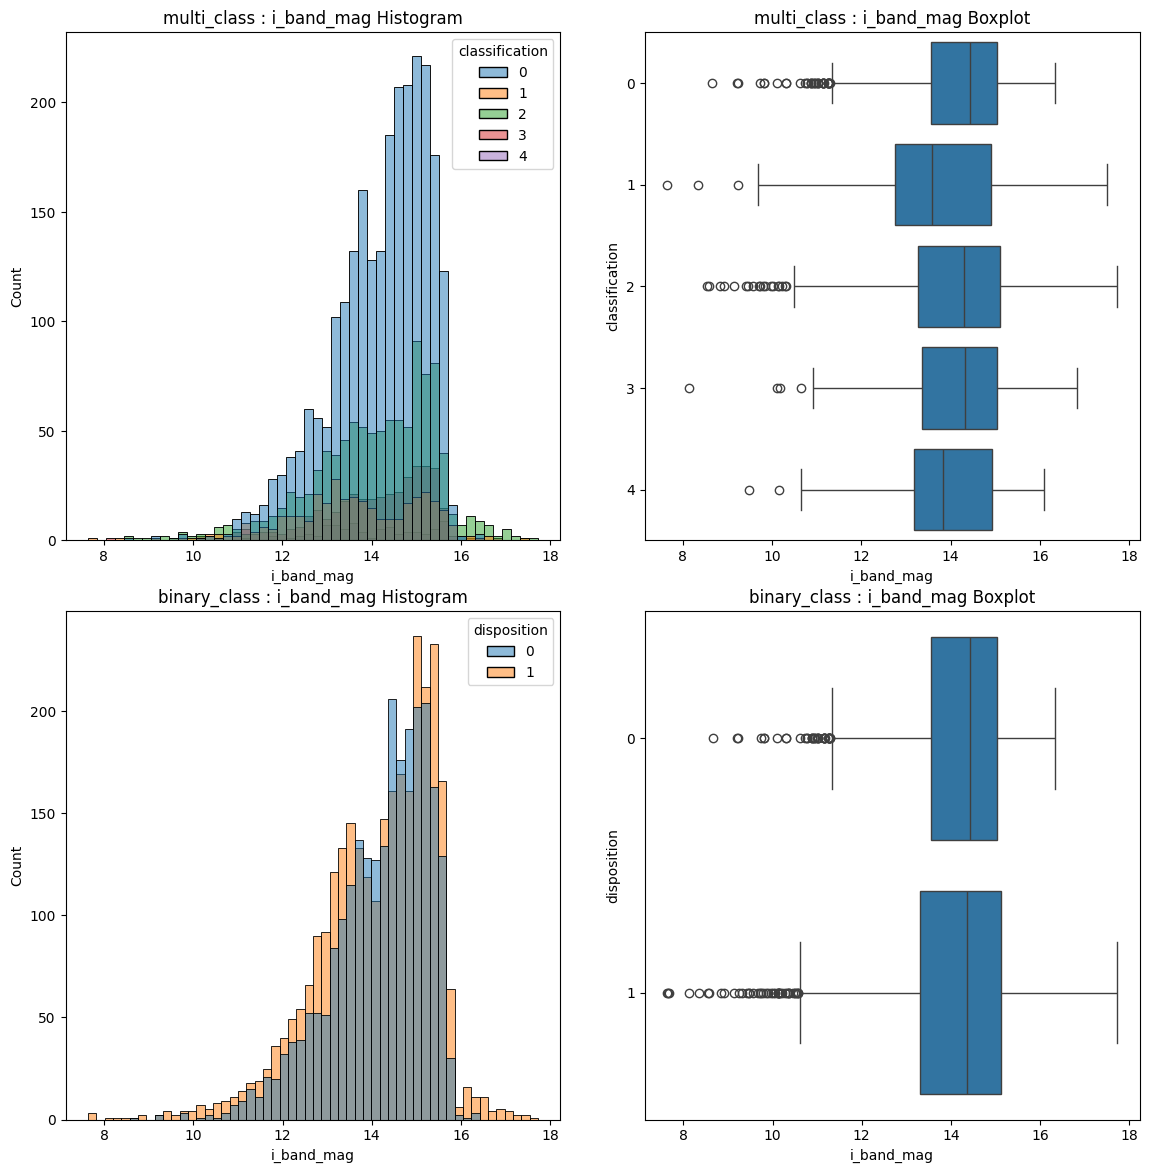

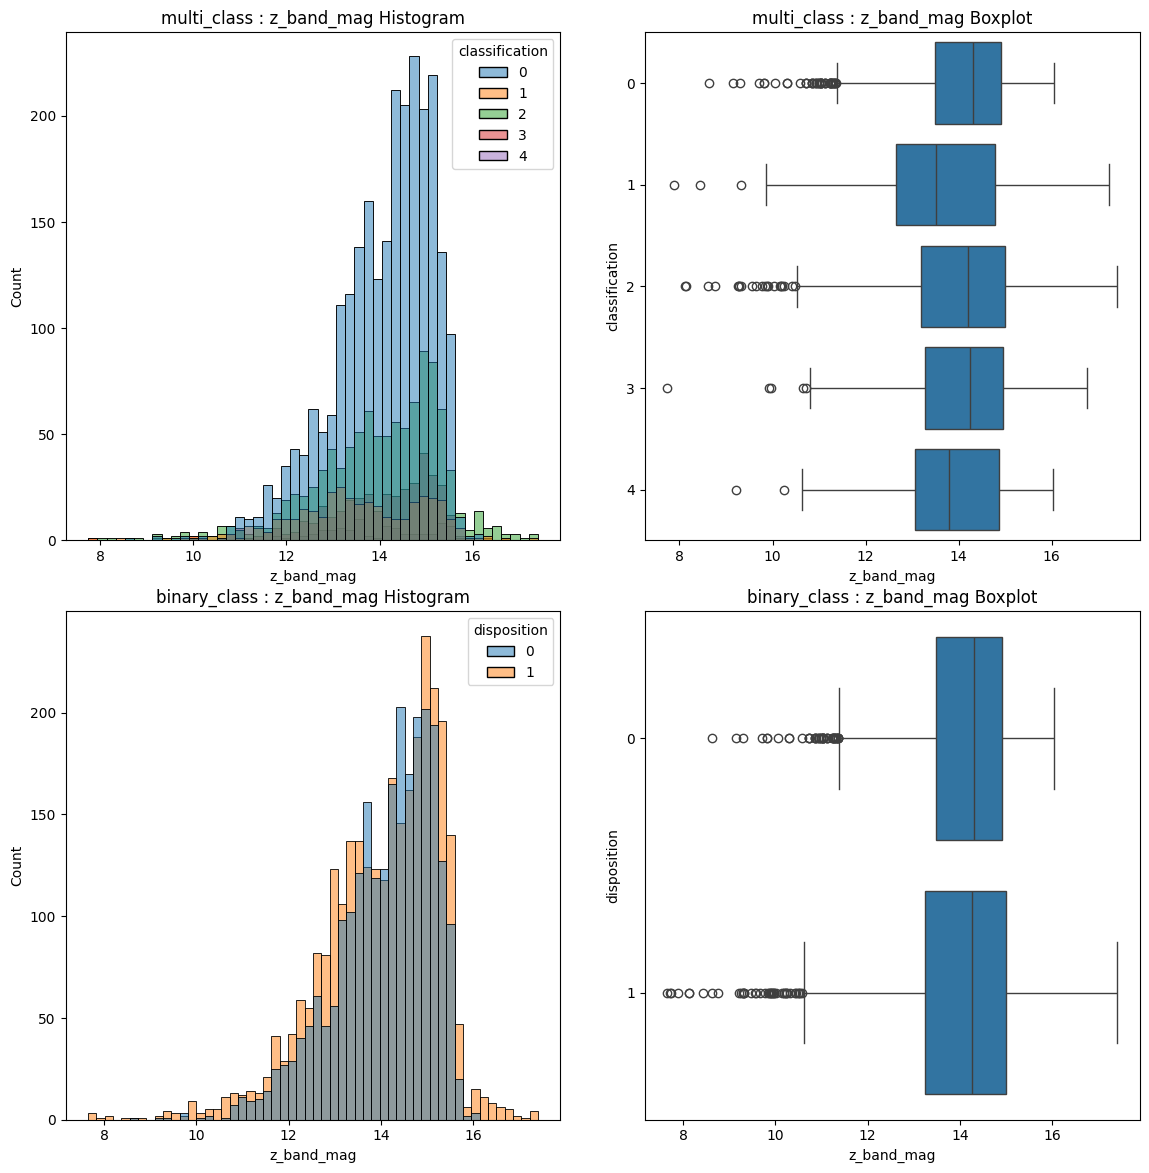

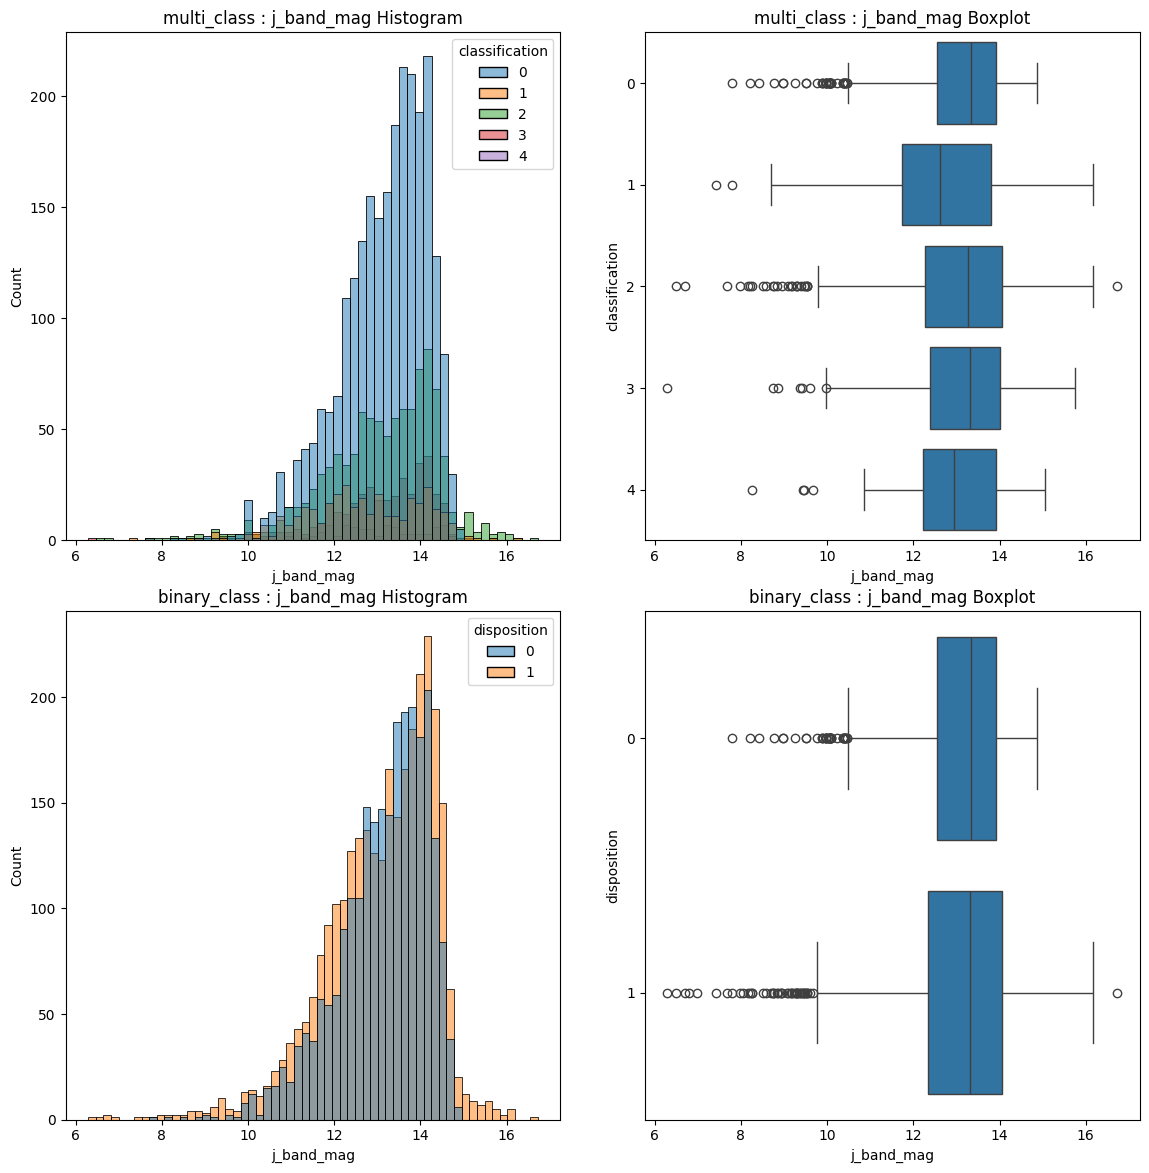

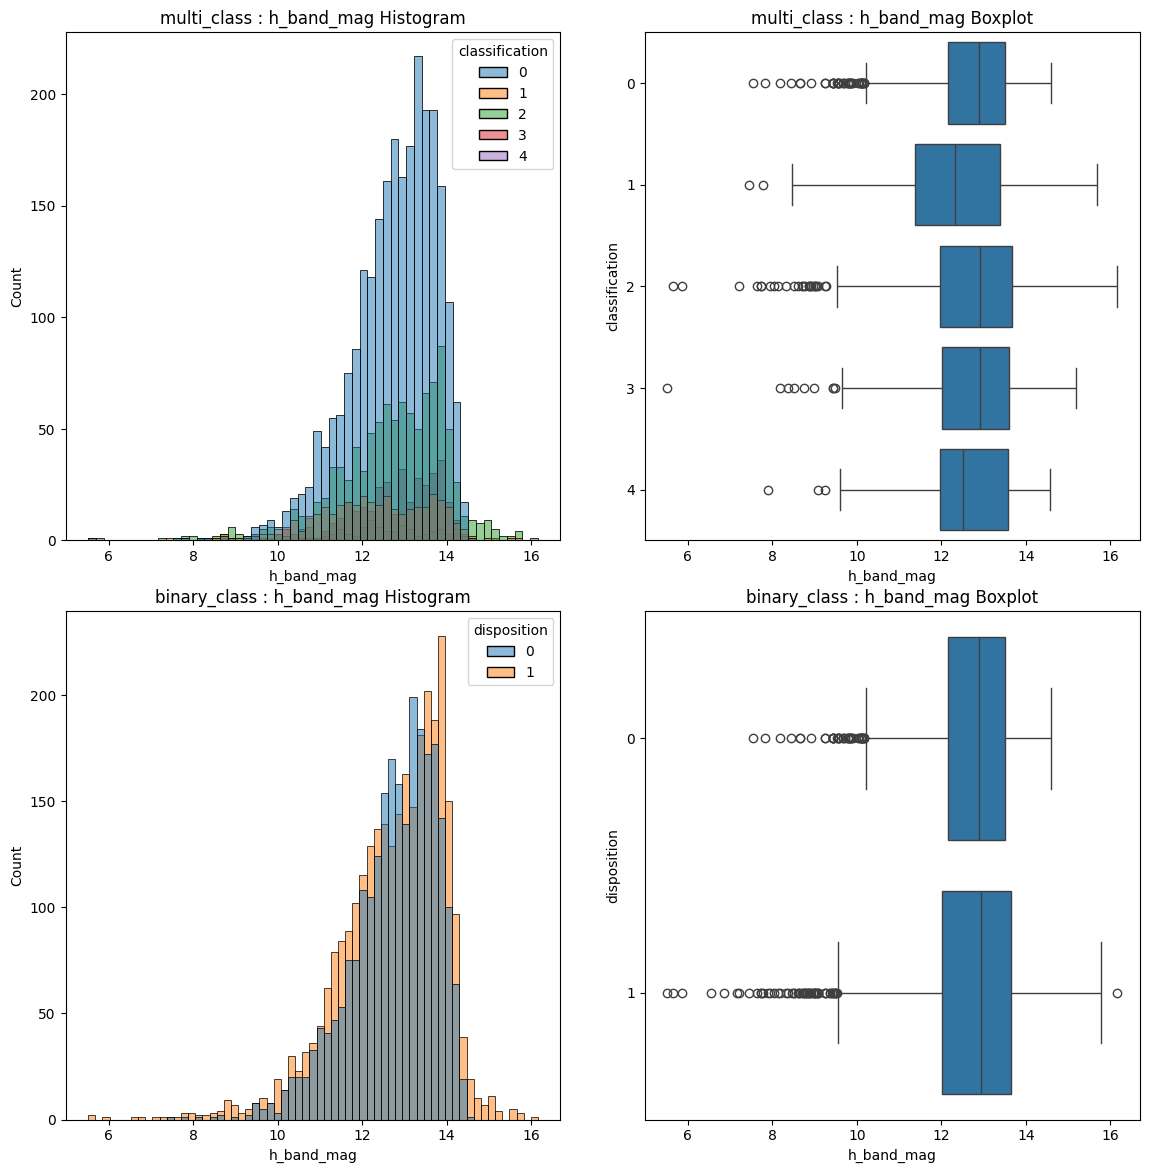

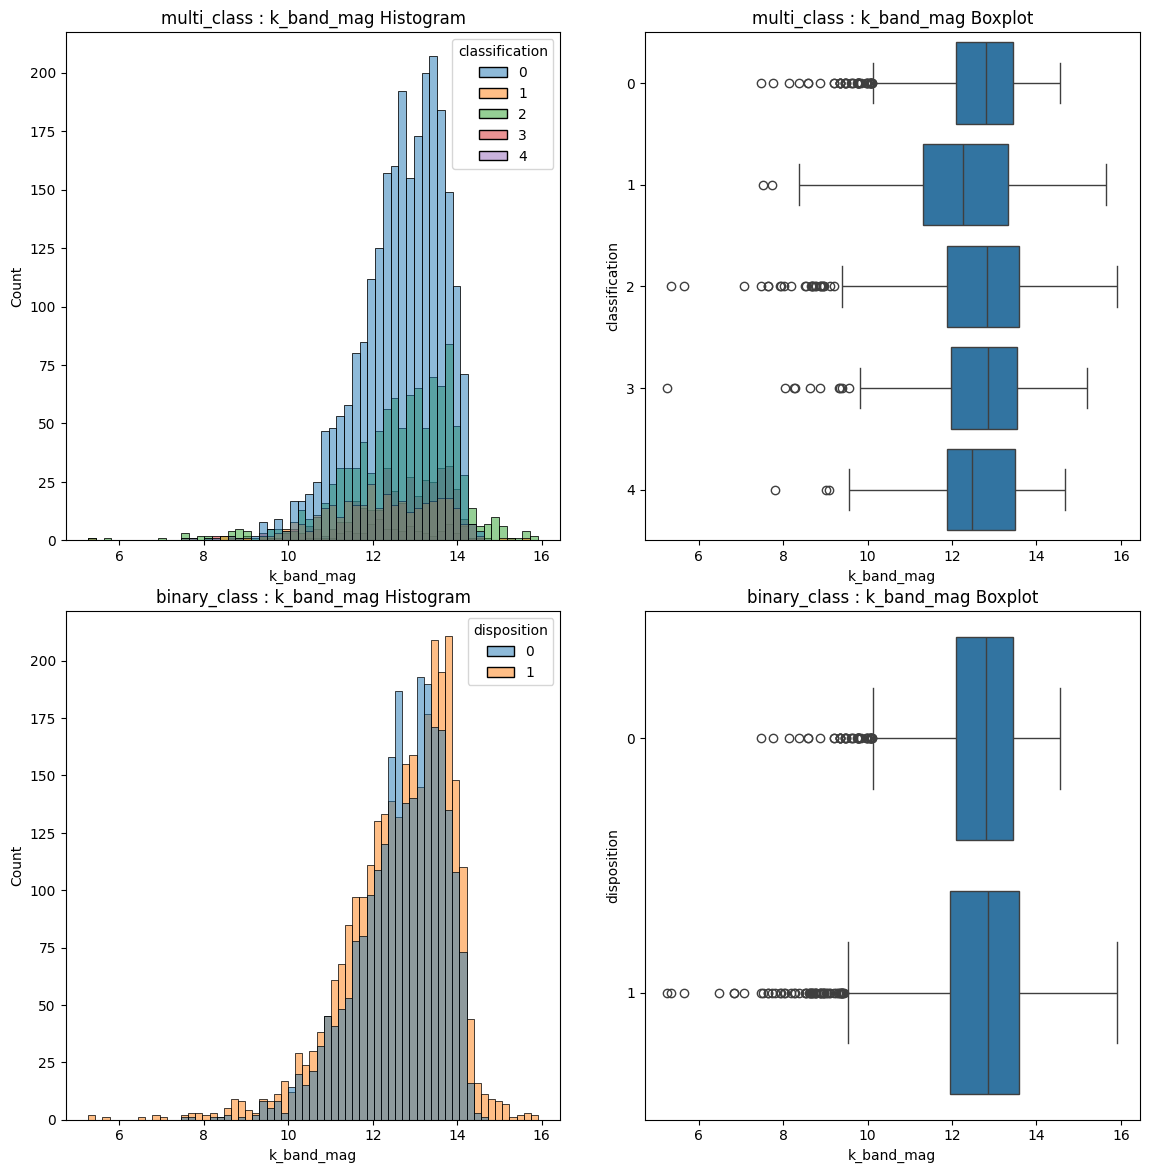

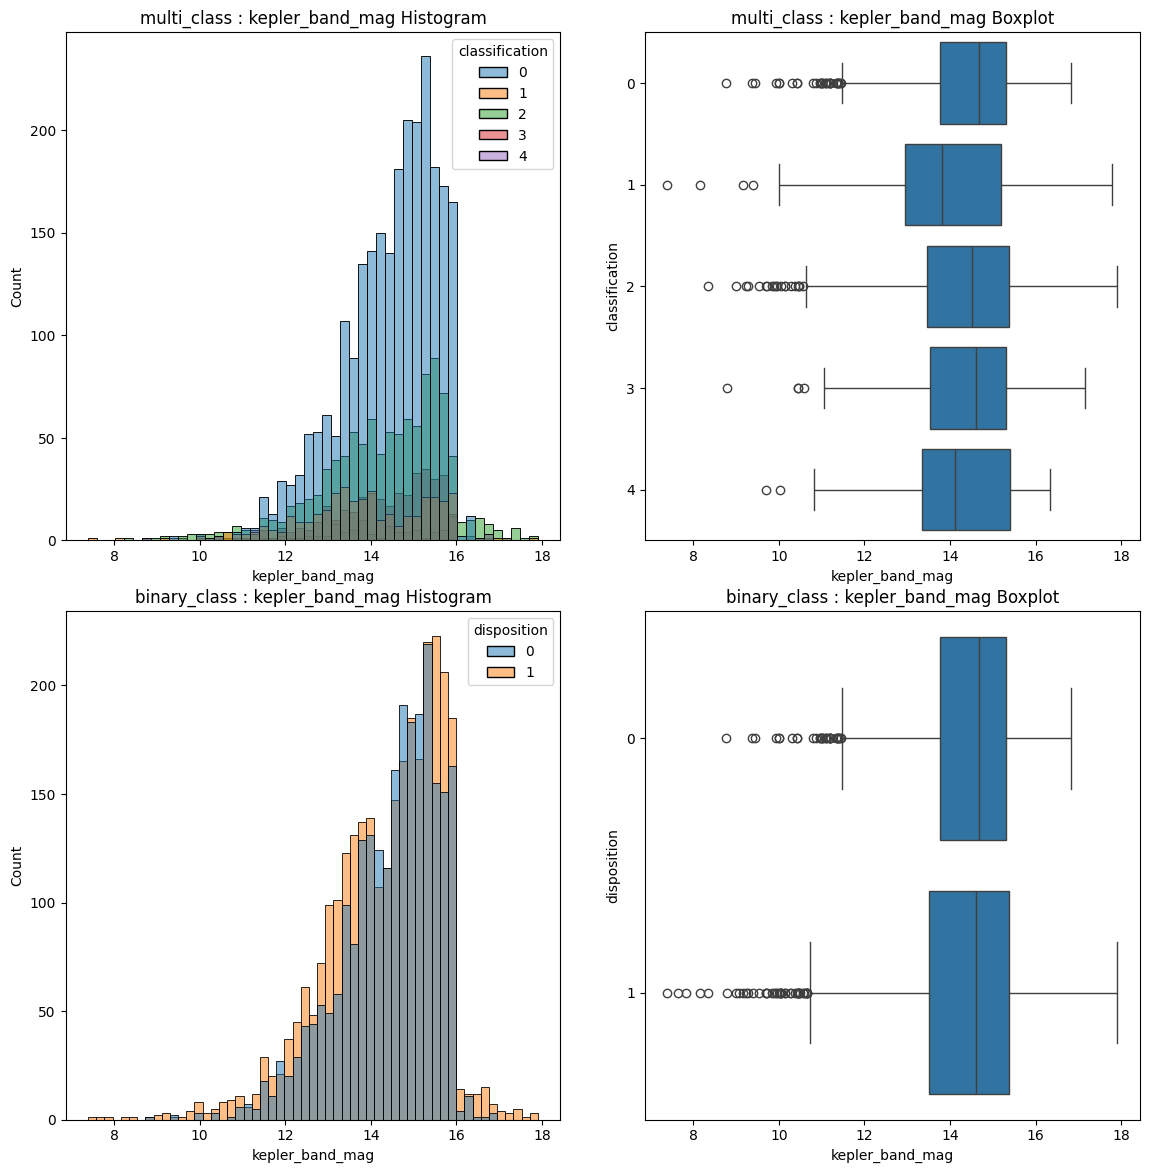

In [6]:
# Close all figures before plotting, as matplotlib figures are kept open until explicitly closed
# Keeping too many figures open leads to memory issues and warnings
# Inspect features 12 at a time for readability and memory reasons
plt.close('all')
for column in numerical_columns[0:12]:
    plot_distributions([multi_class, binary_class], column, ['classification', 'disposition'], kde = False)

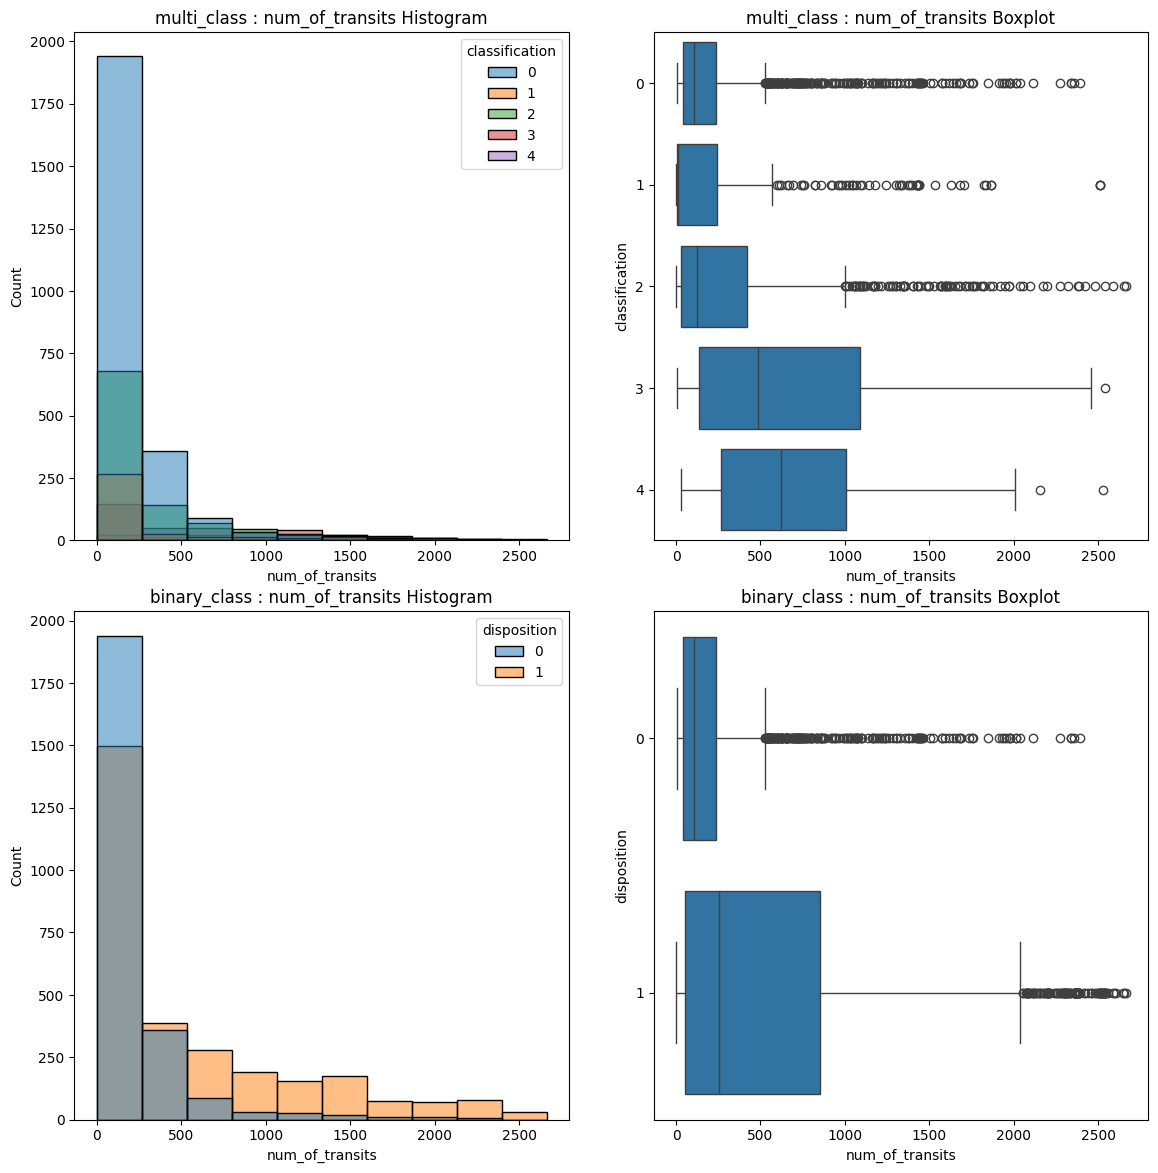

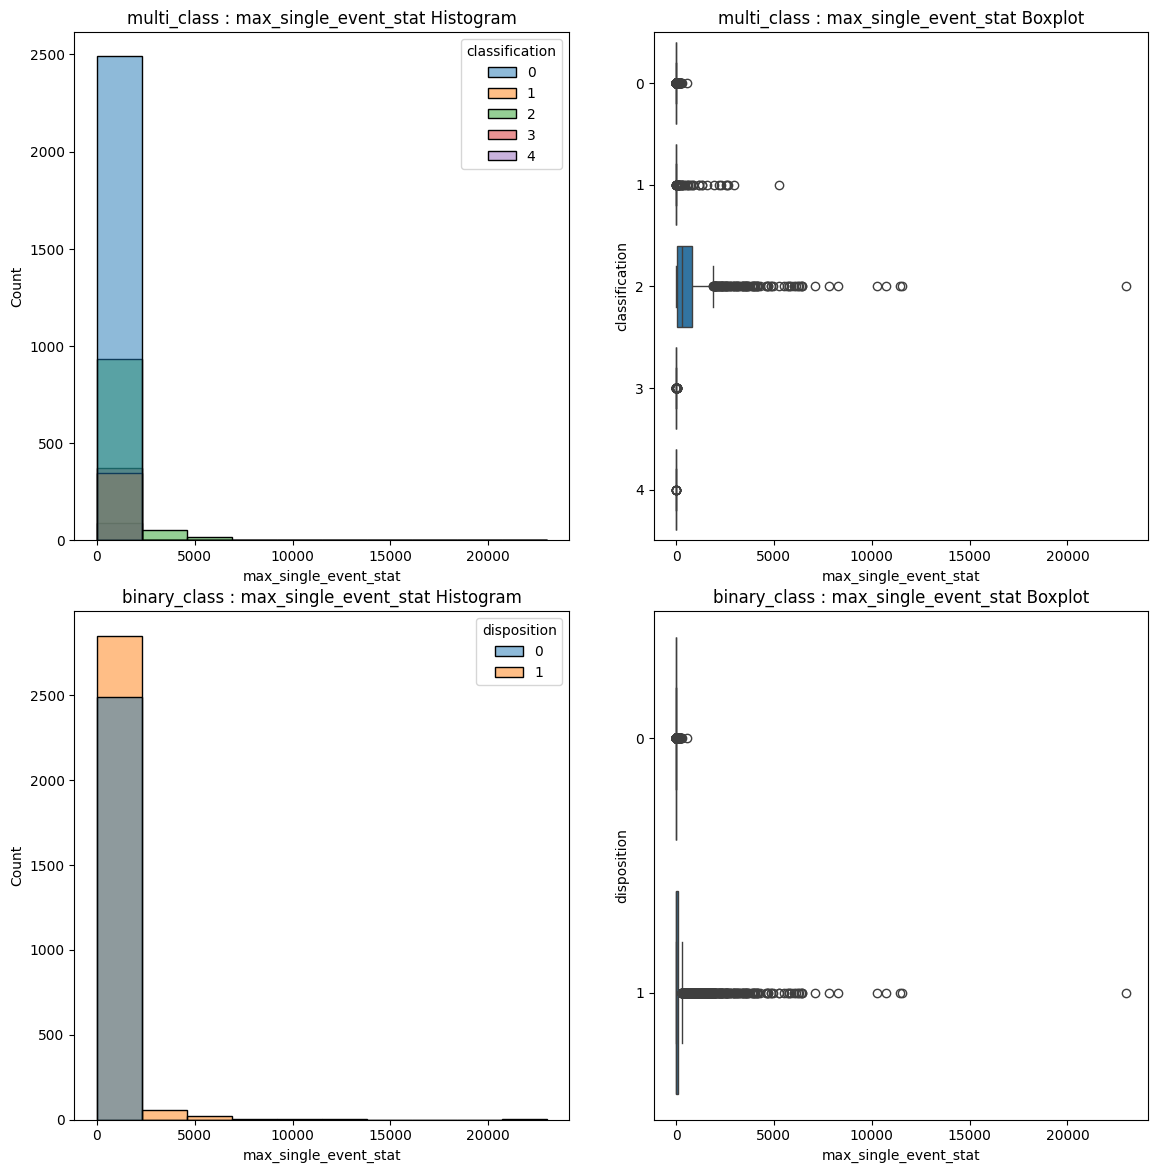

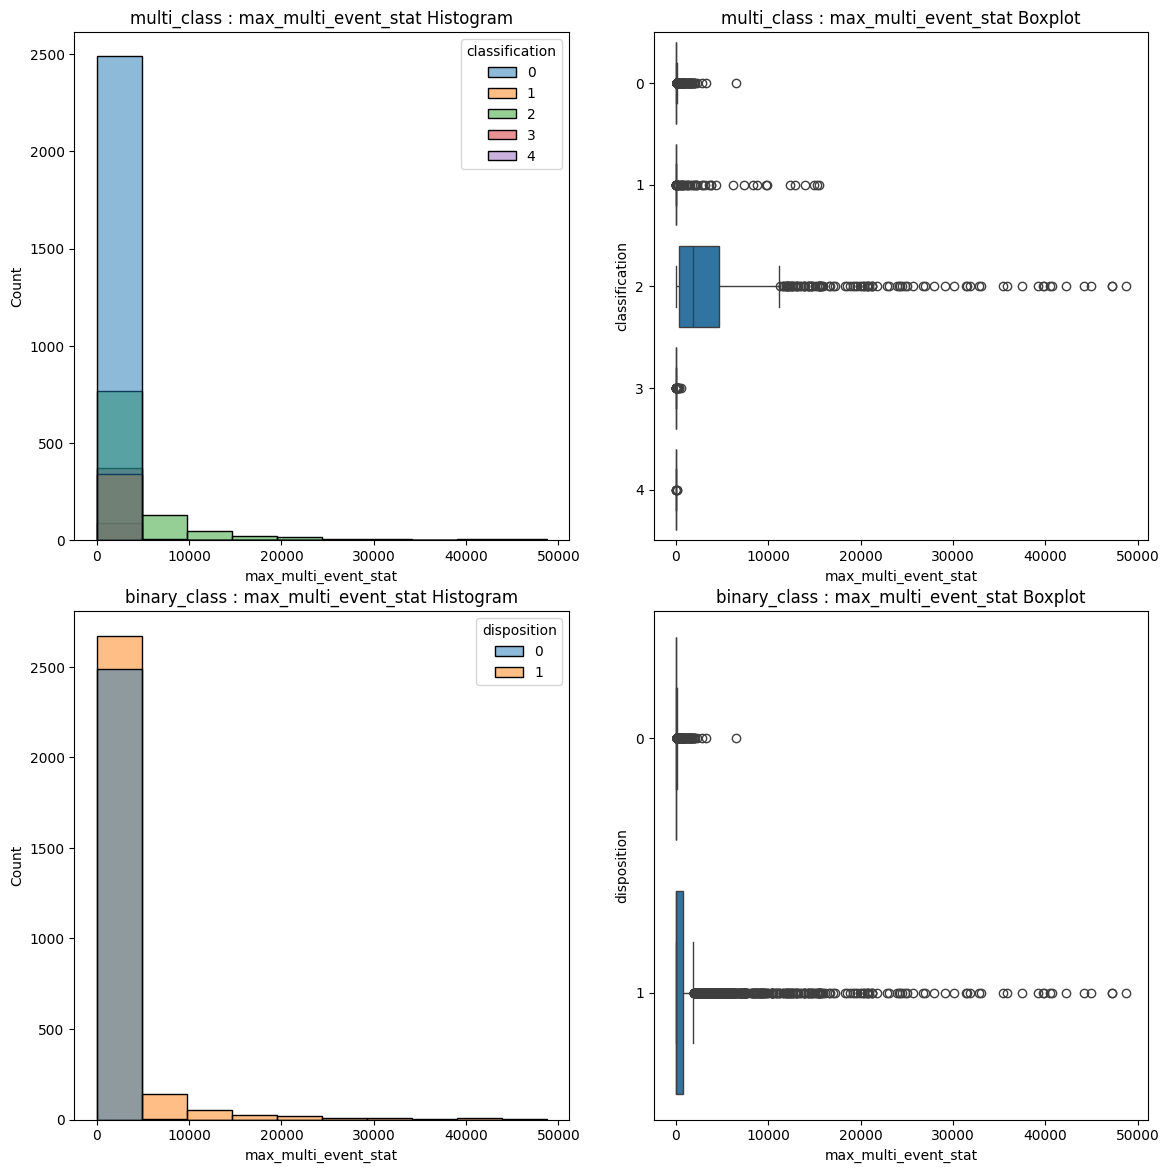

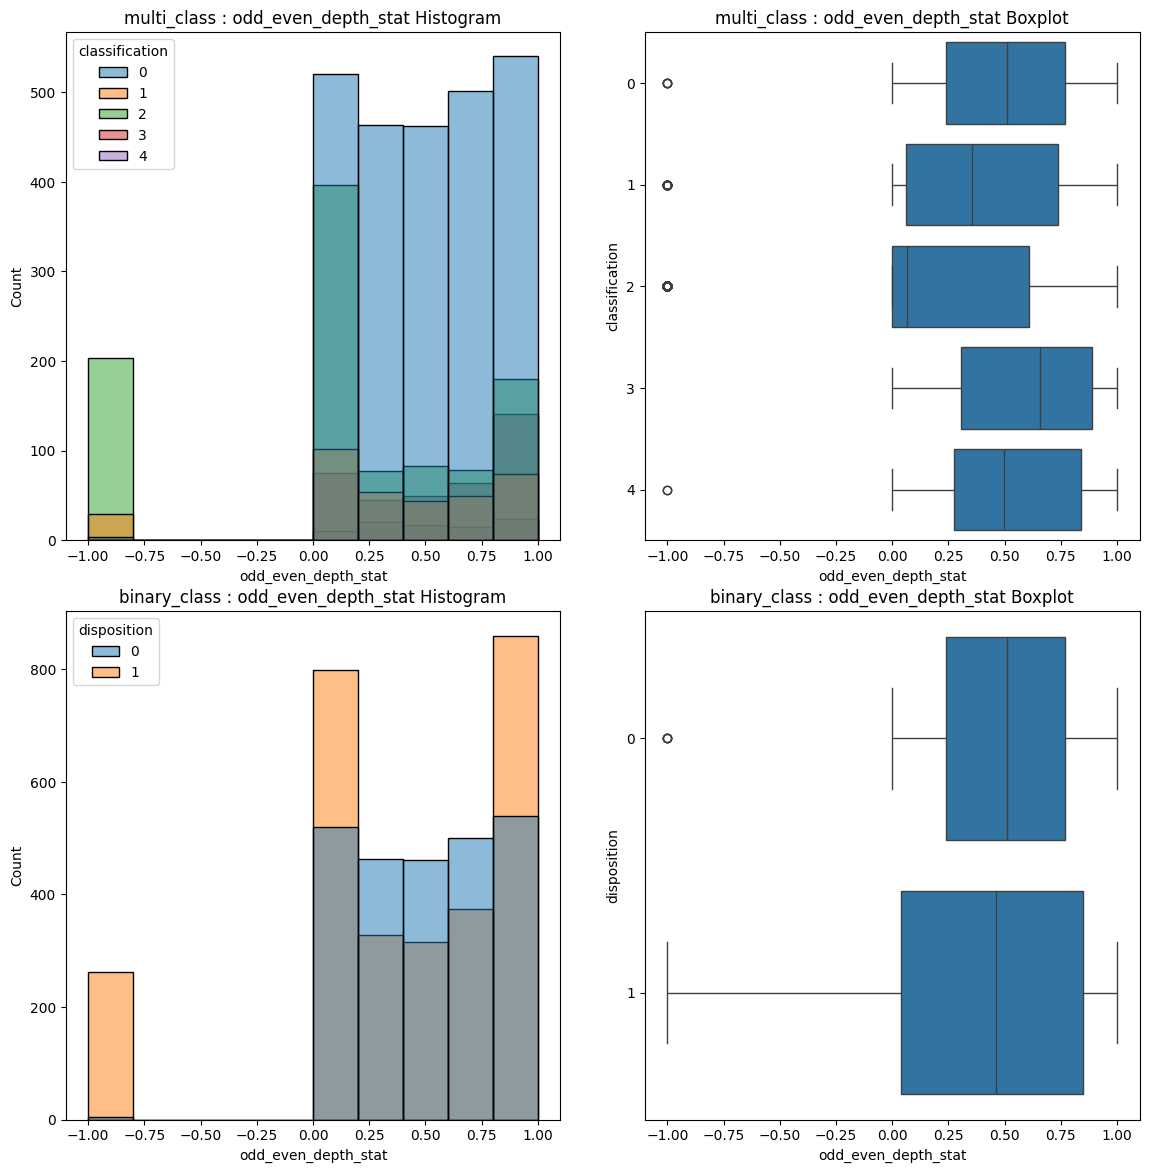

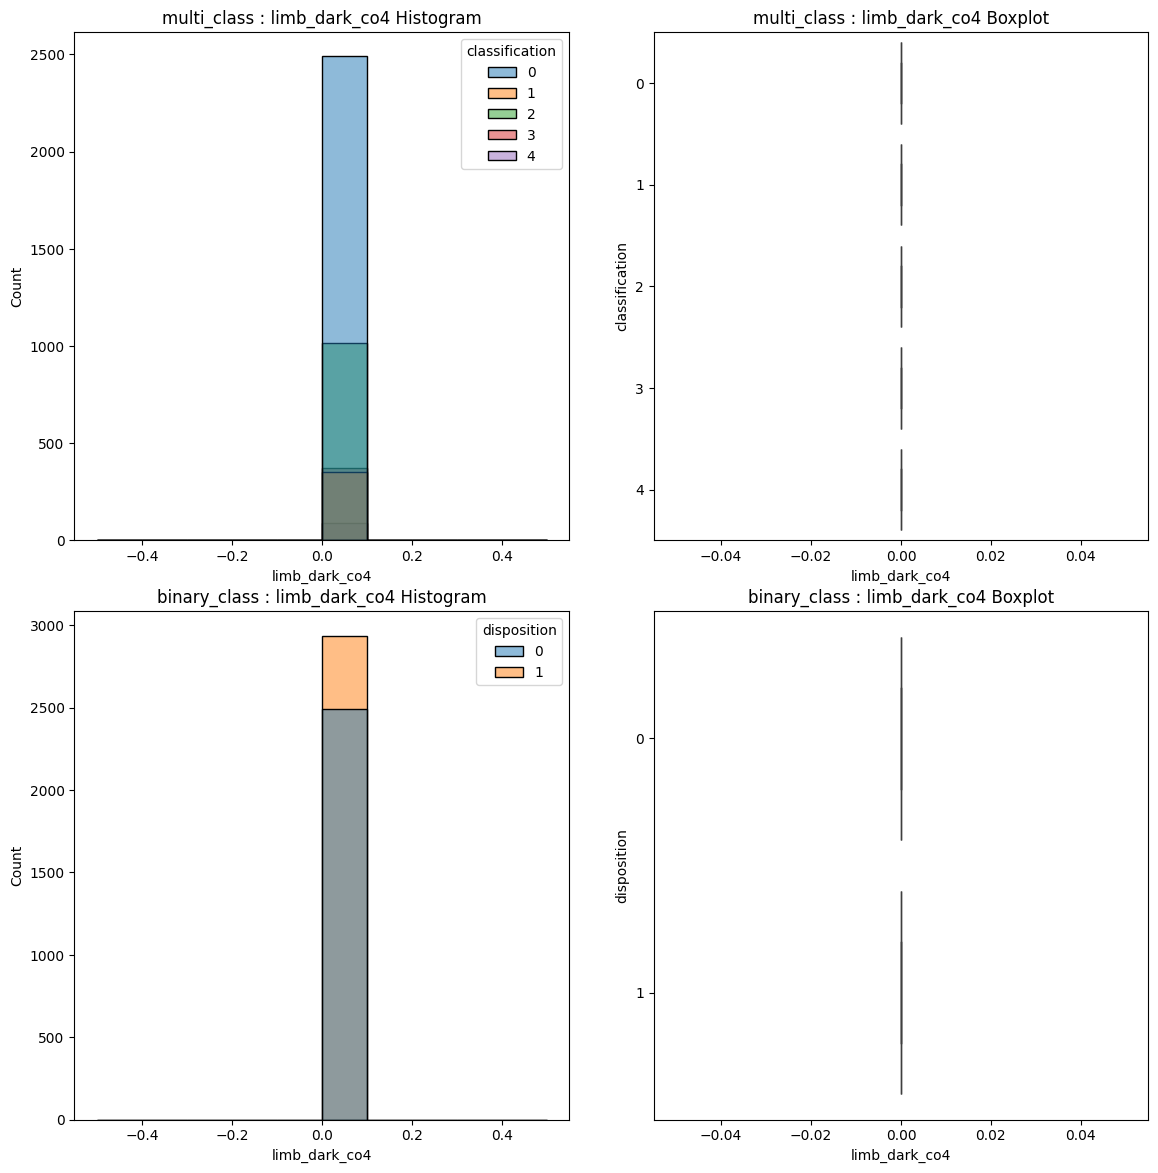

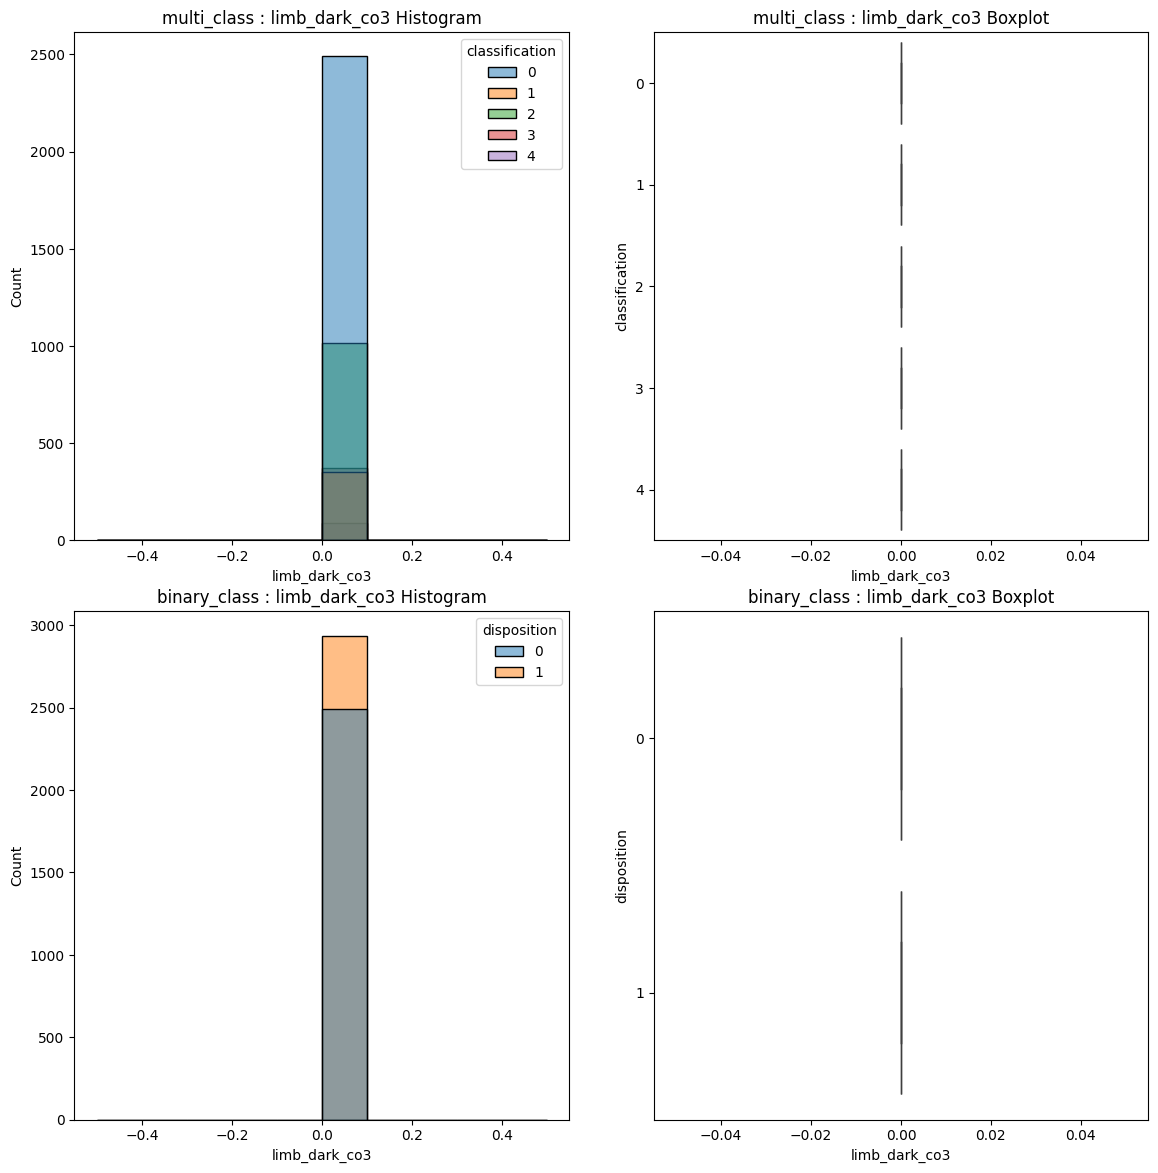

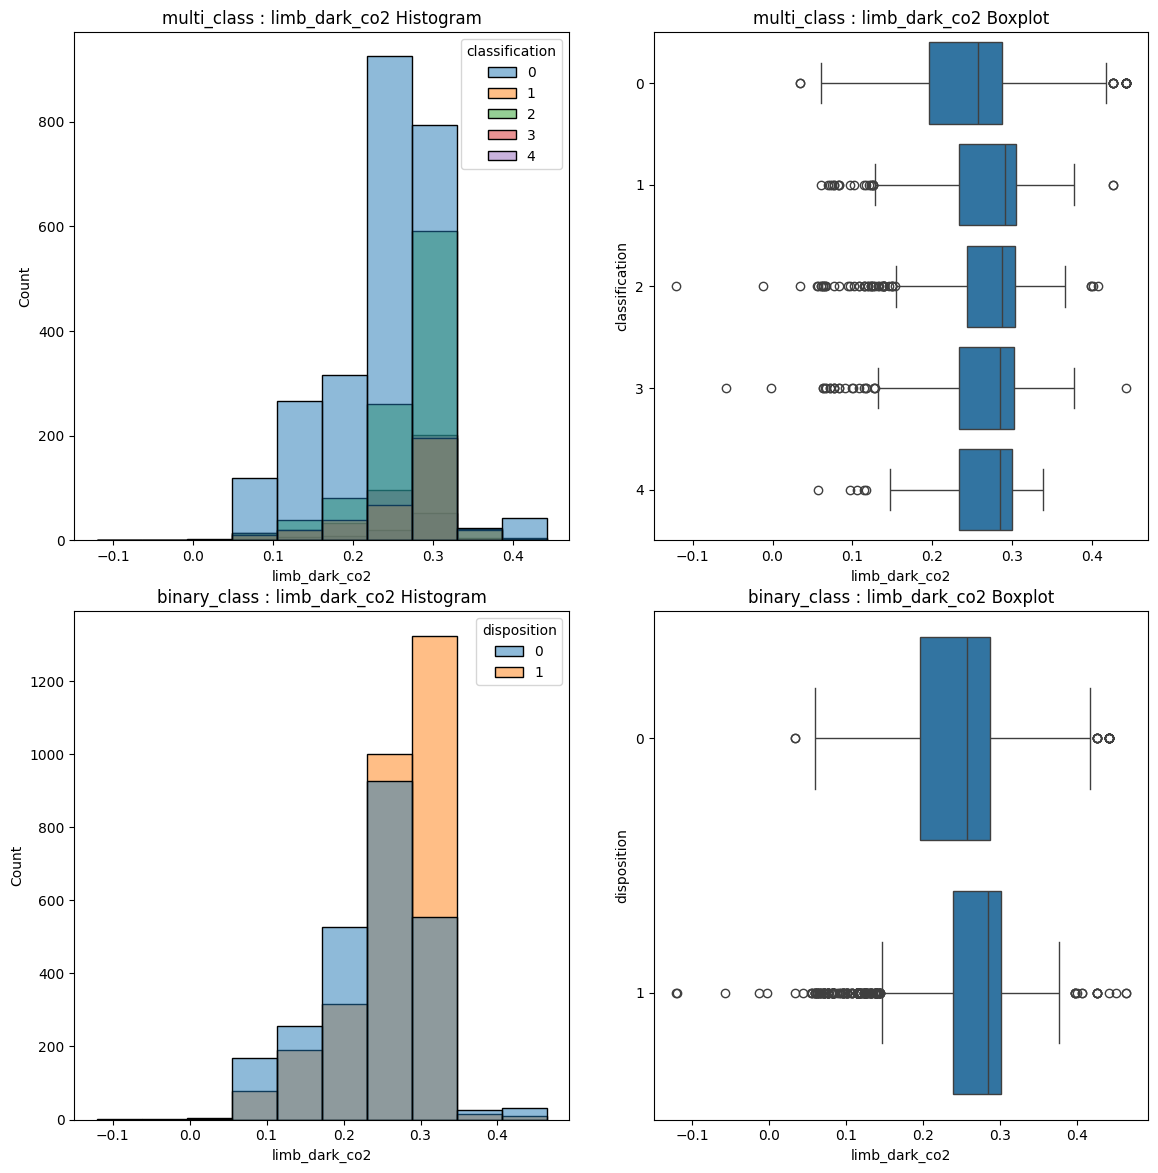

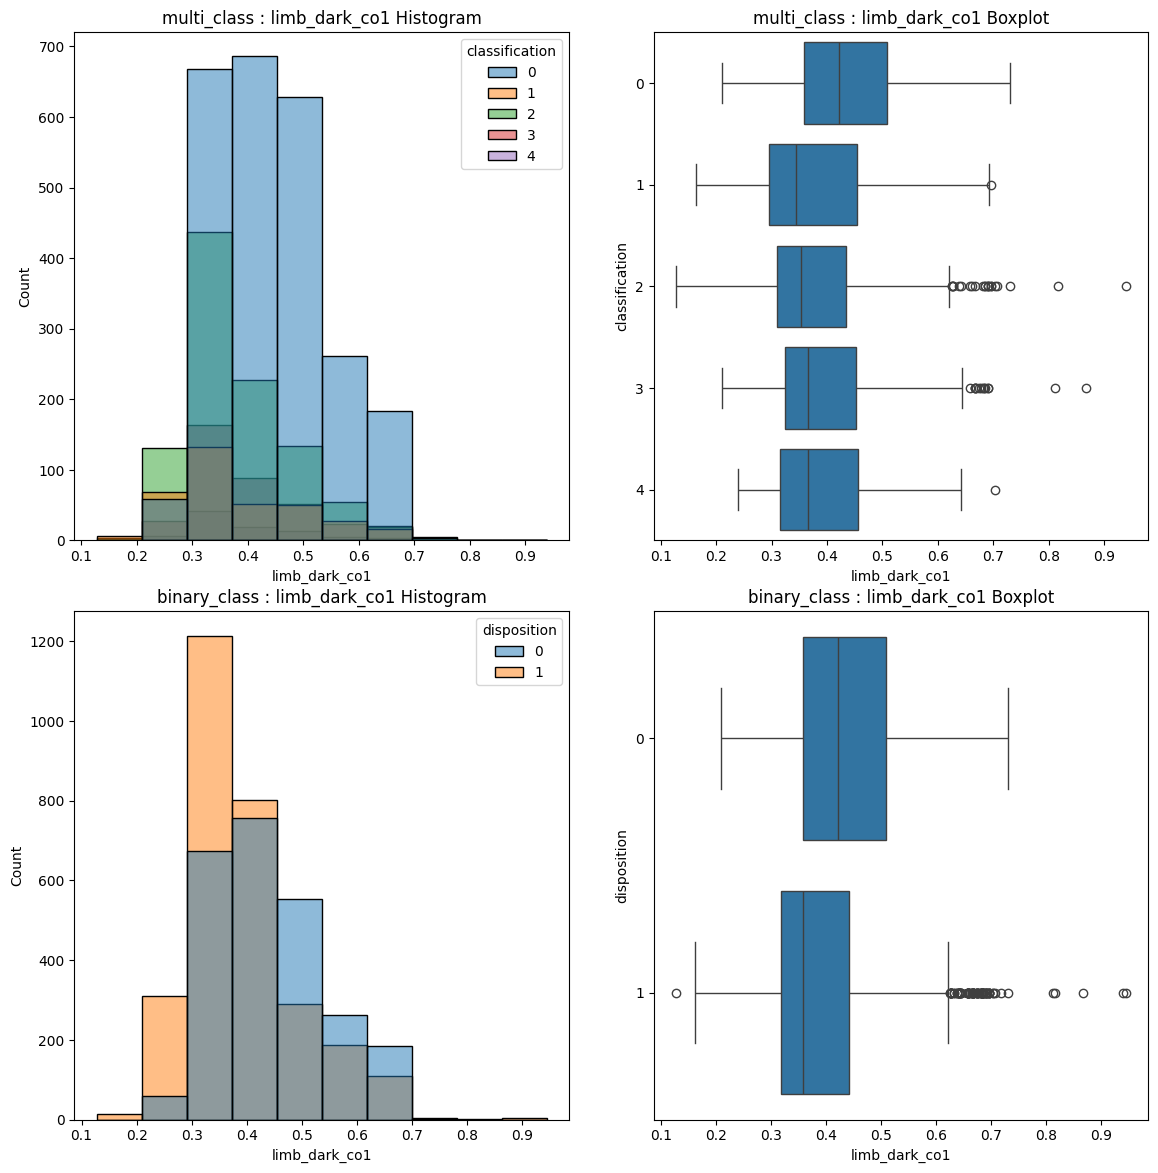

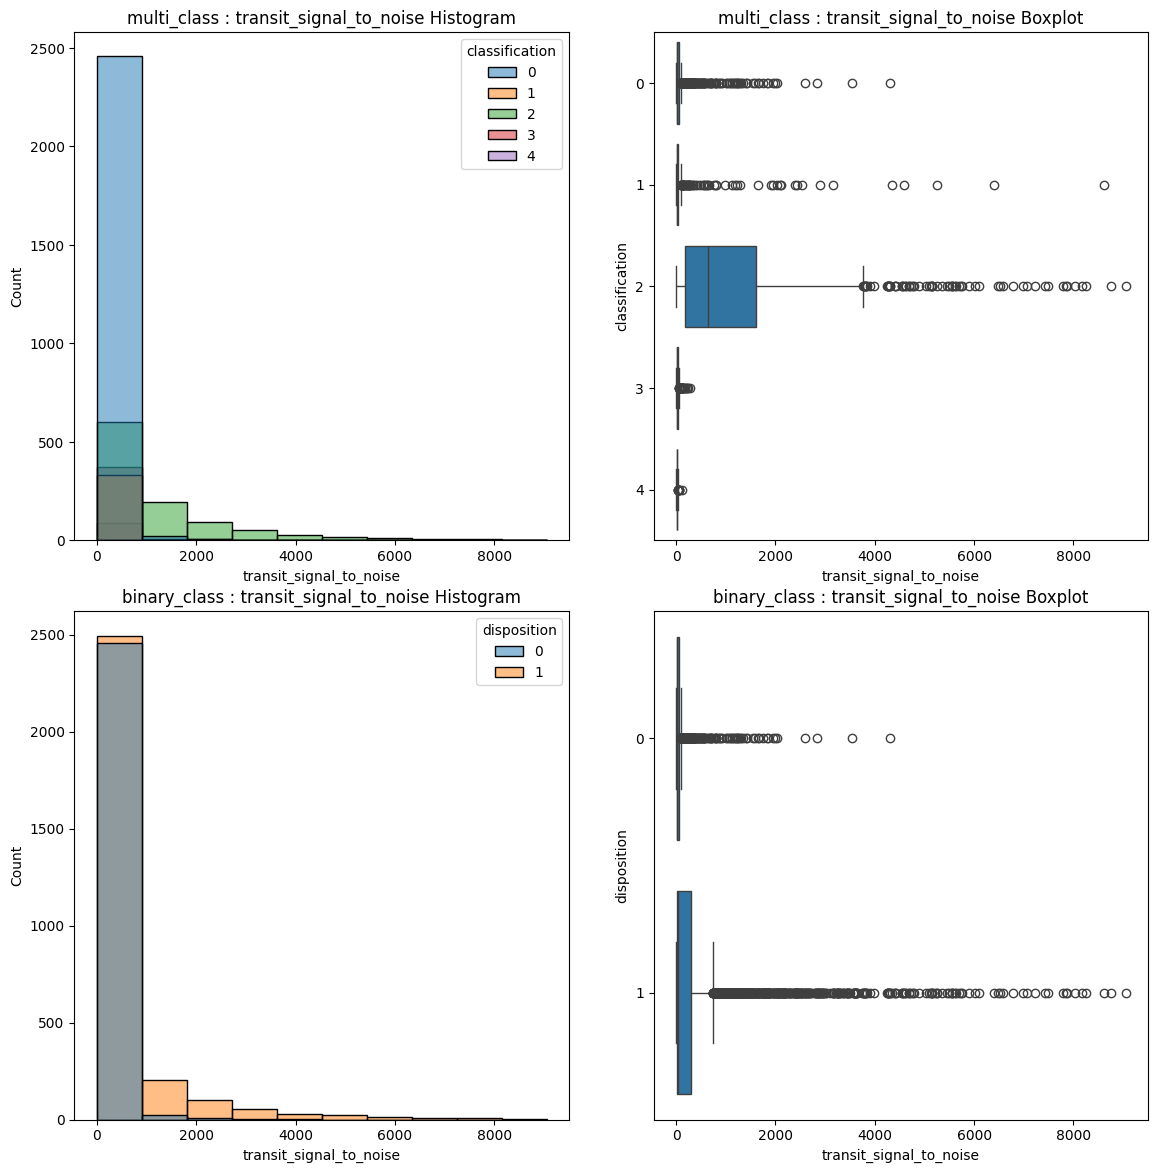

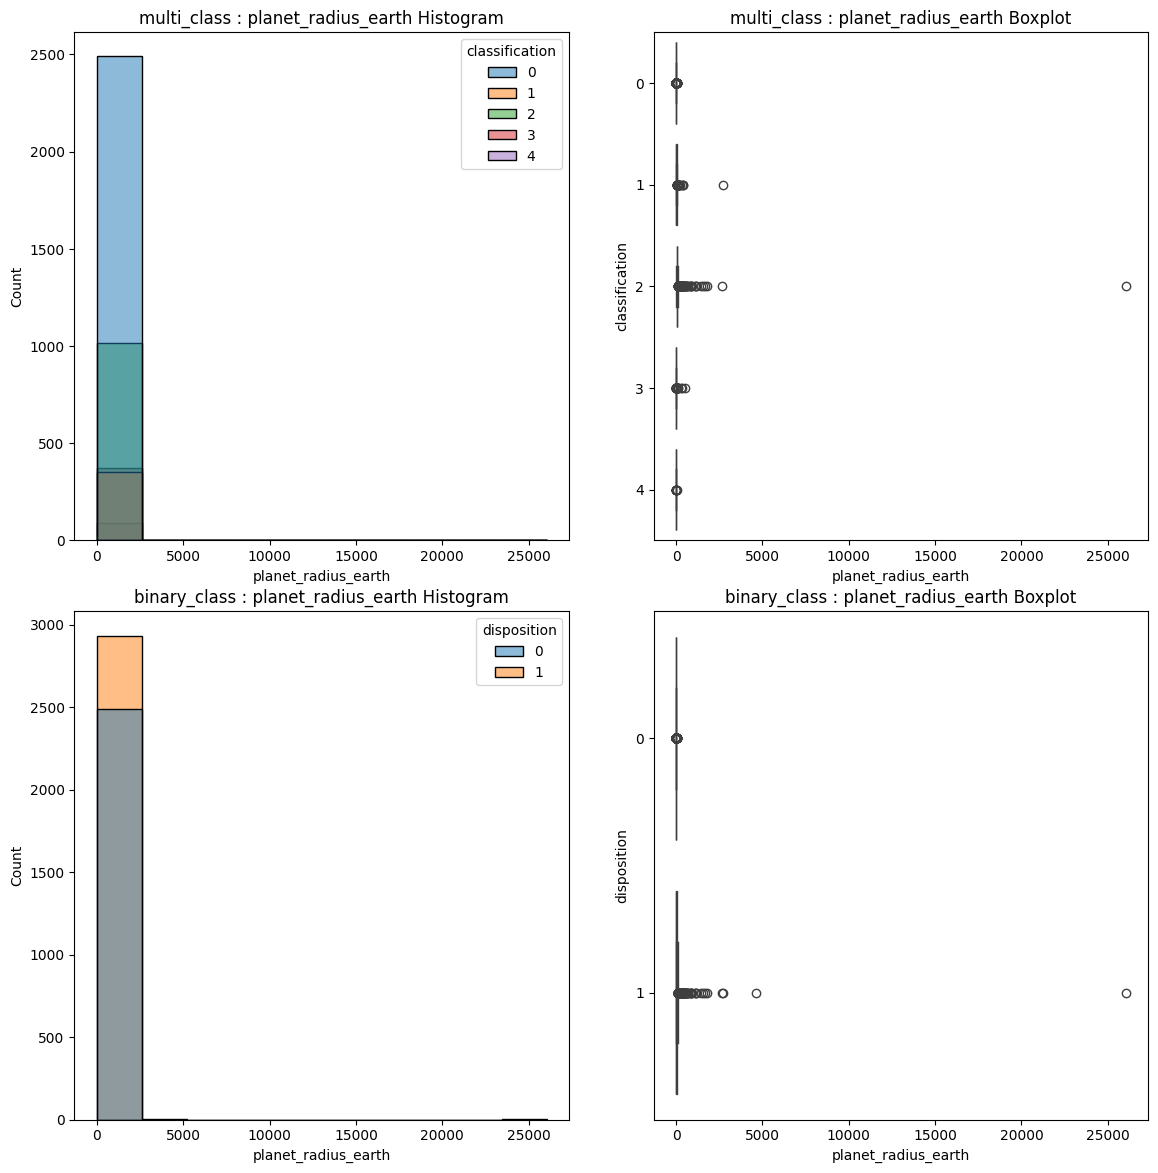

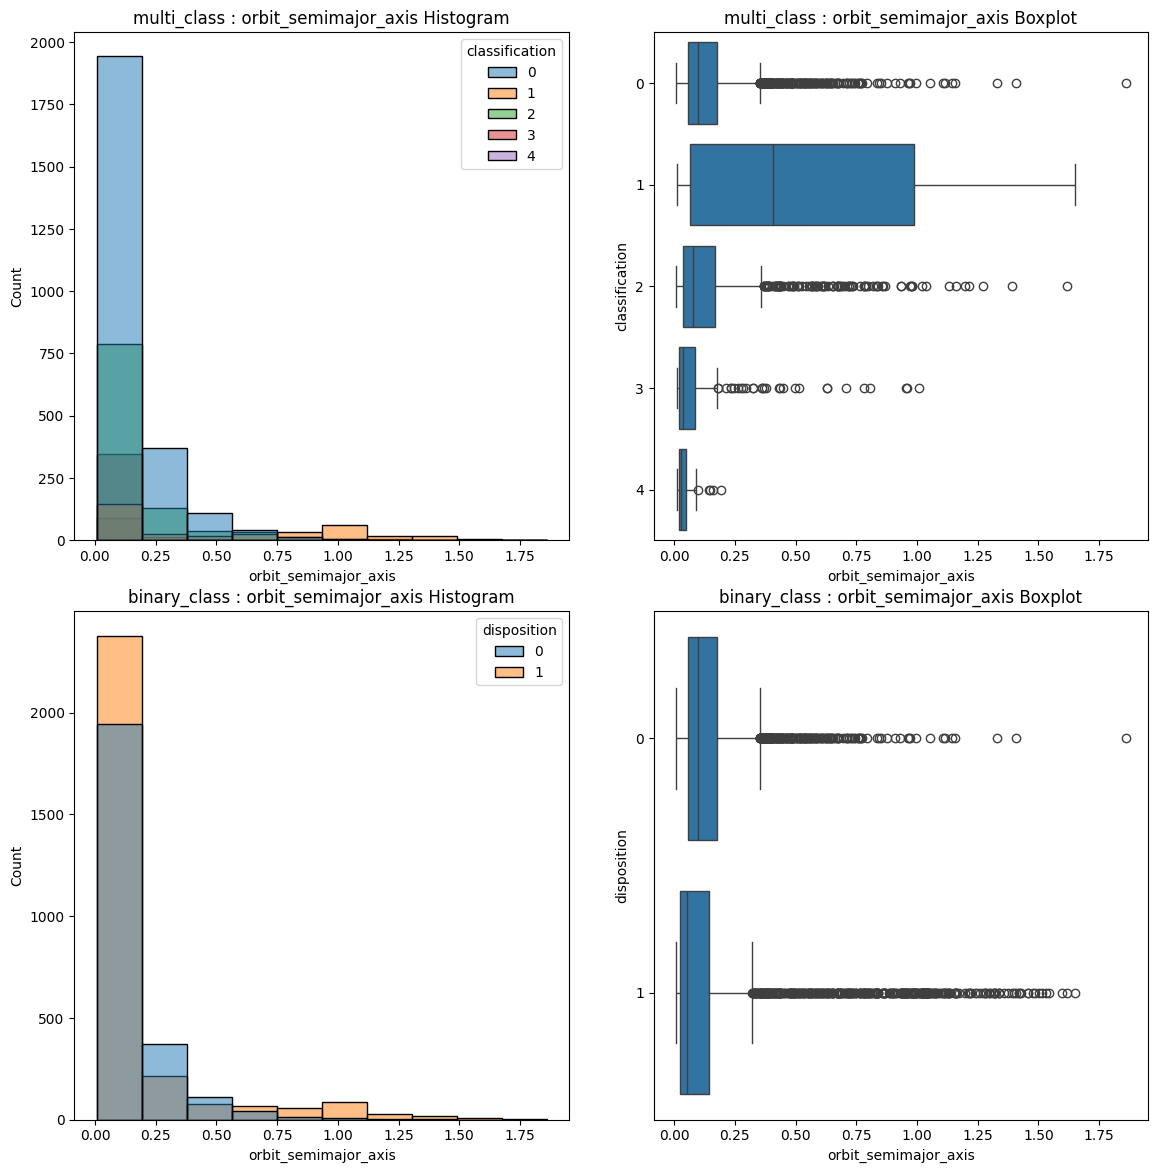

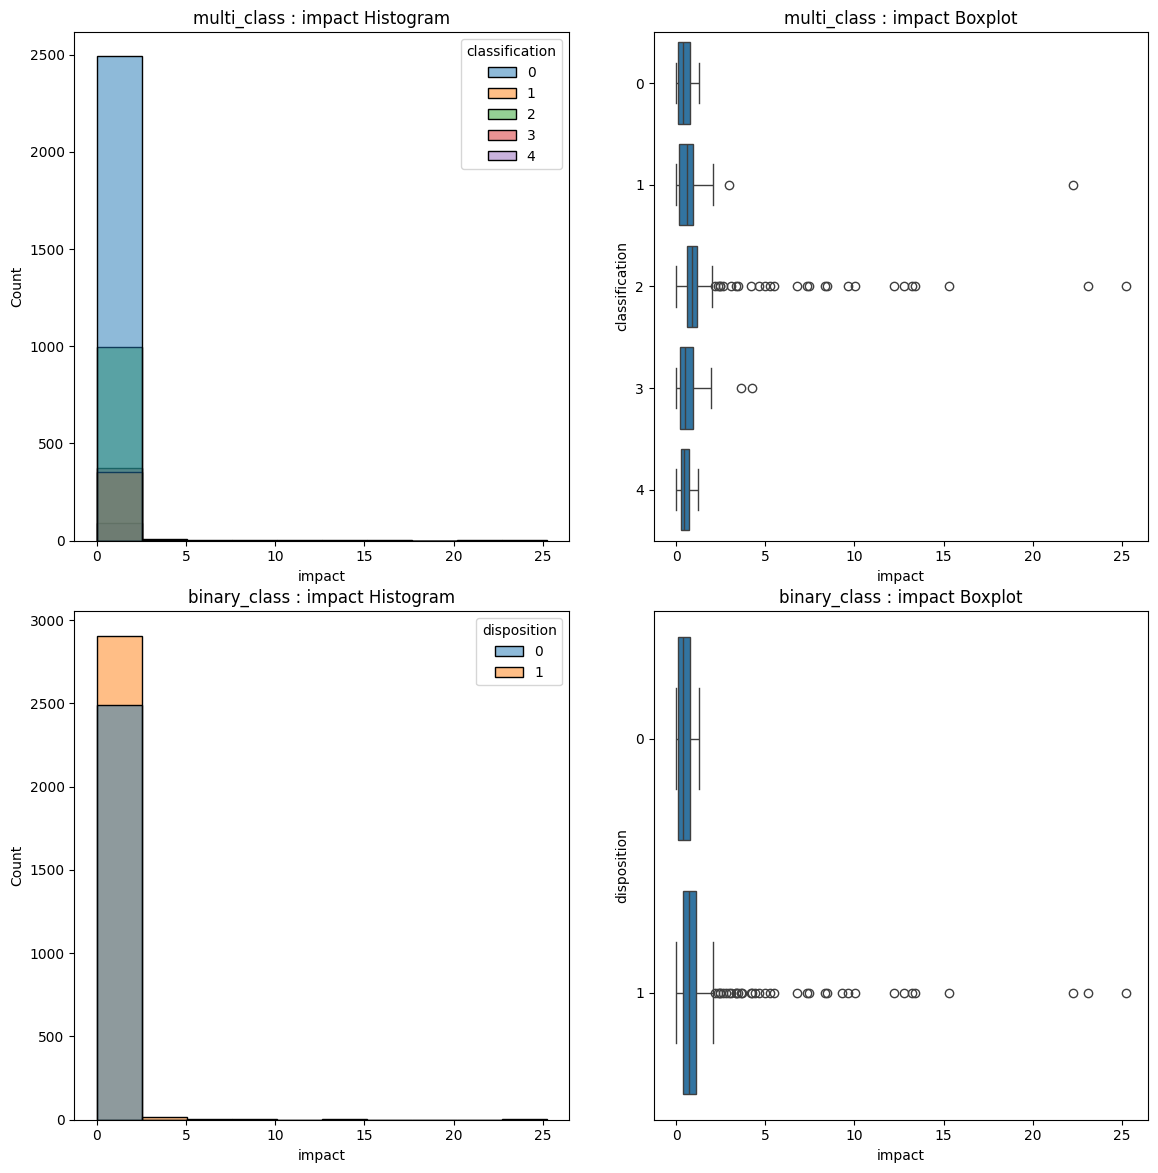

In [7]:
# Use bin size 10 for speed of calculations, as 'auto' takes a long time to solve if data is not dense
plt.close('all')
for column in numerical_columns[12:24]:
    plot_distributions([multi_class, binary_class], column, ['classification', 'disposition'],
                       kde = False, bins = 10)

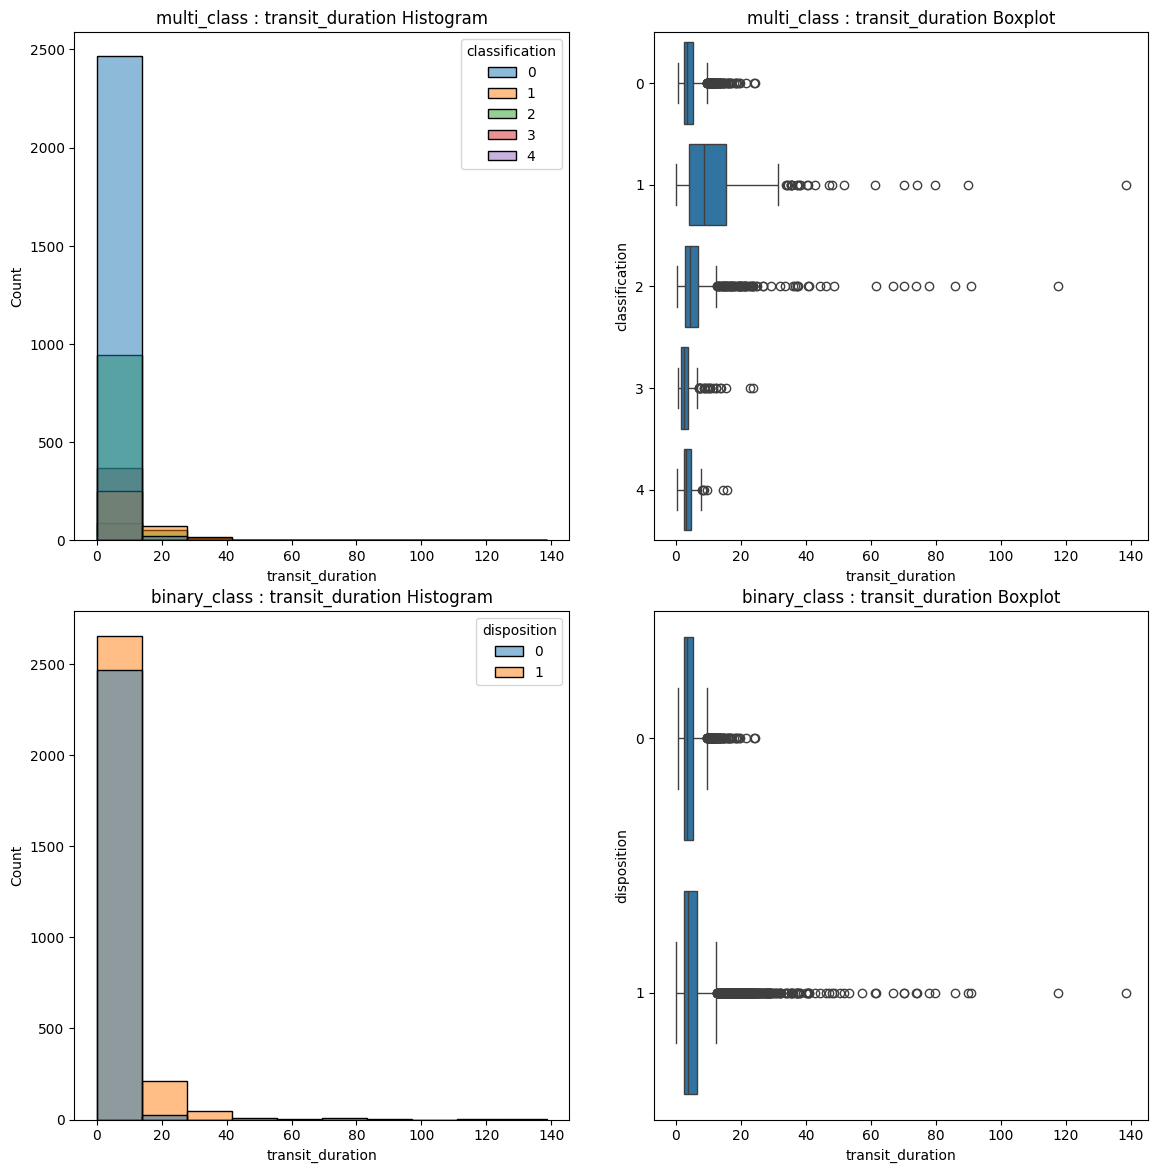

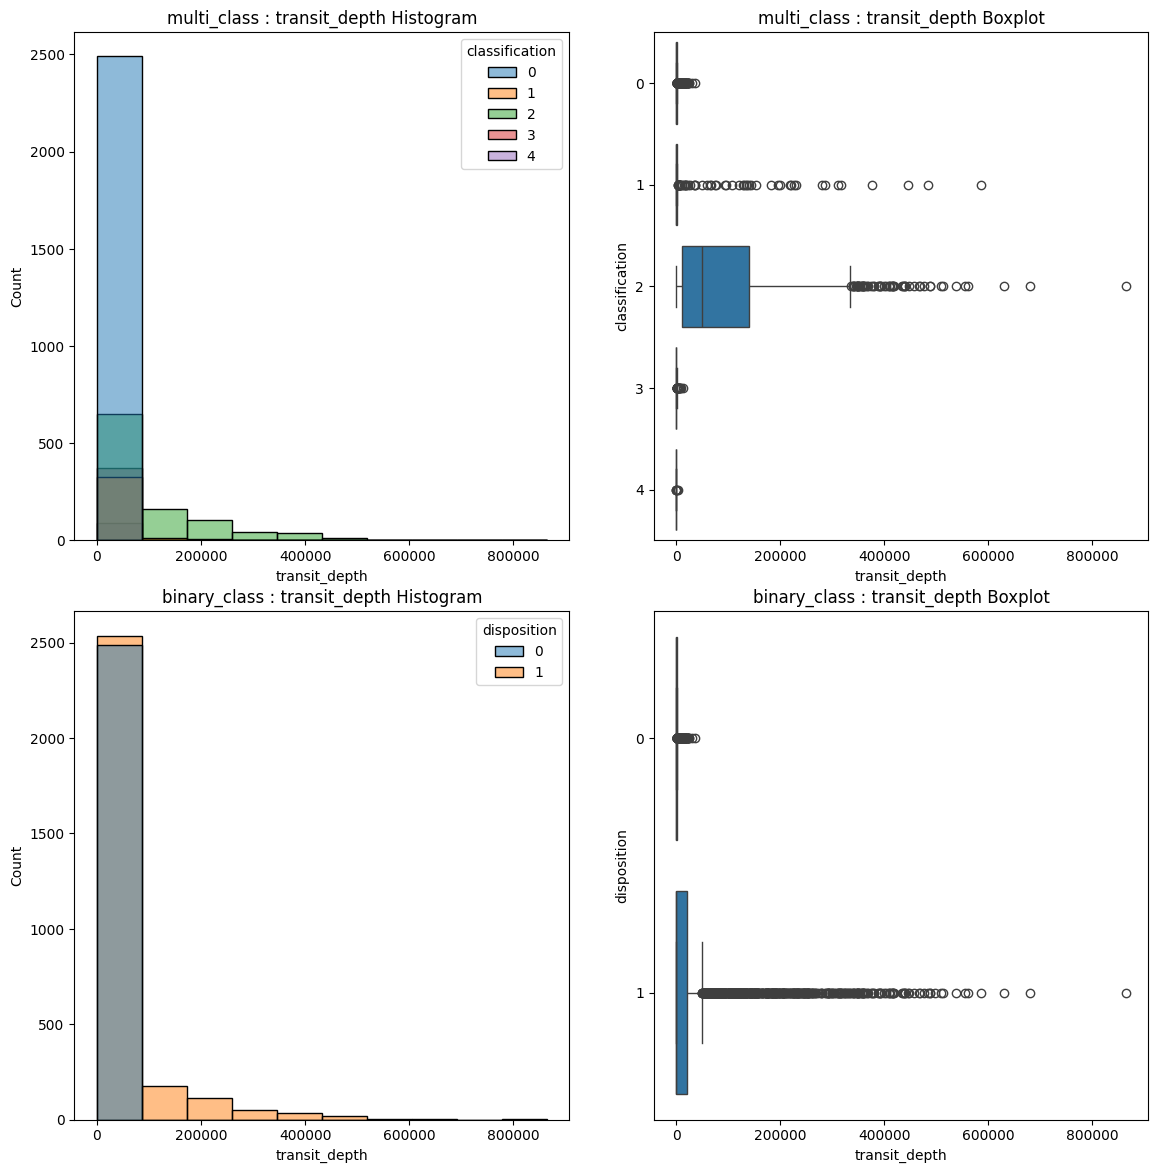

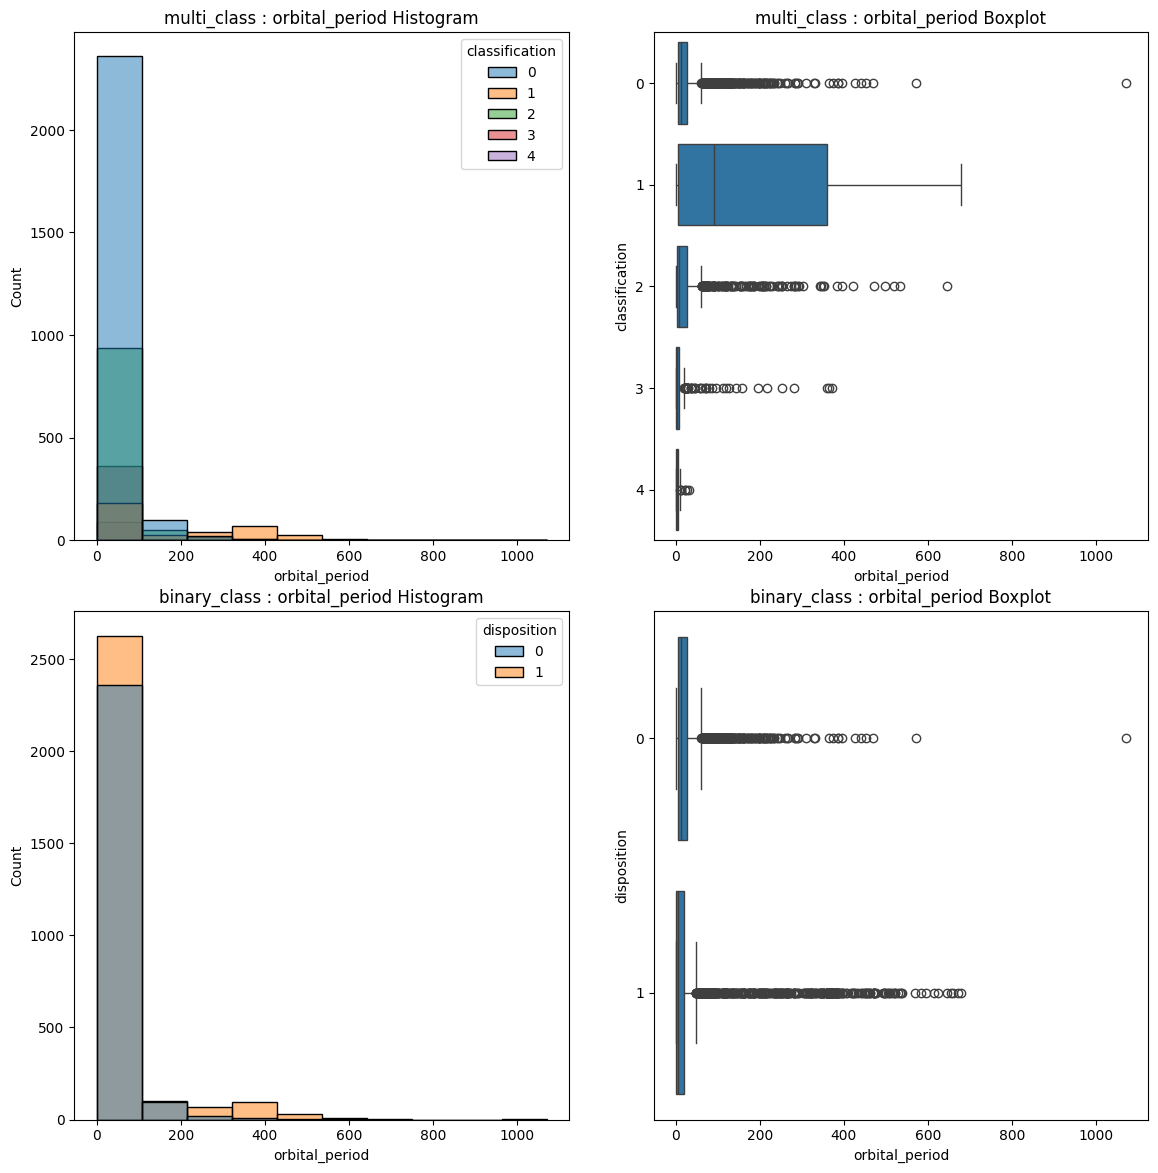

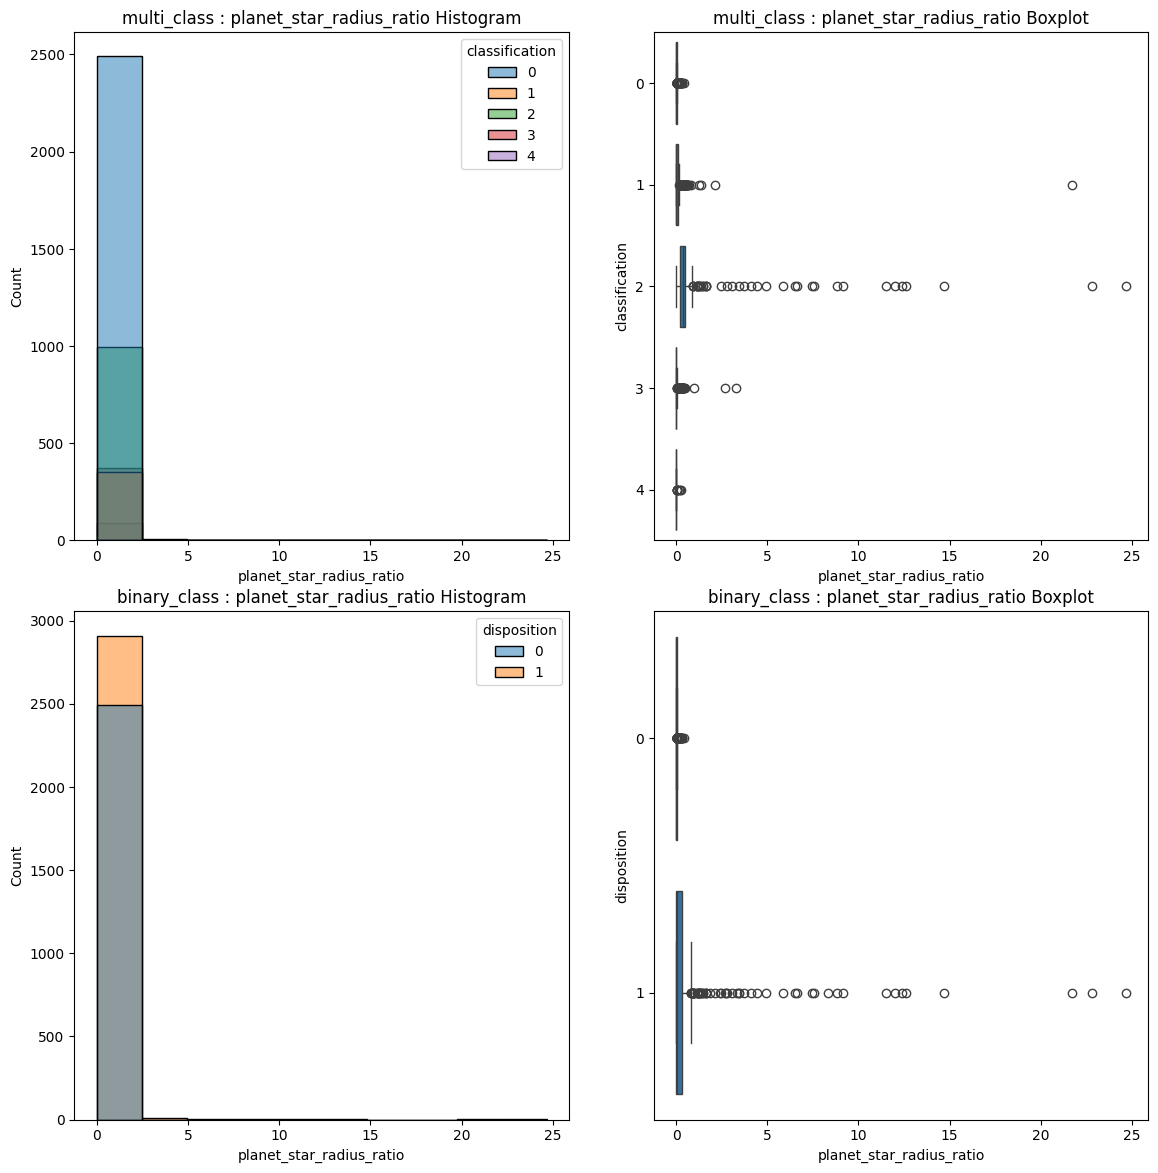

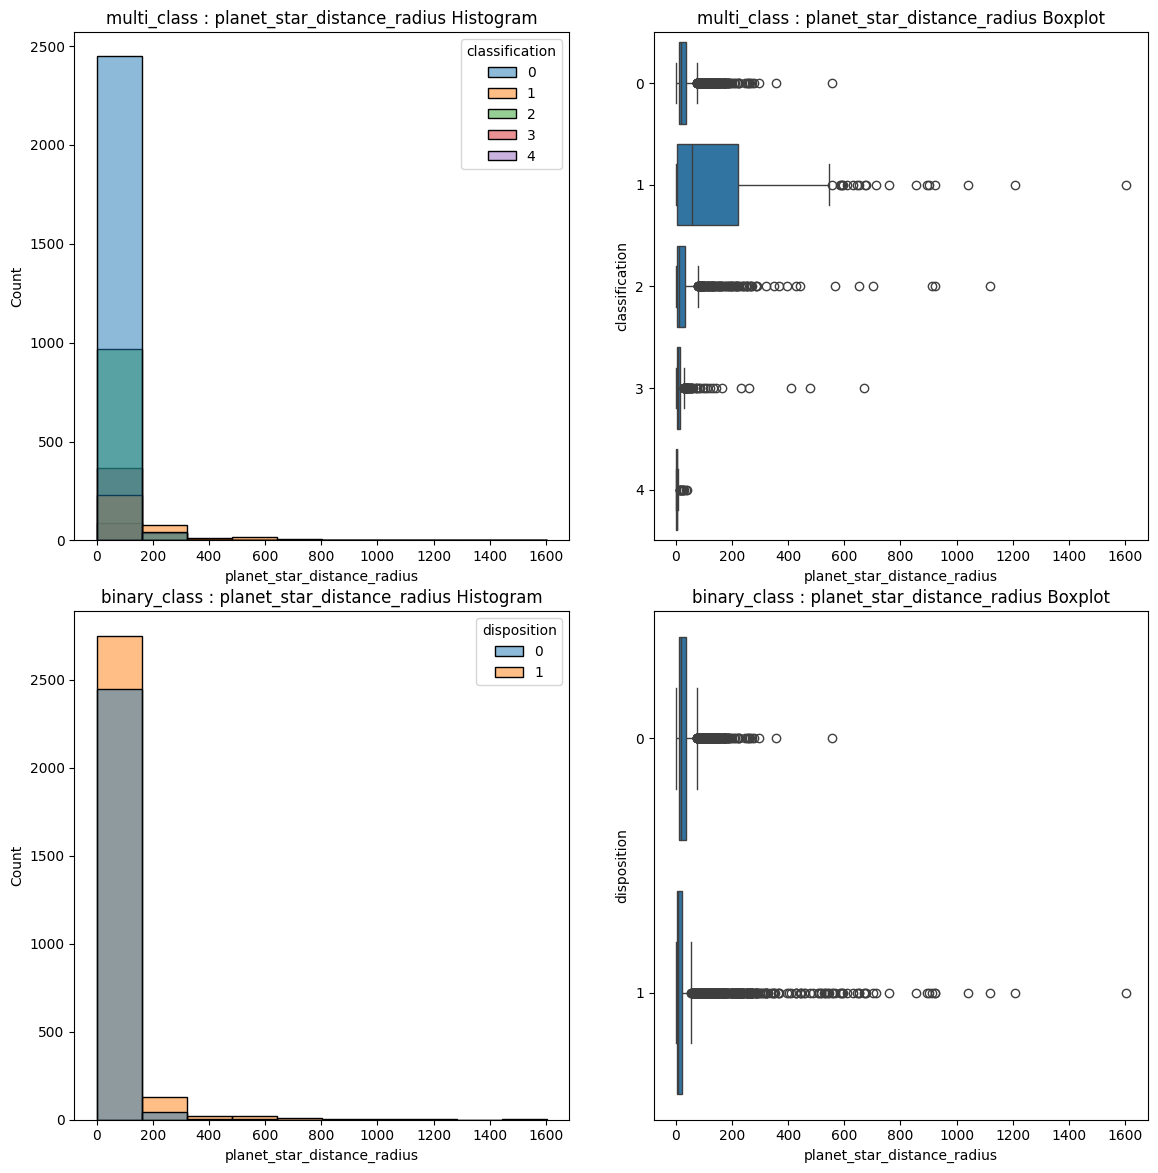

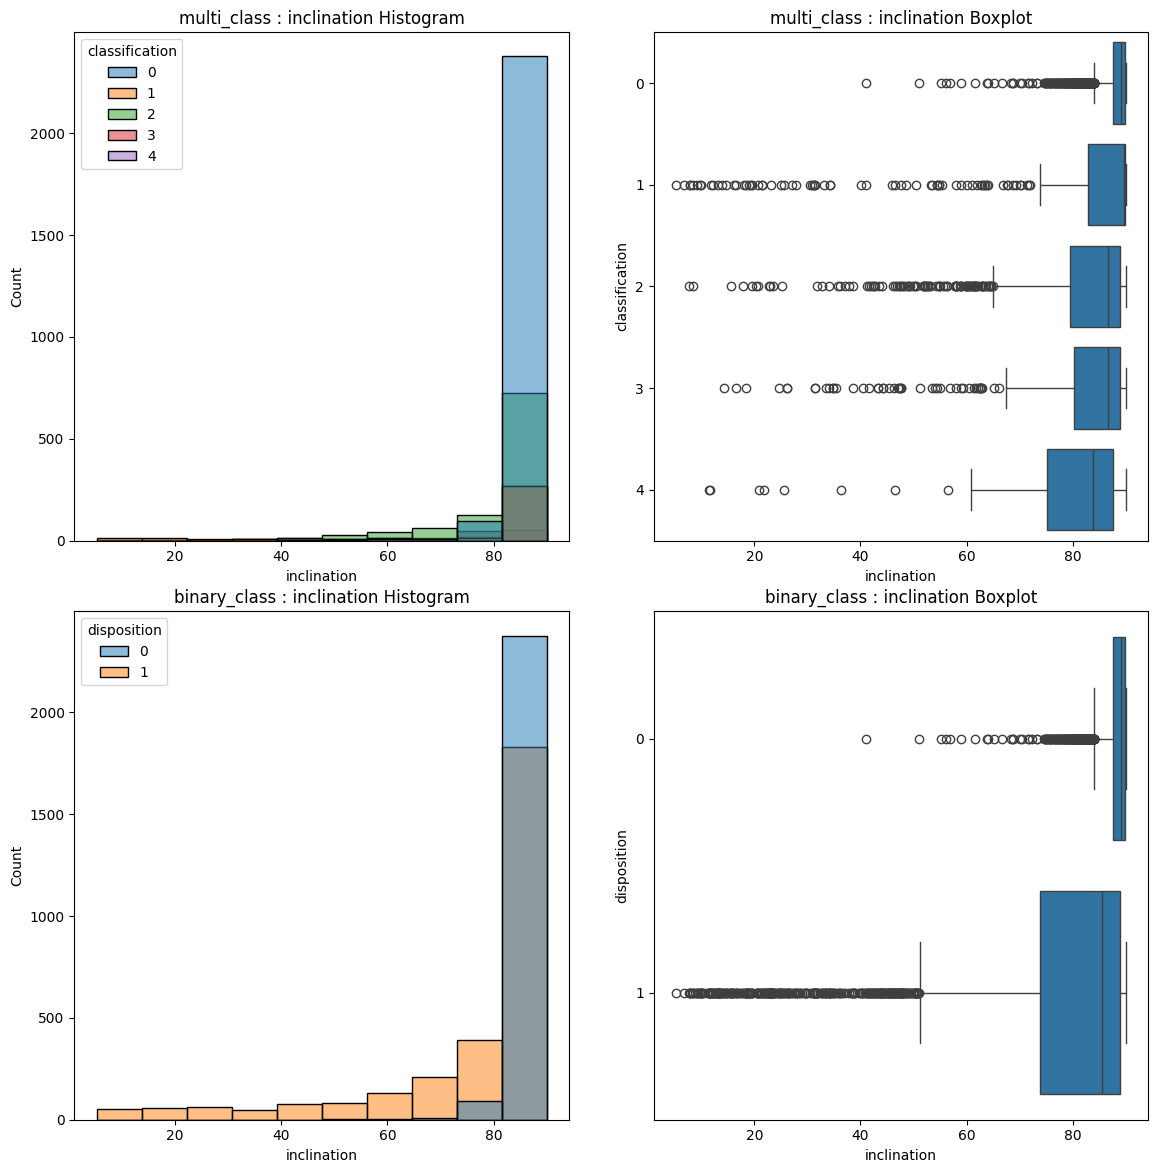

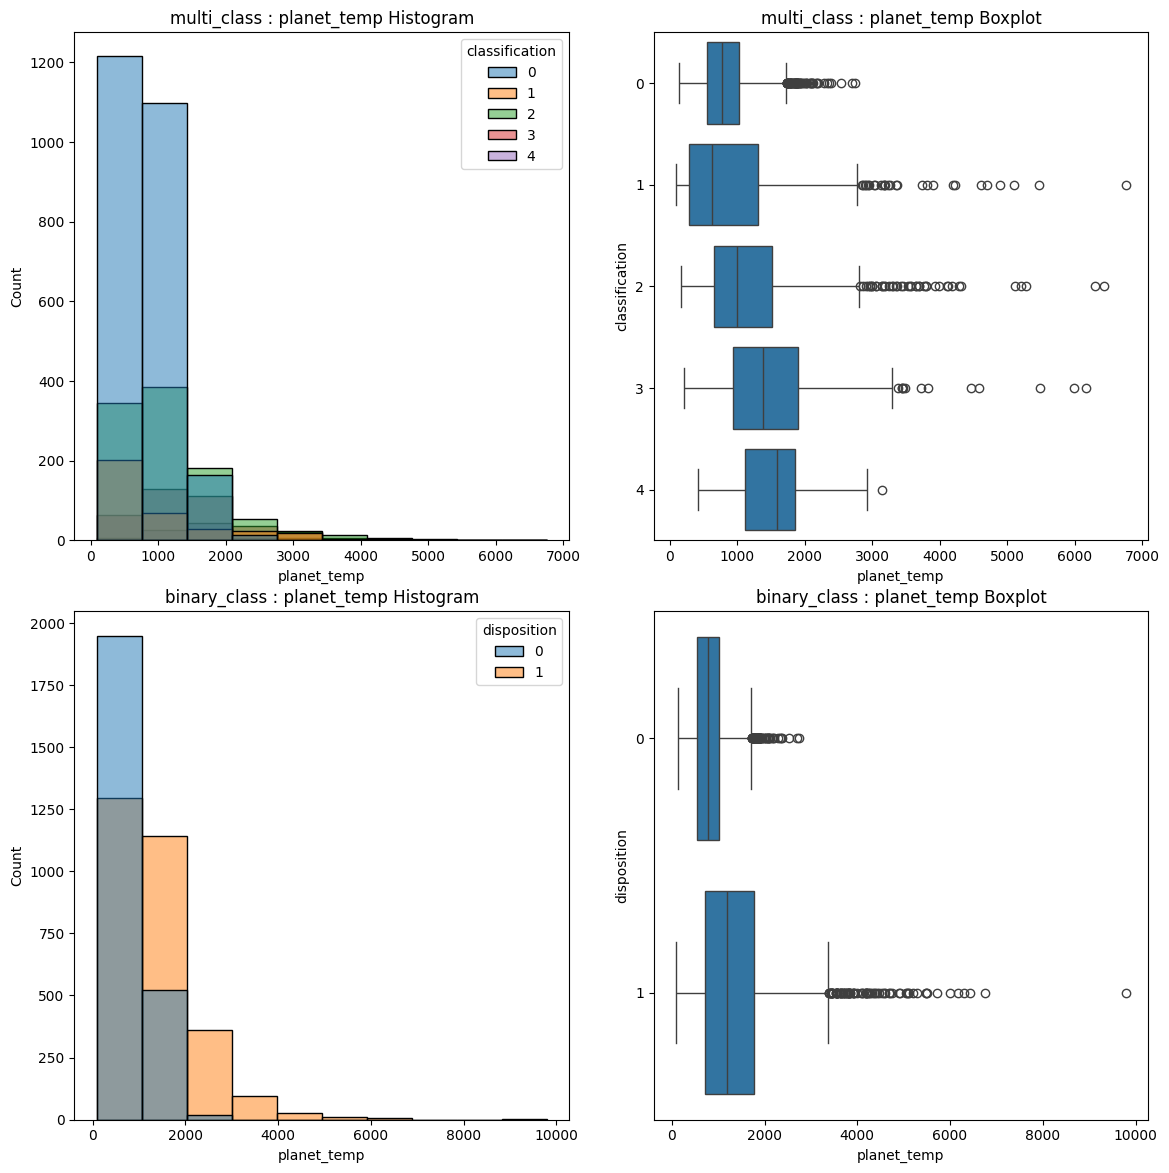

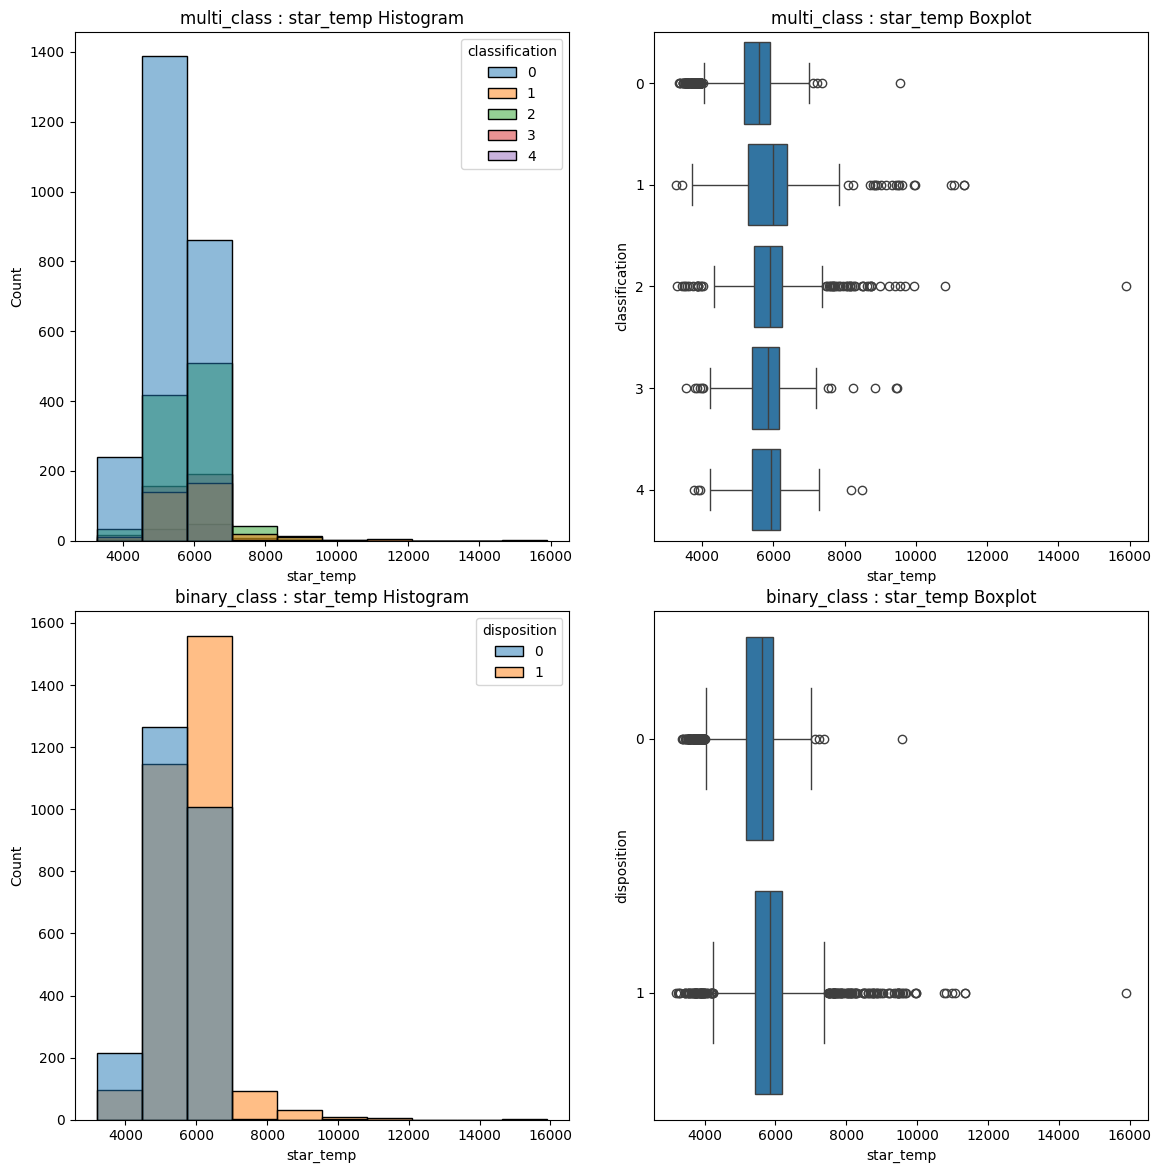

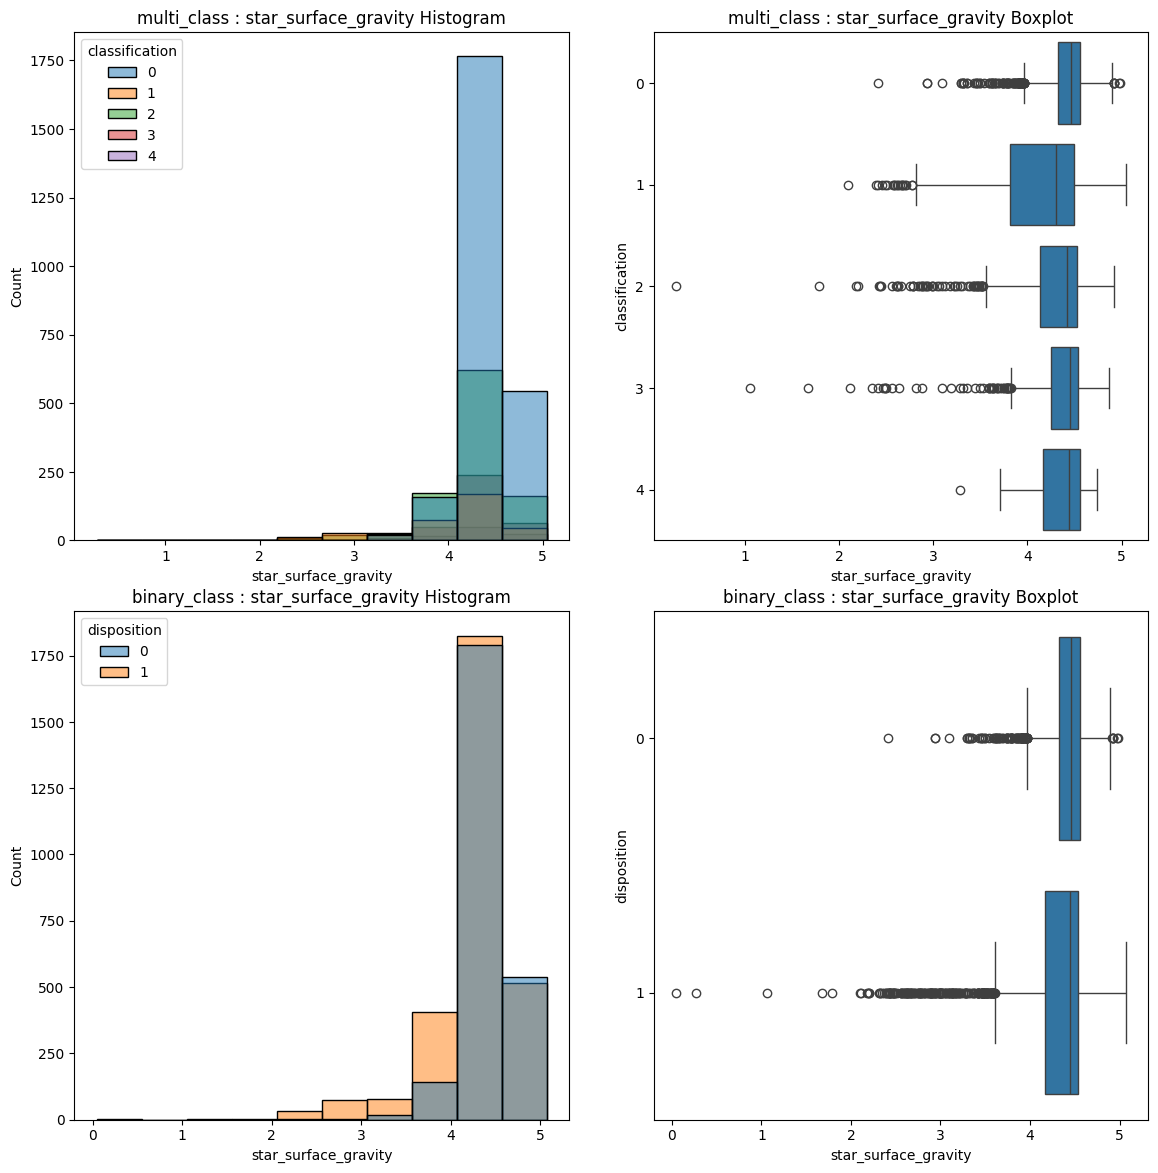

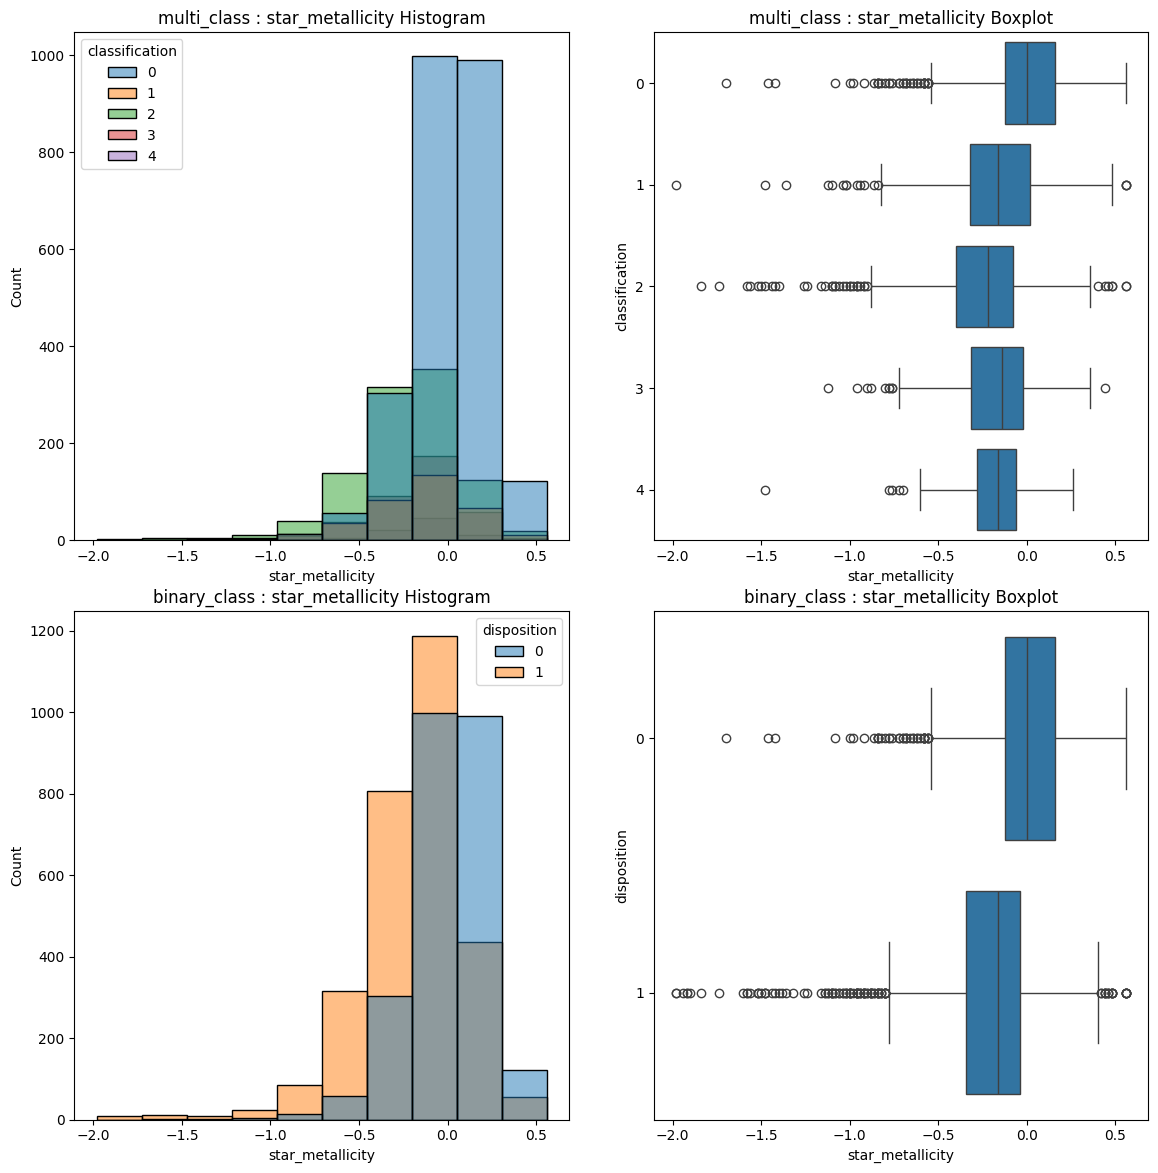

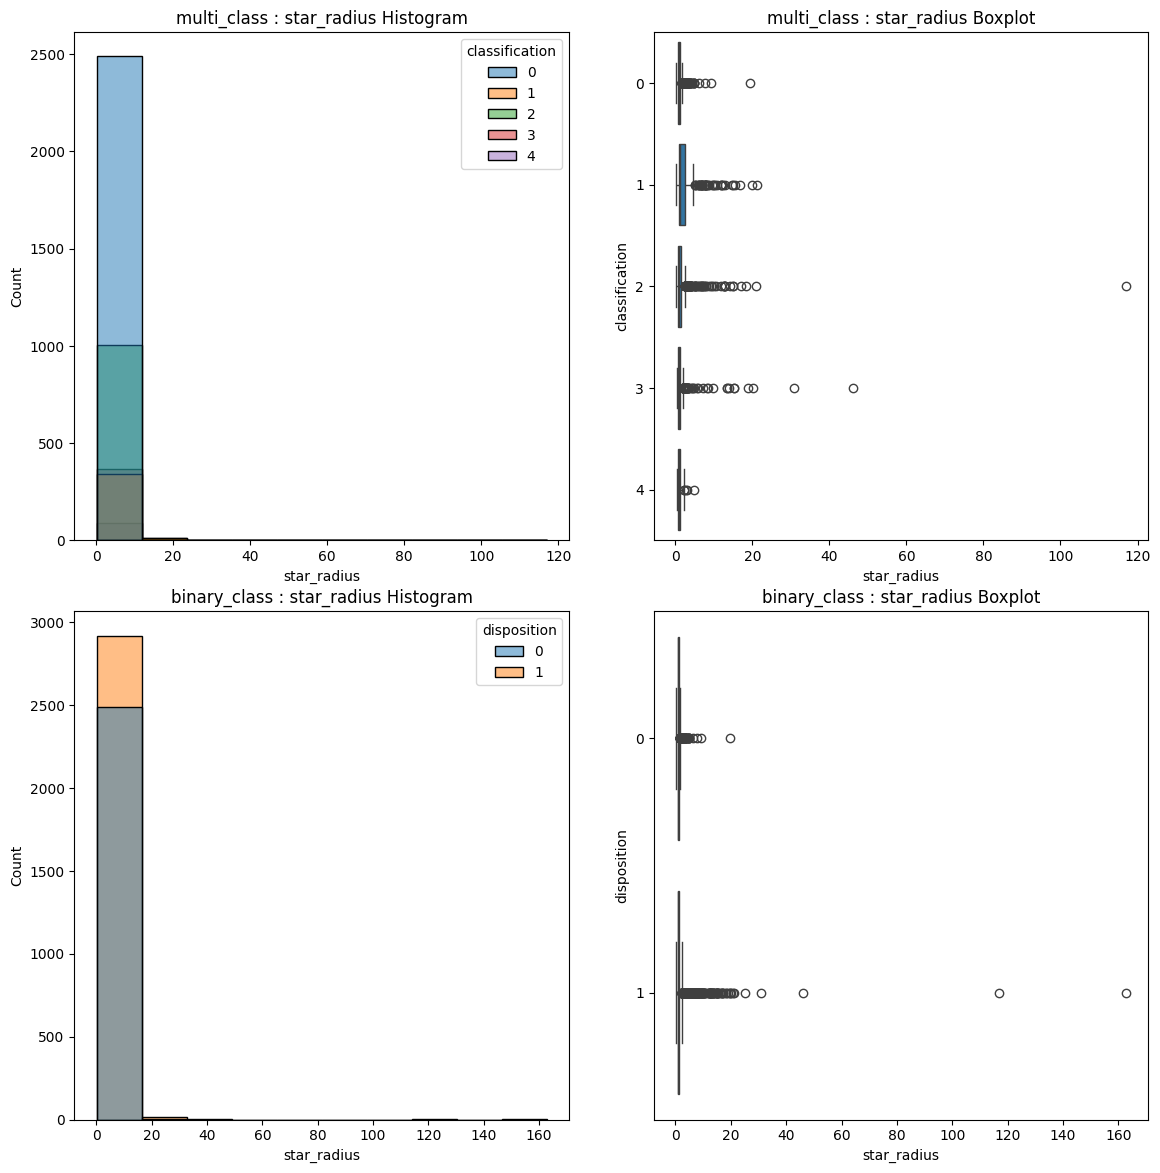

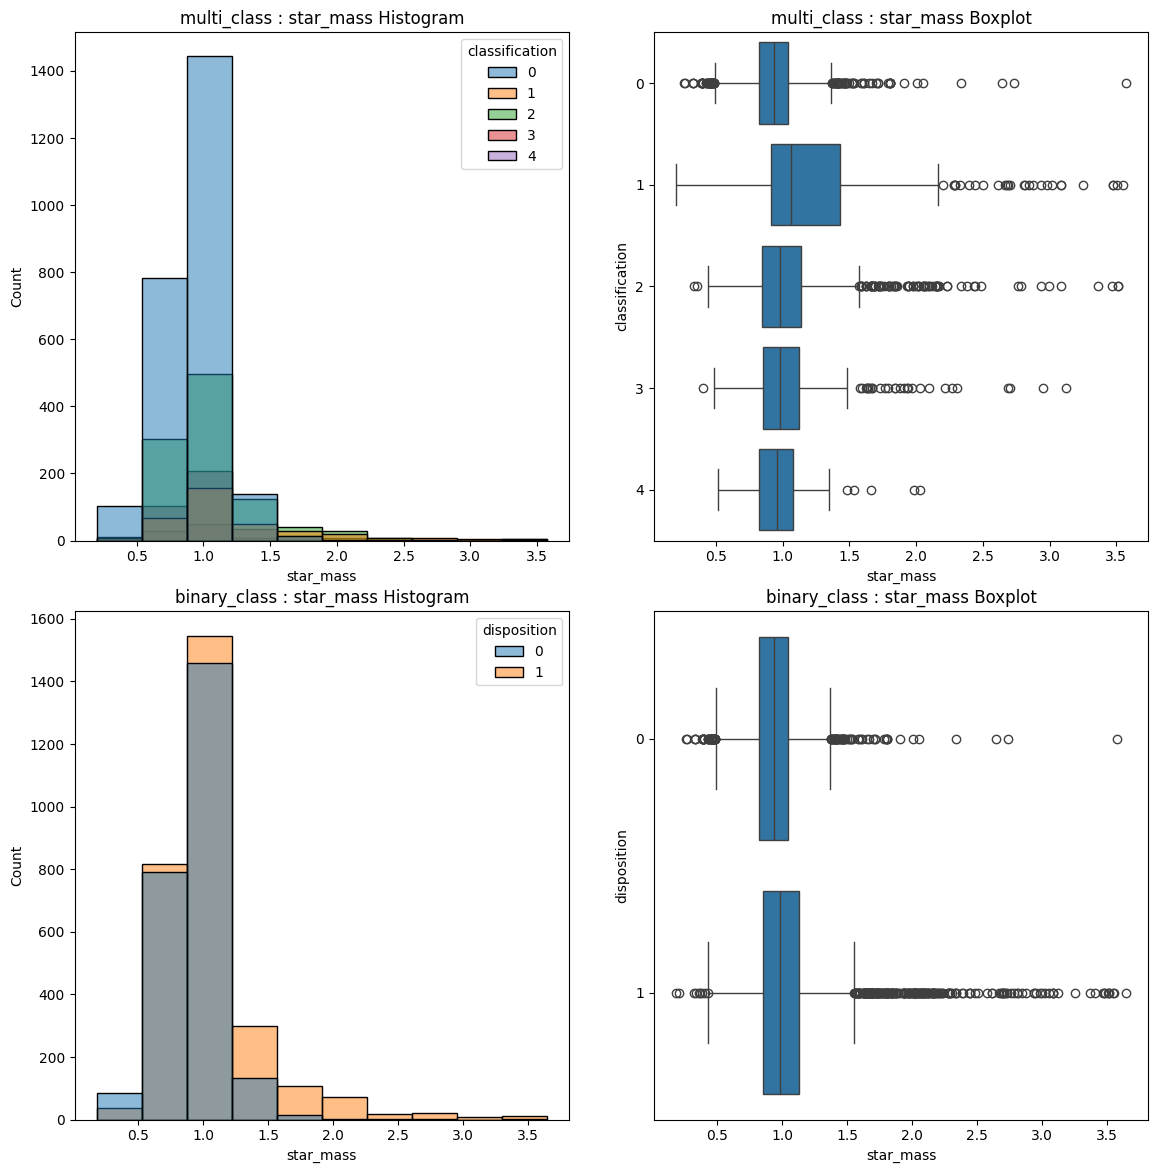

In [8]:
plt.close('all')
for column in numerical_columns[24:36]:
    plot_distributions([multi_class, binary_class], column, ['classification', 'disposition'],
                       kde = False, bins = 10)

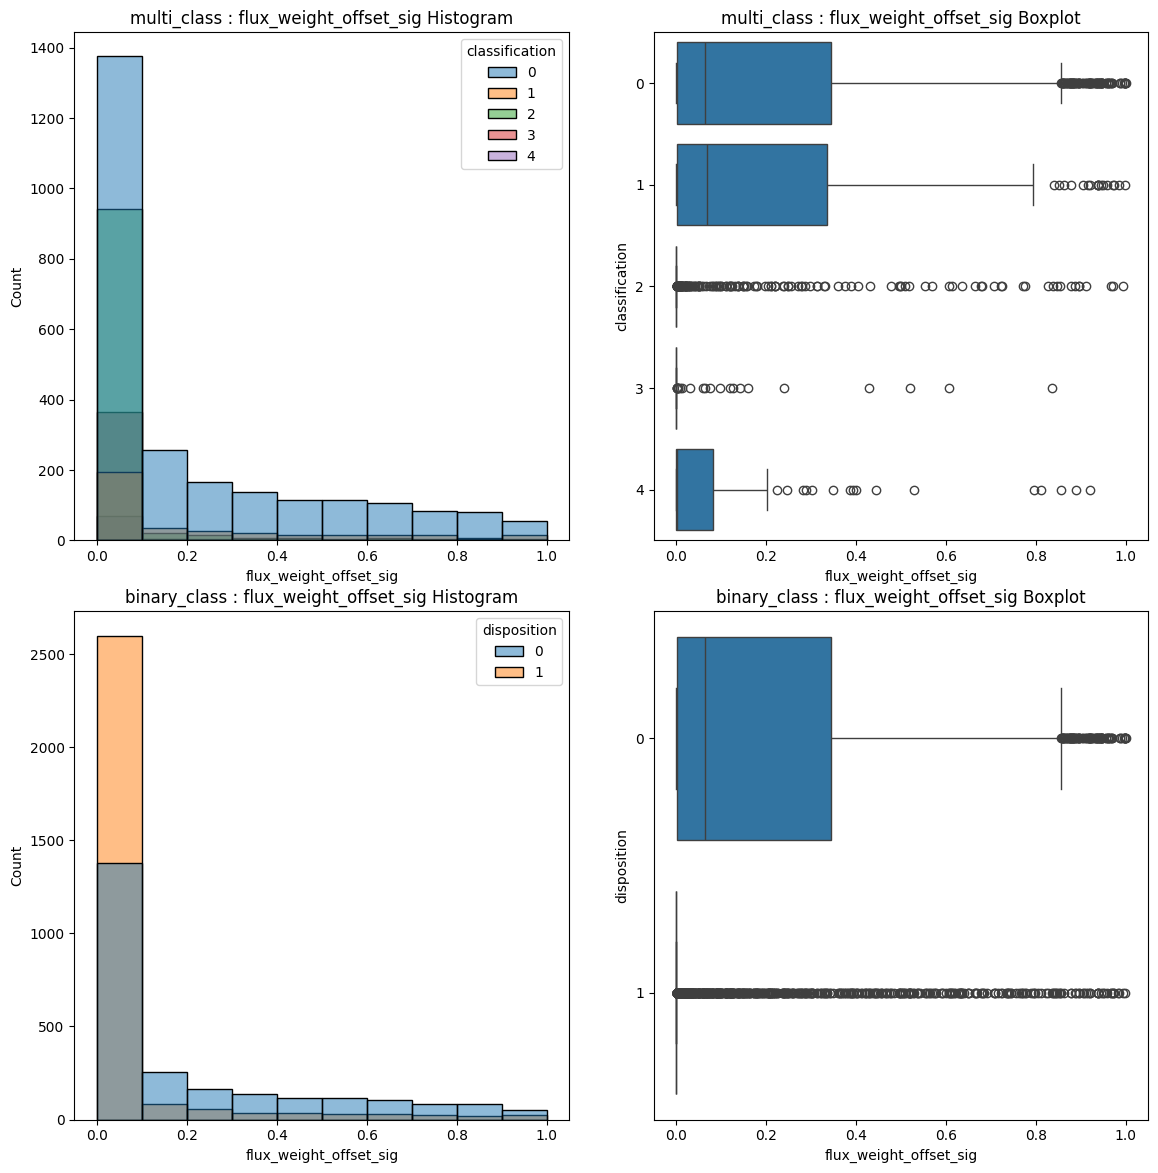

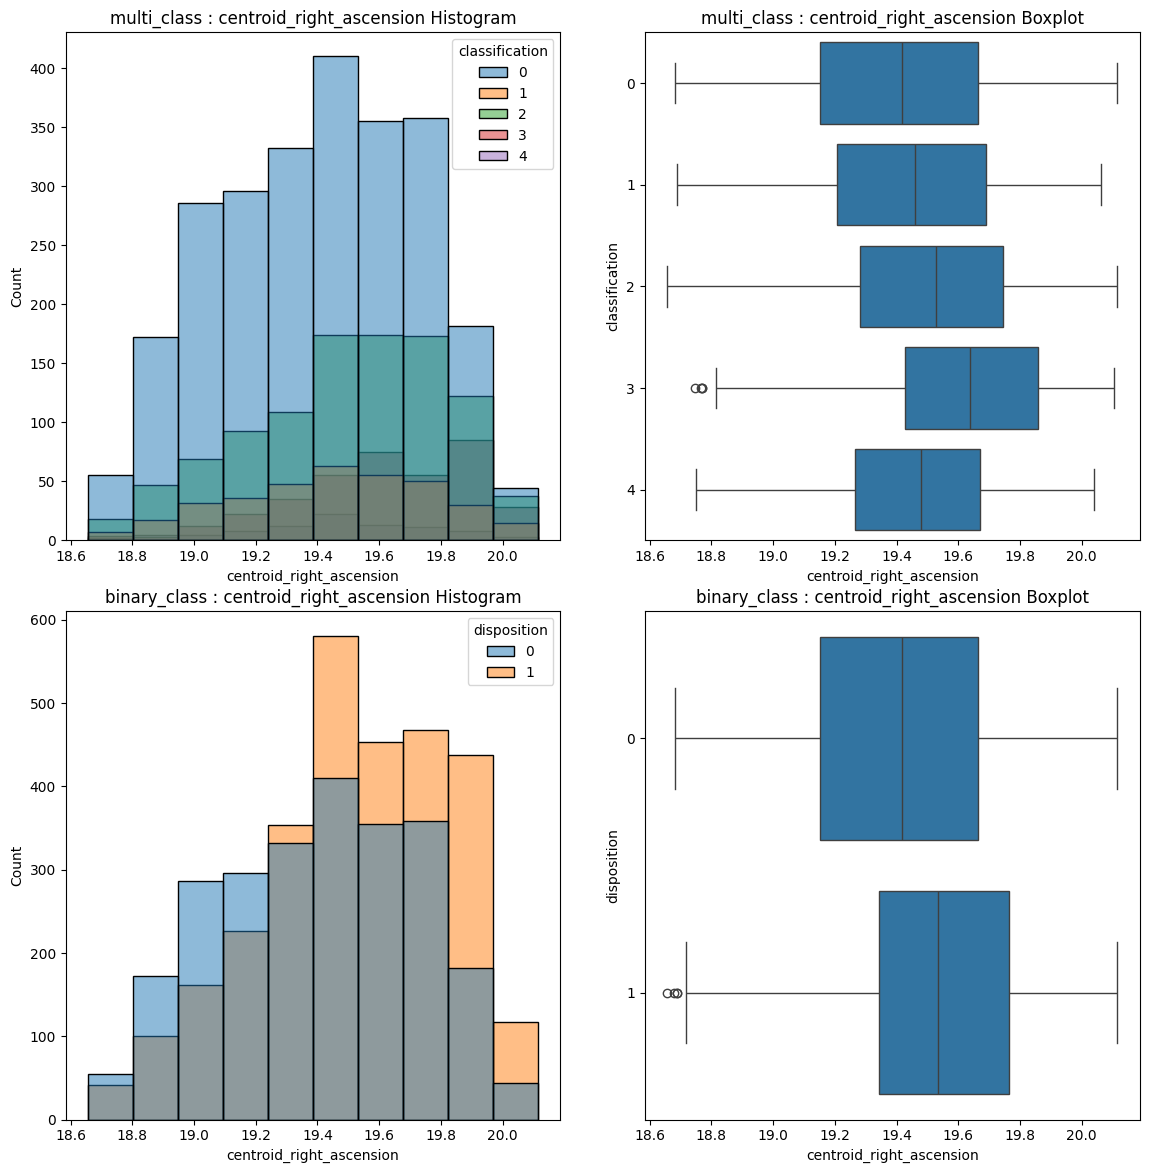

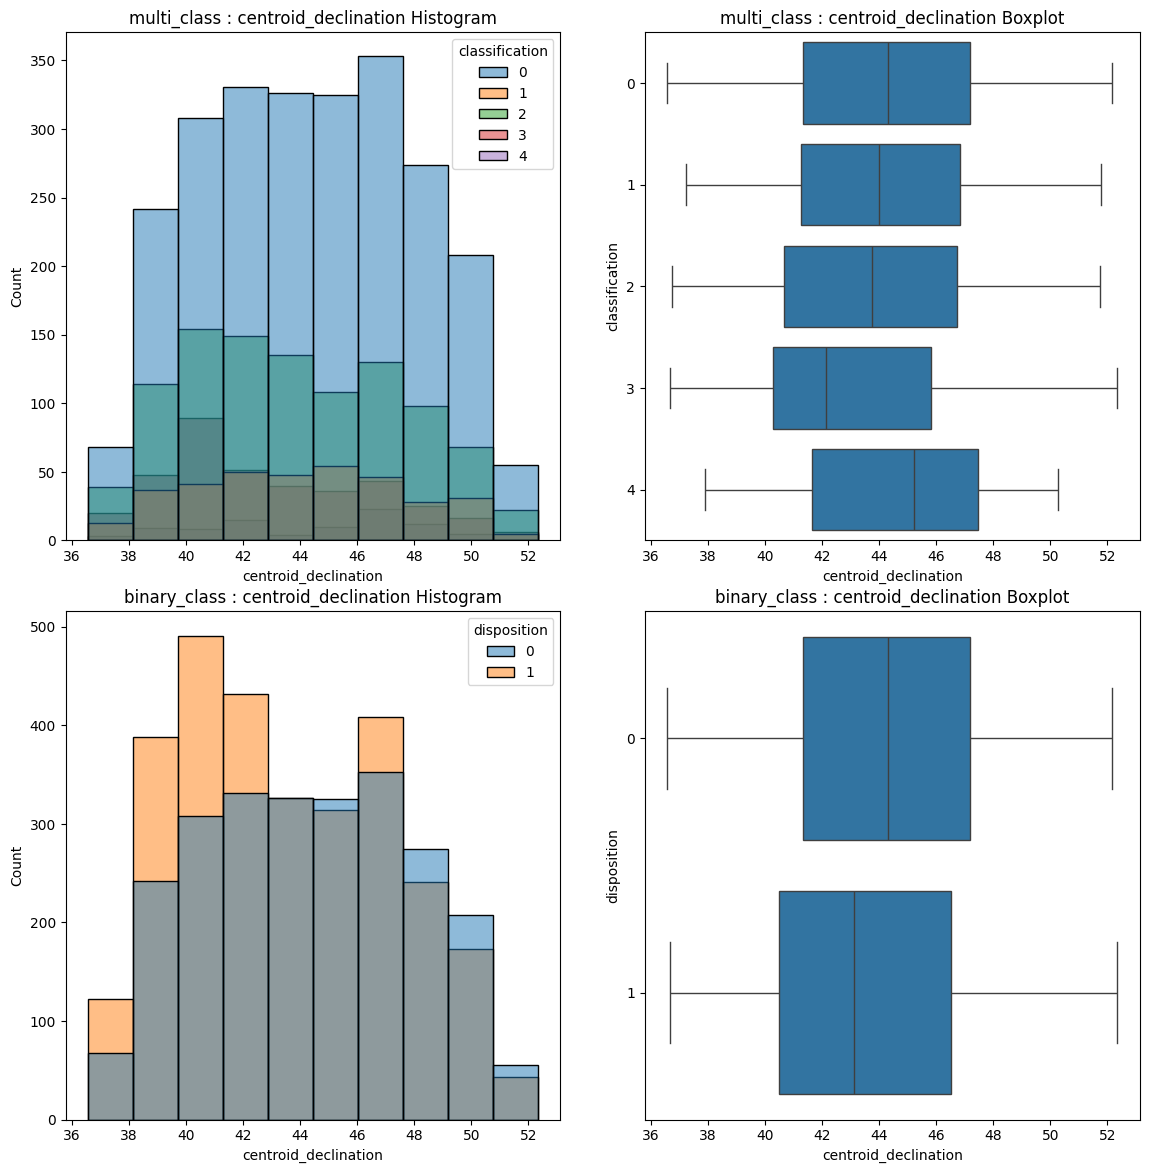

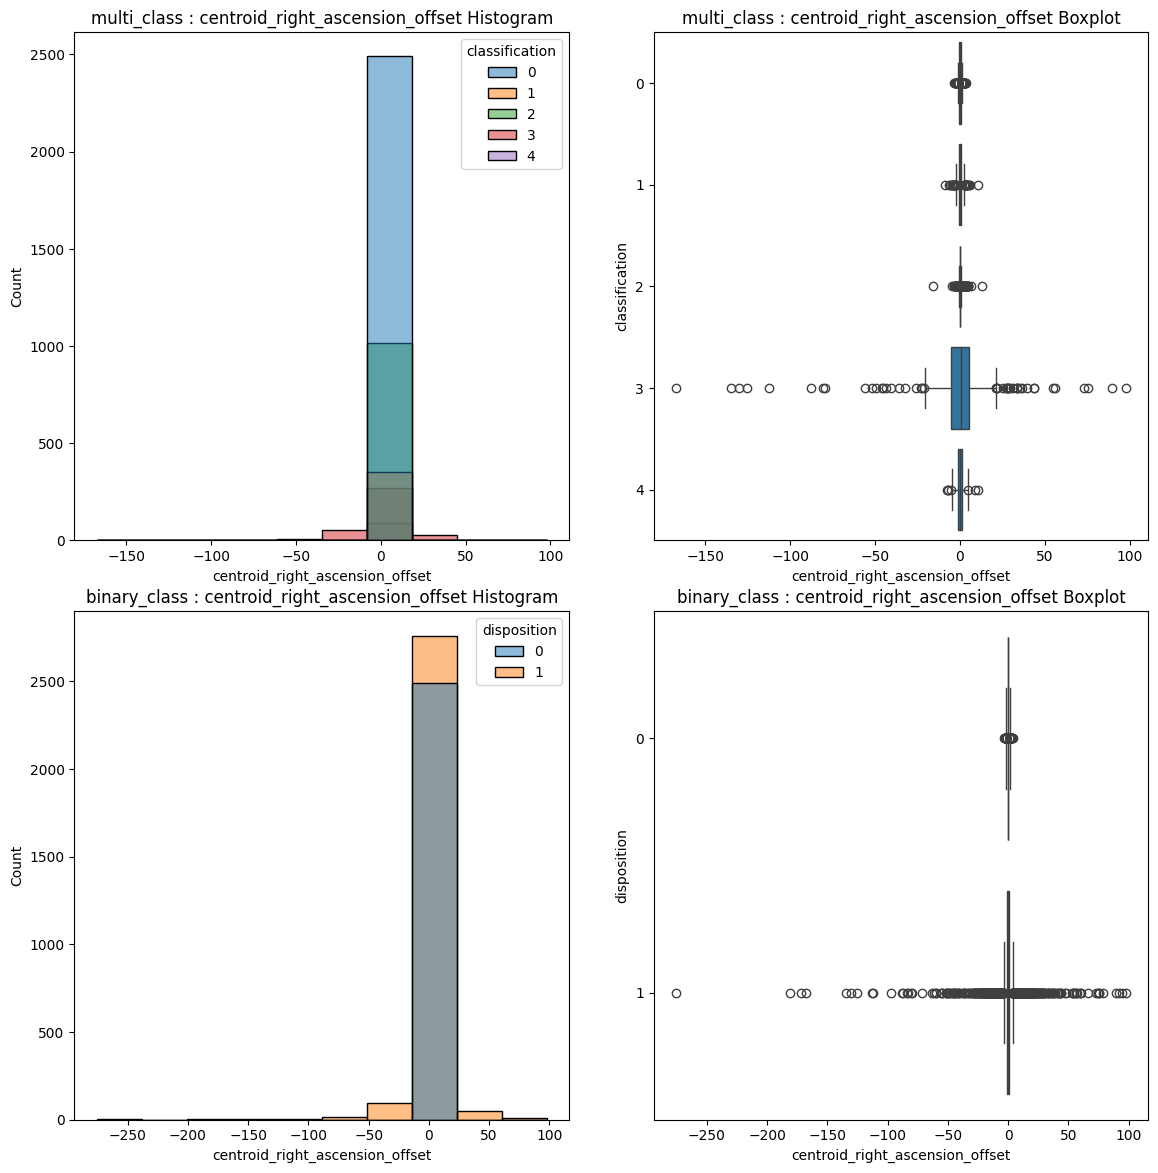

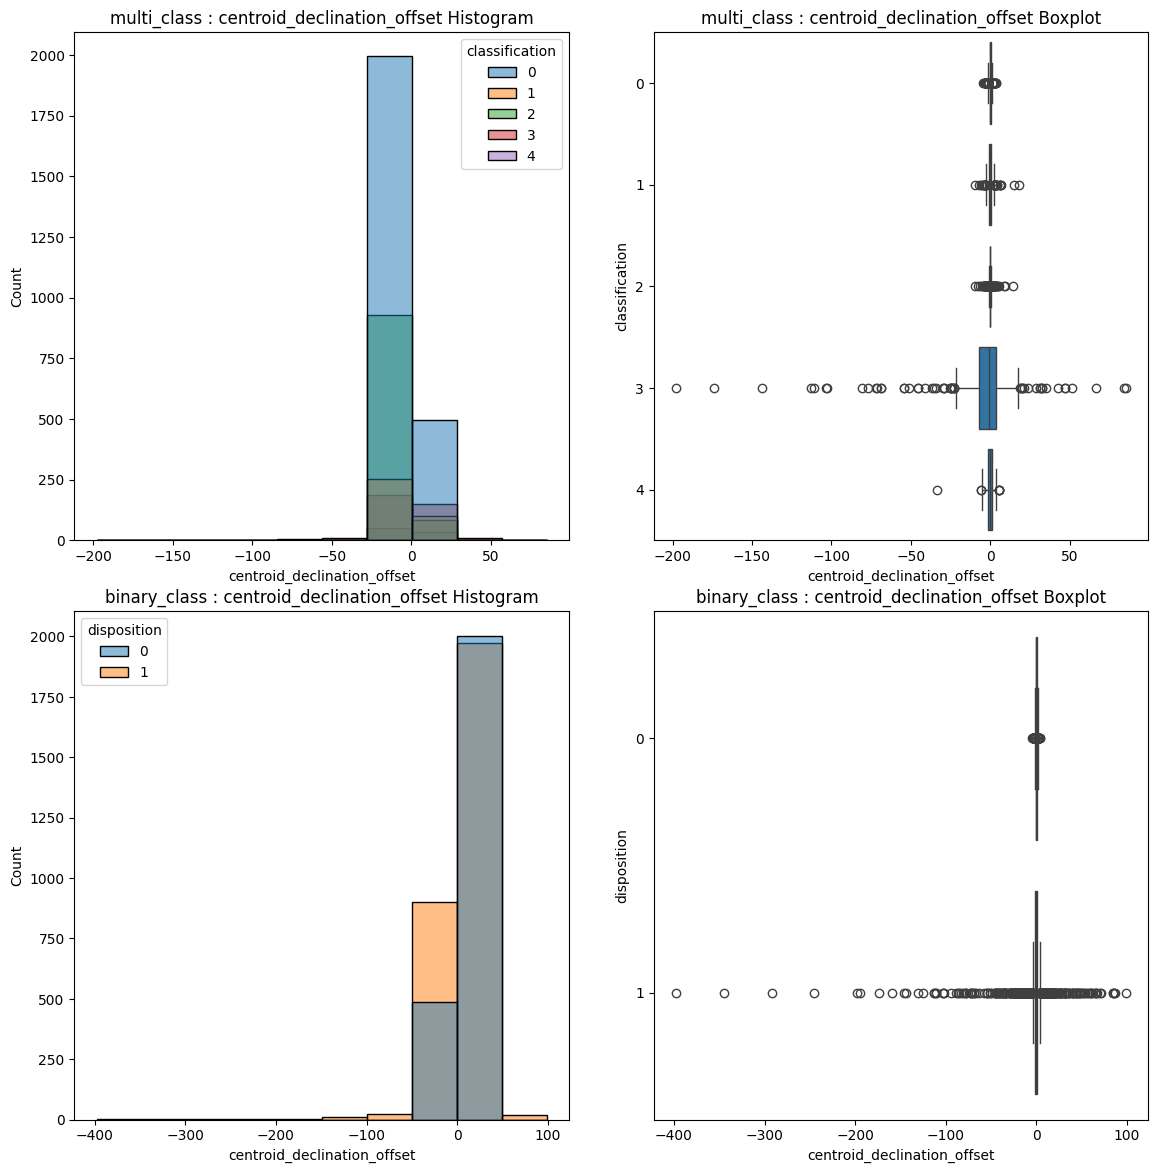

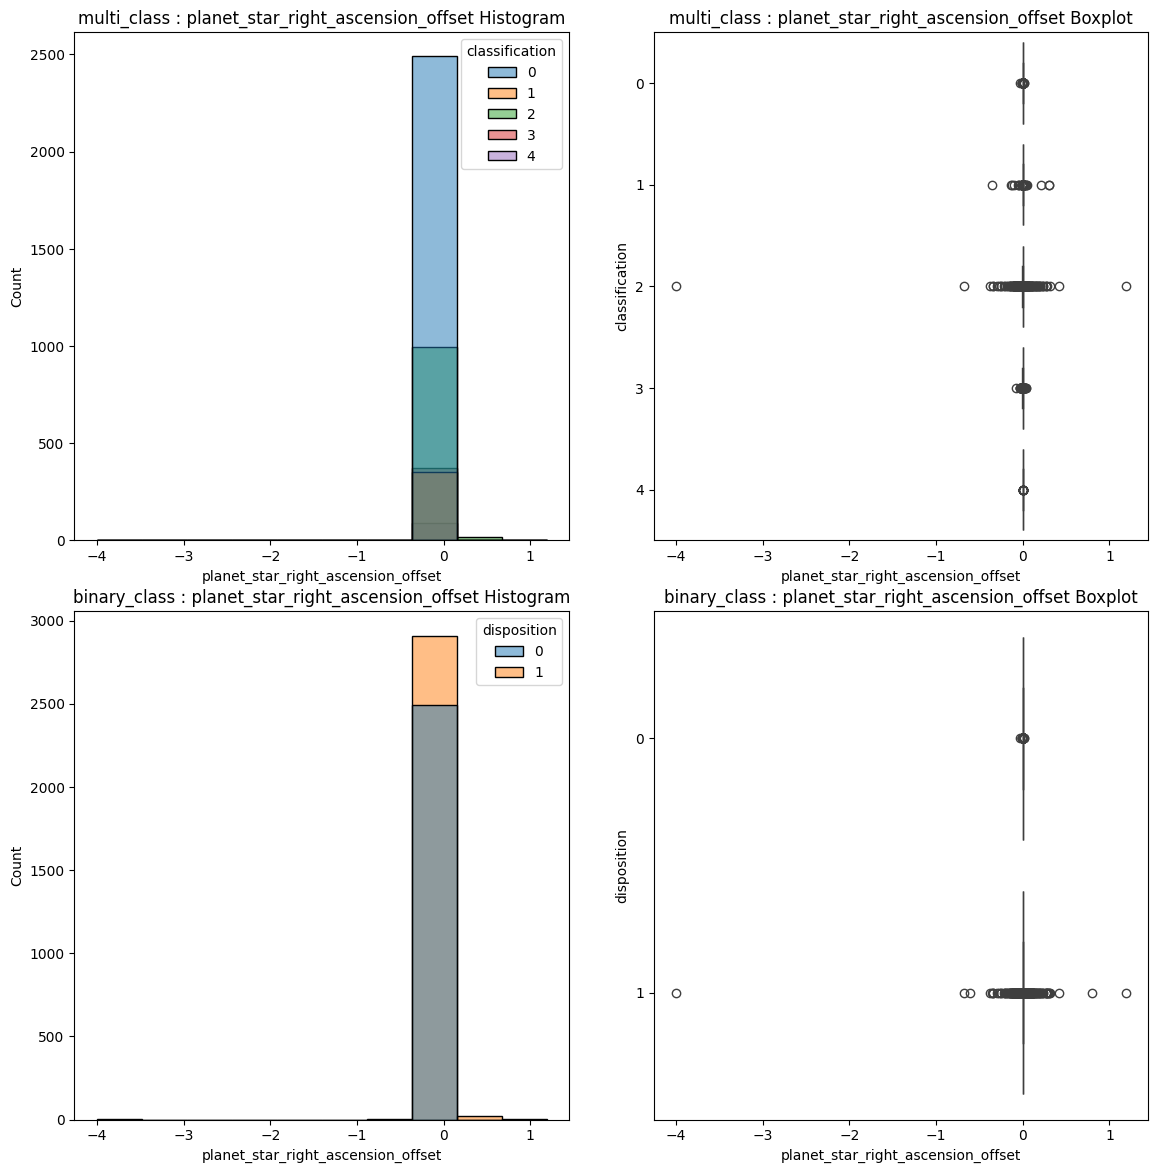

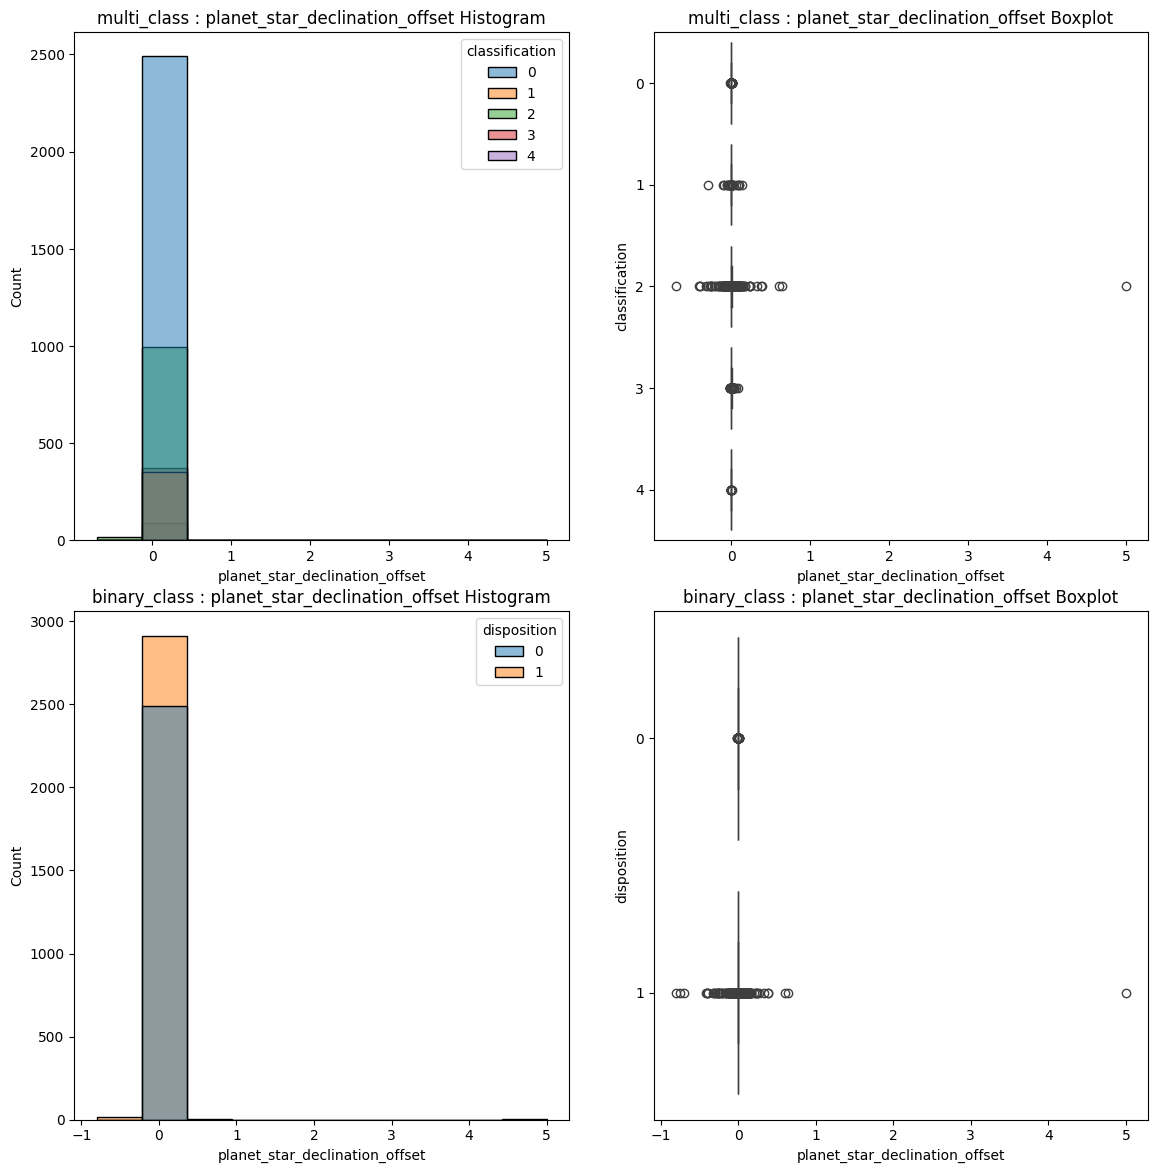

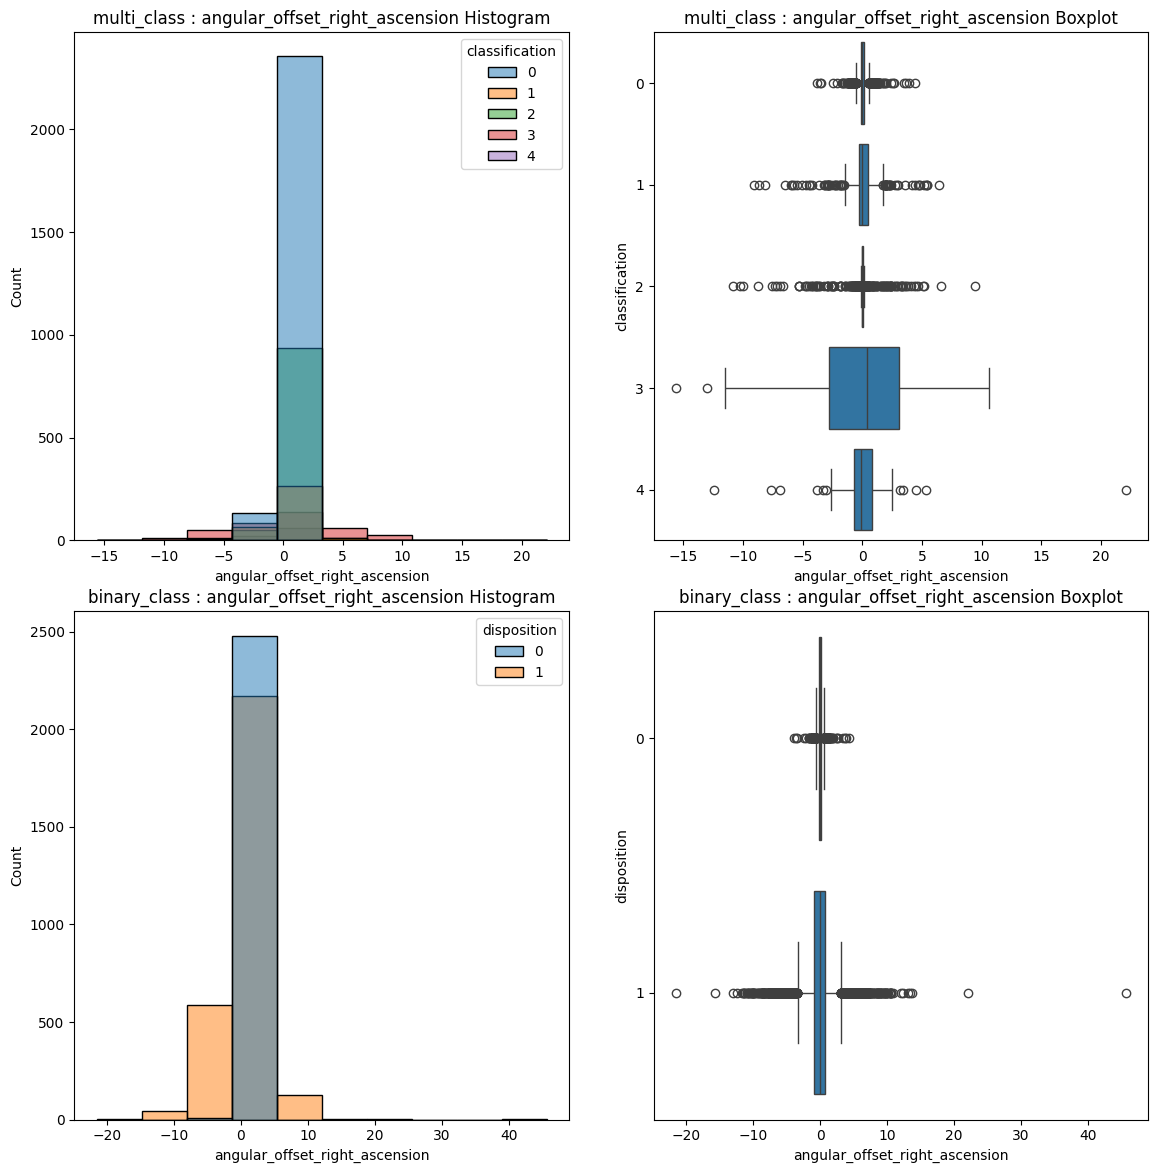

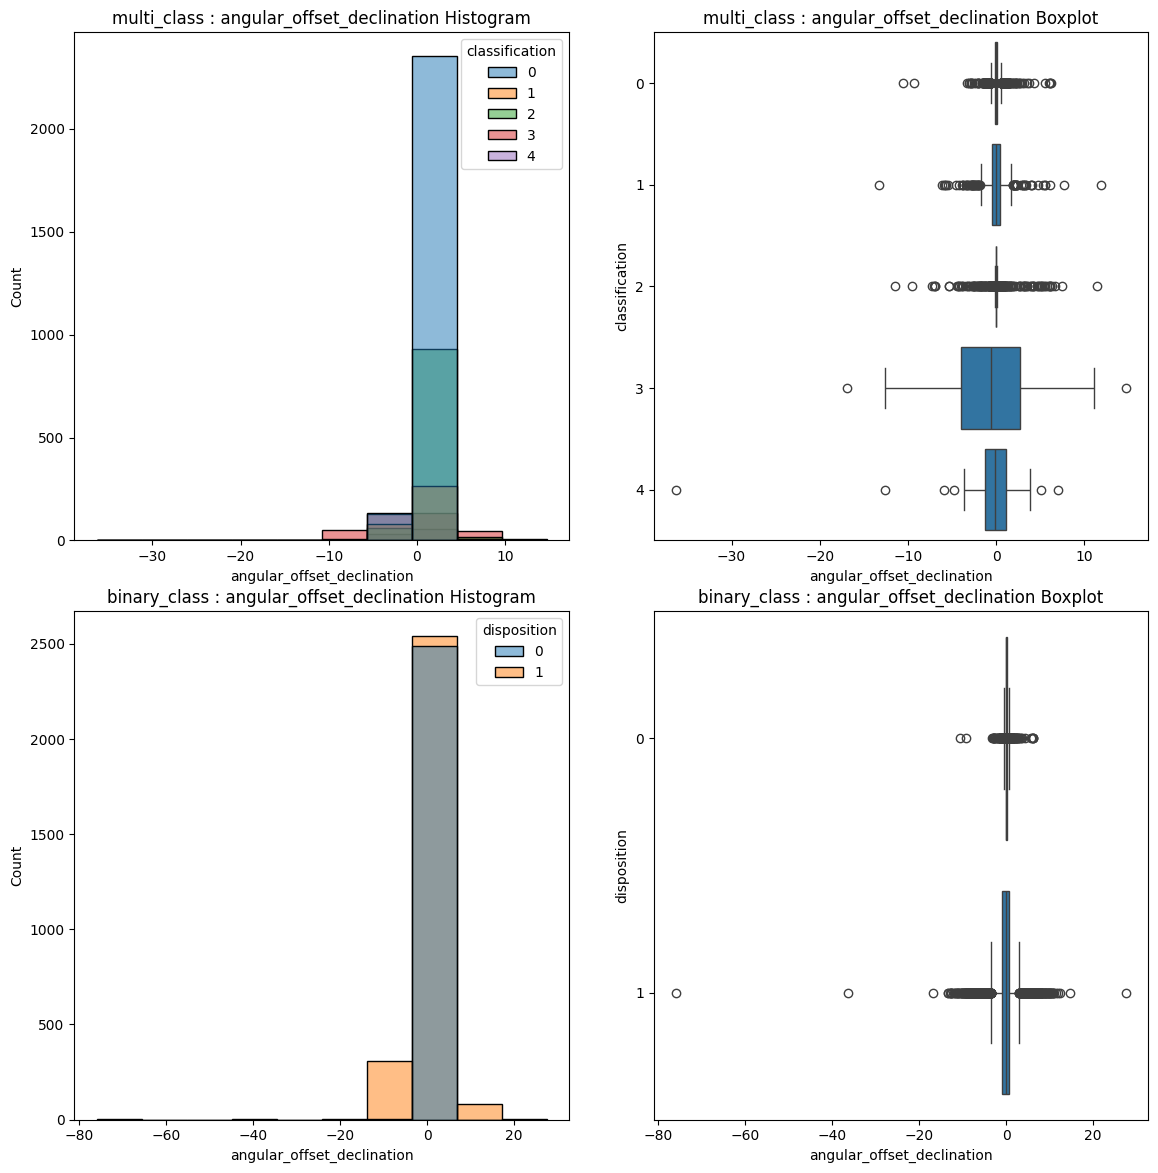

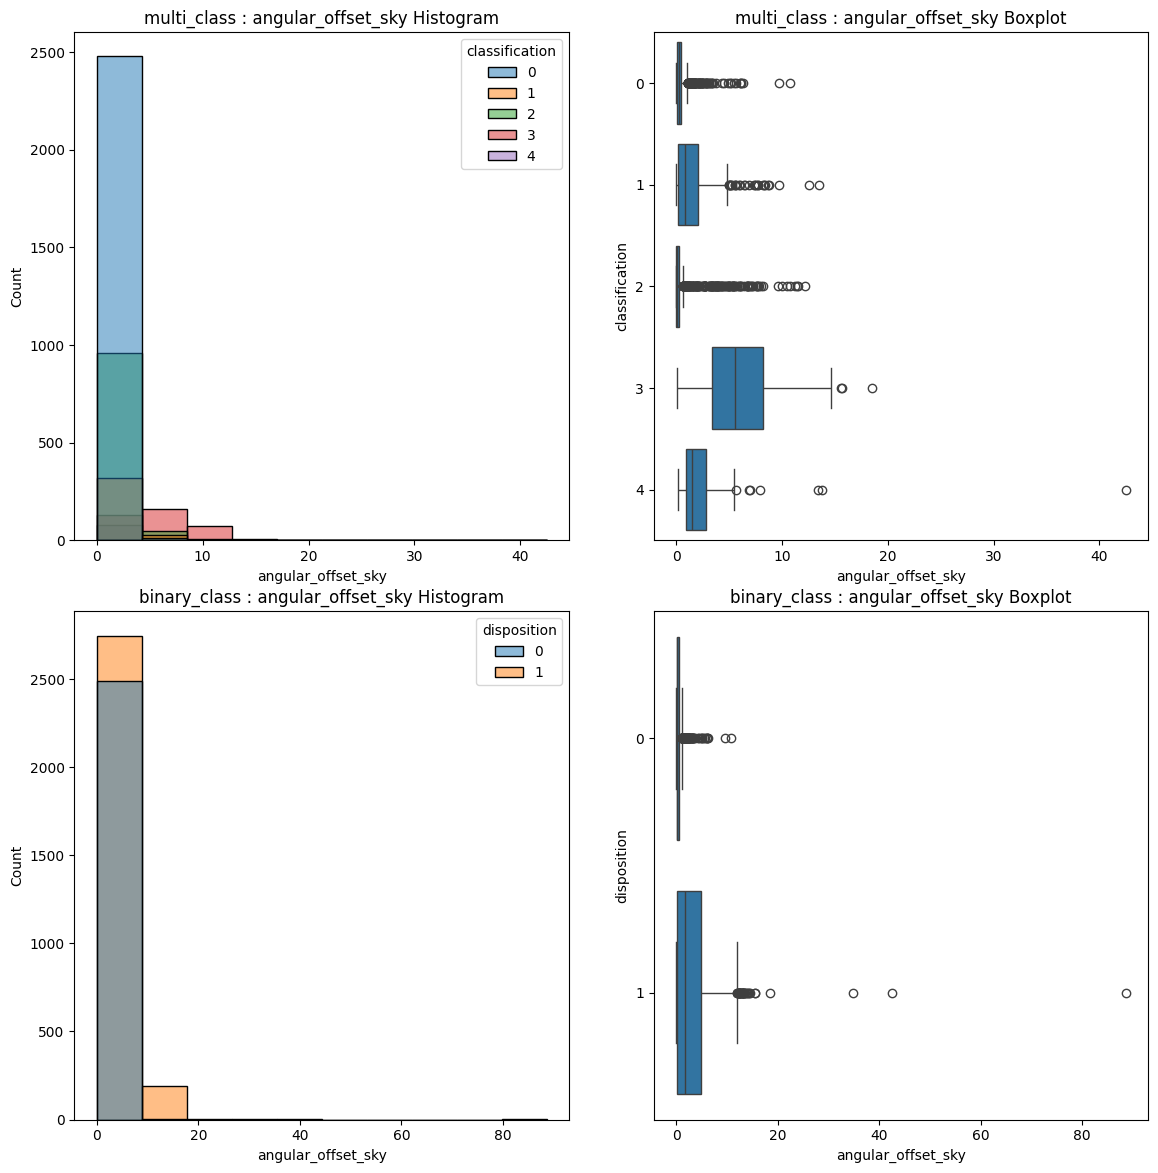

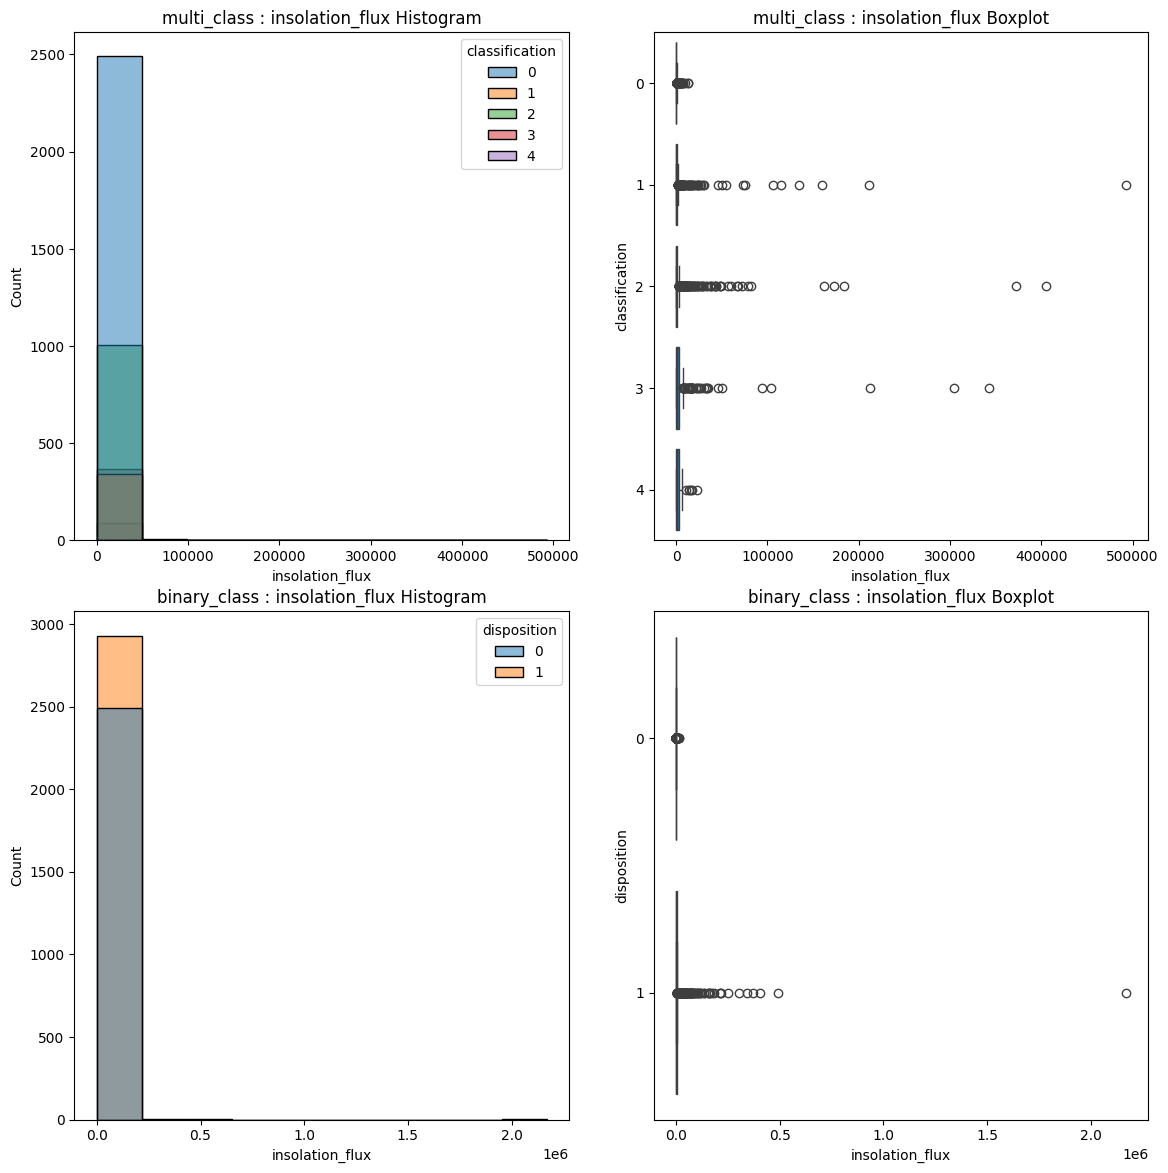

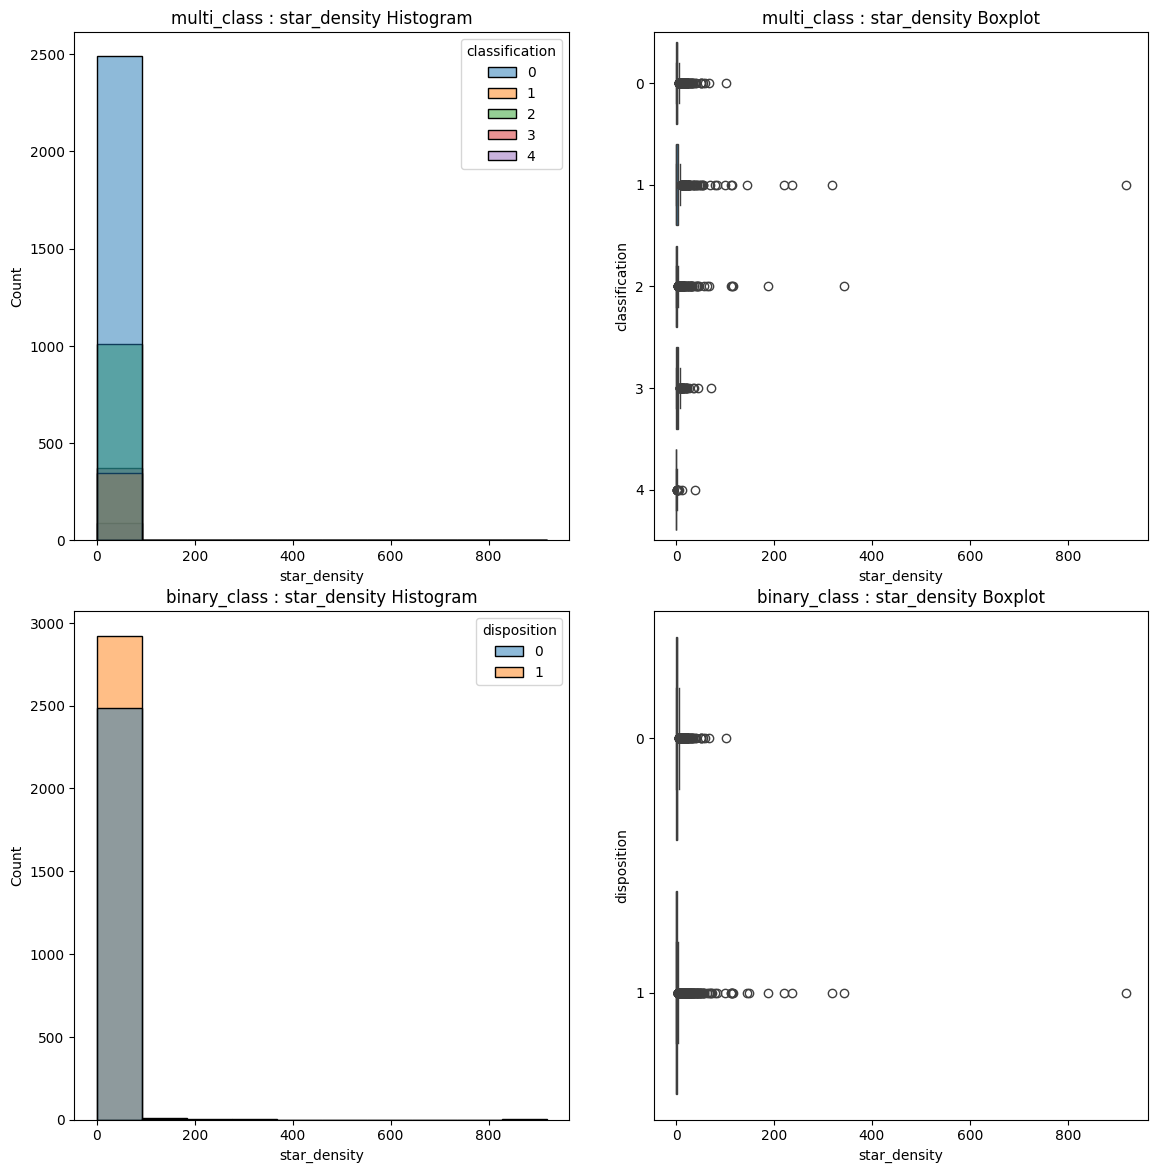

In [9]:
plt.close('all')
for column in numerical_columns[36:]:
    plot_distributions([multi_class, binary_class], column, ['classification', 'disposition'],
                       kde = False, bins = 10)

# Feature Engineering

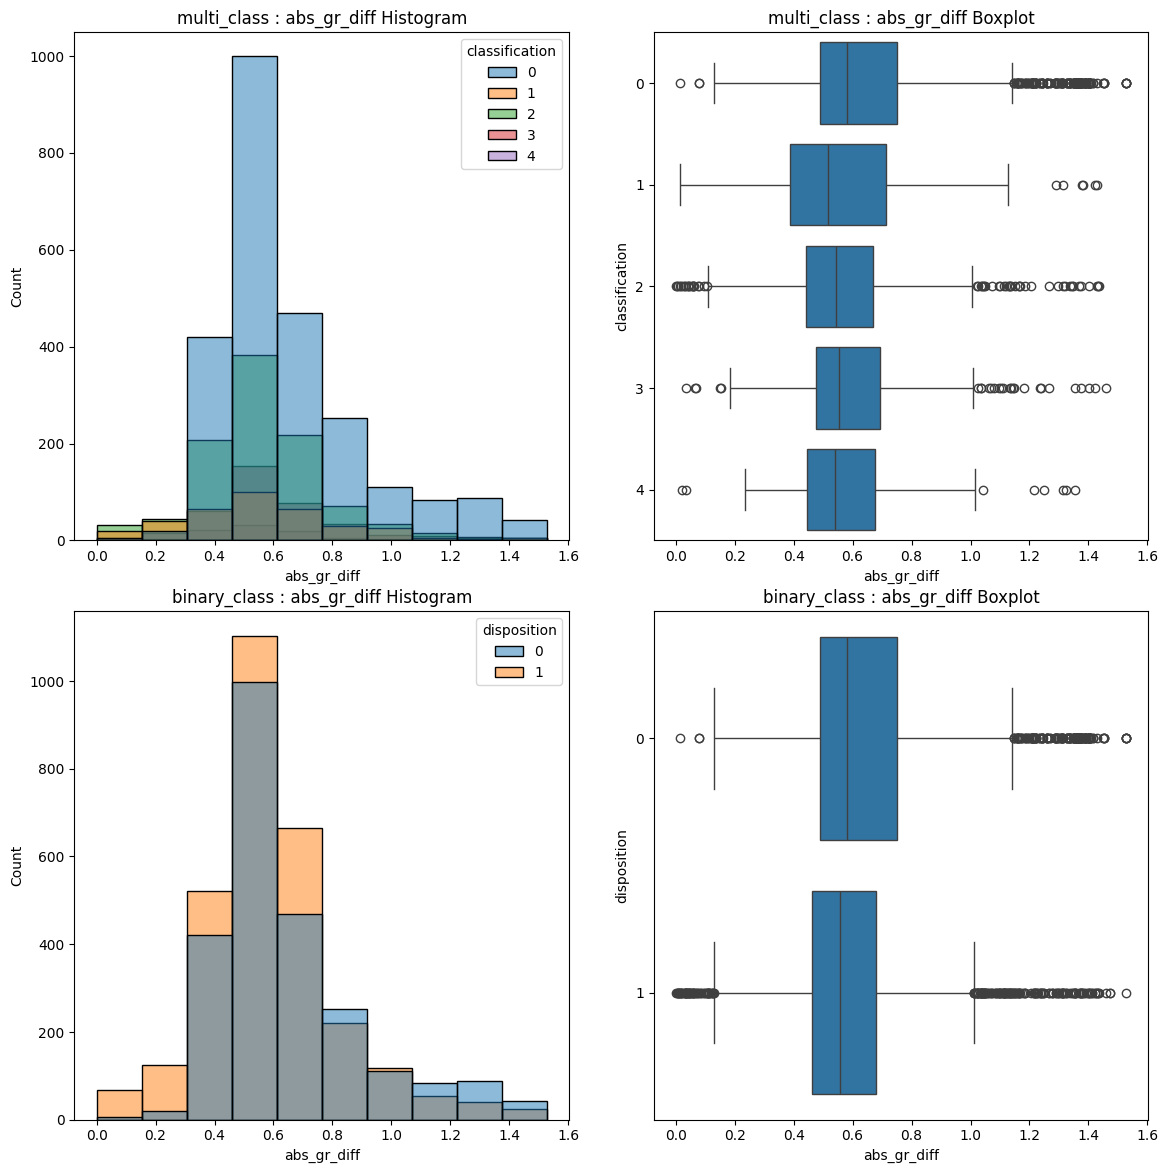

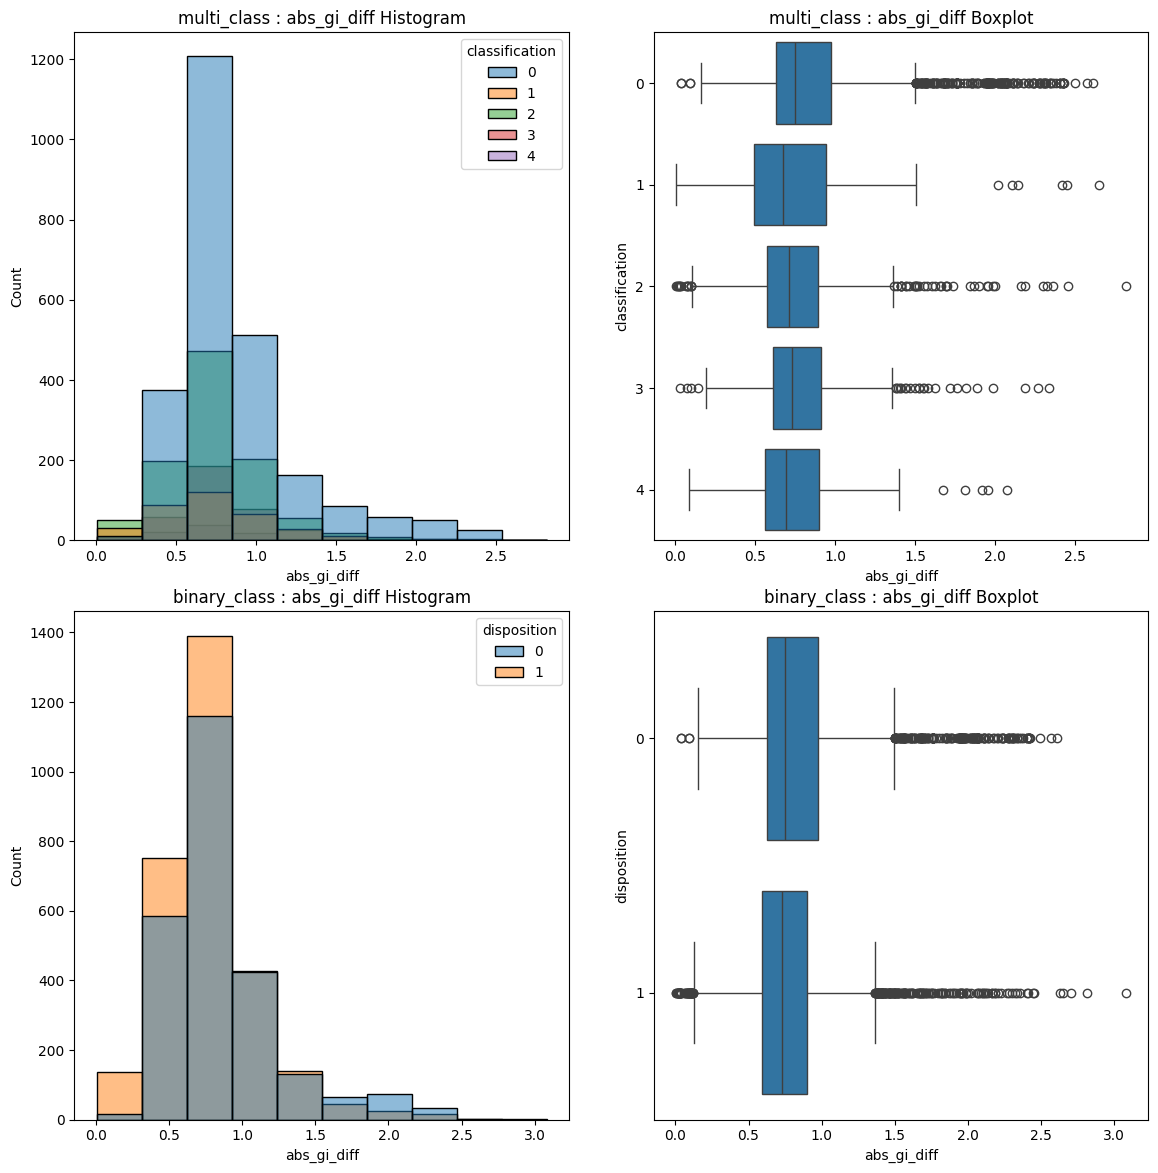

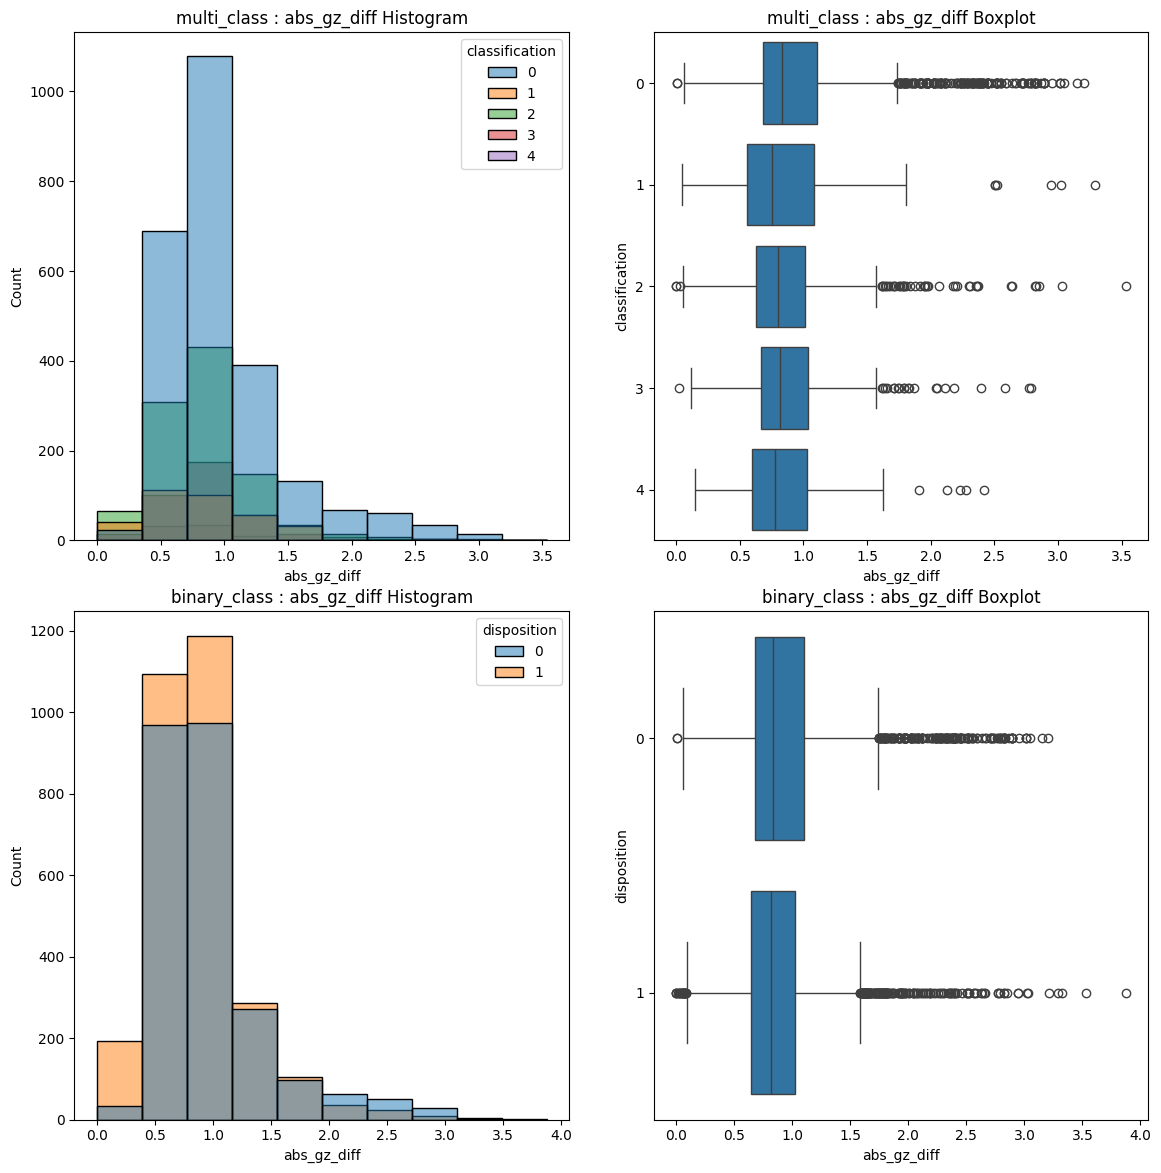

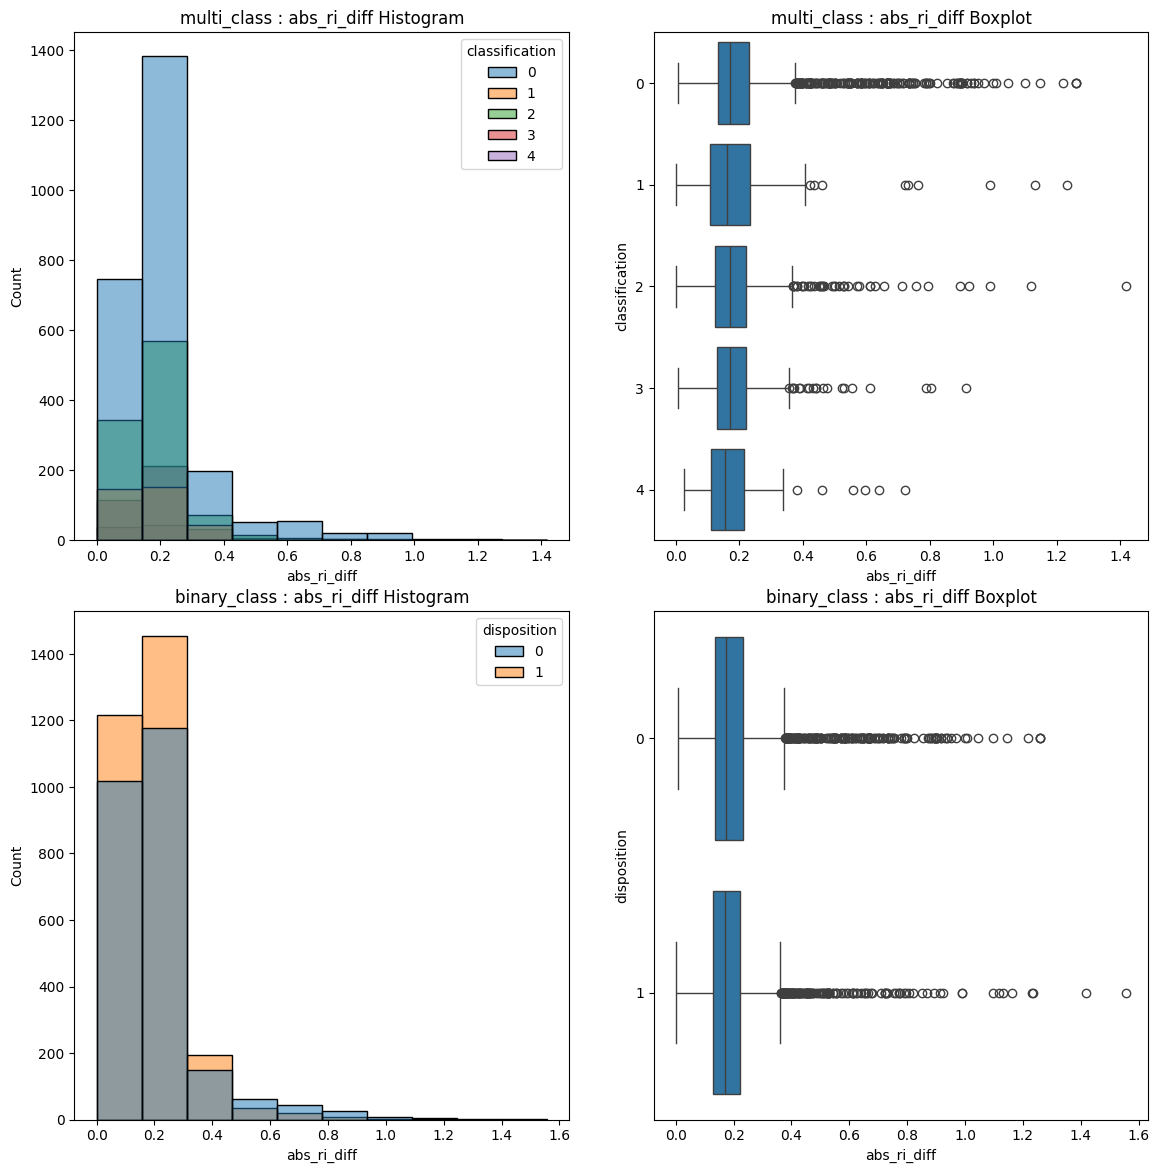

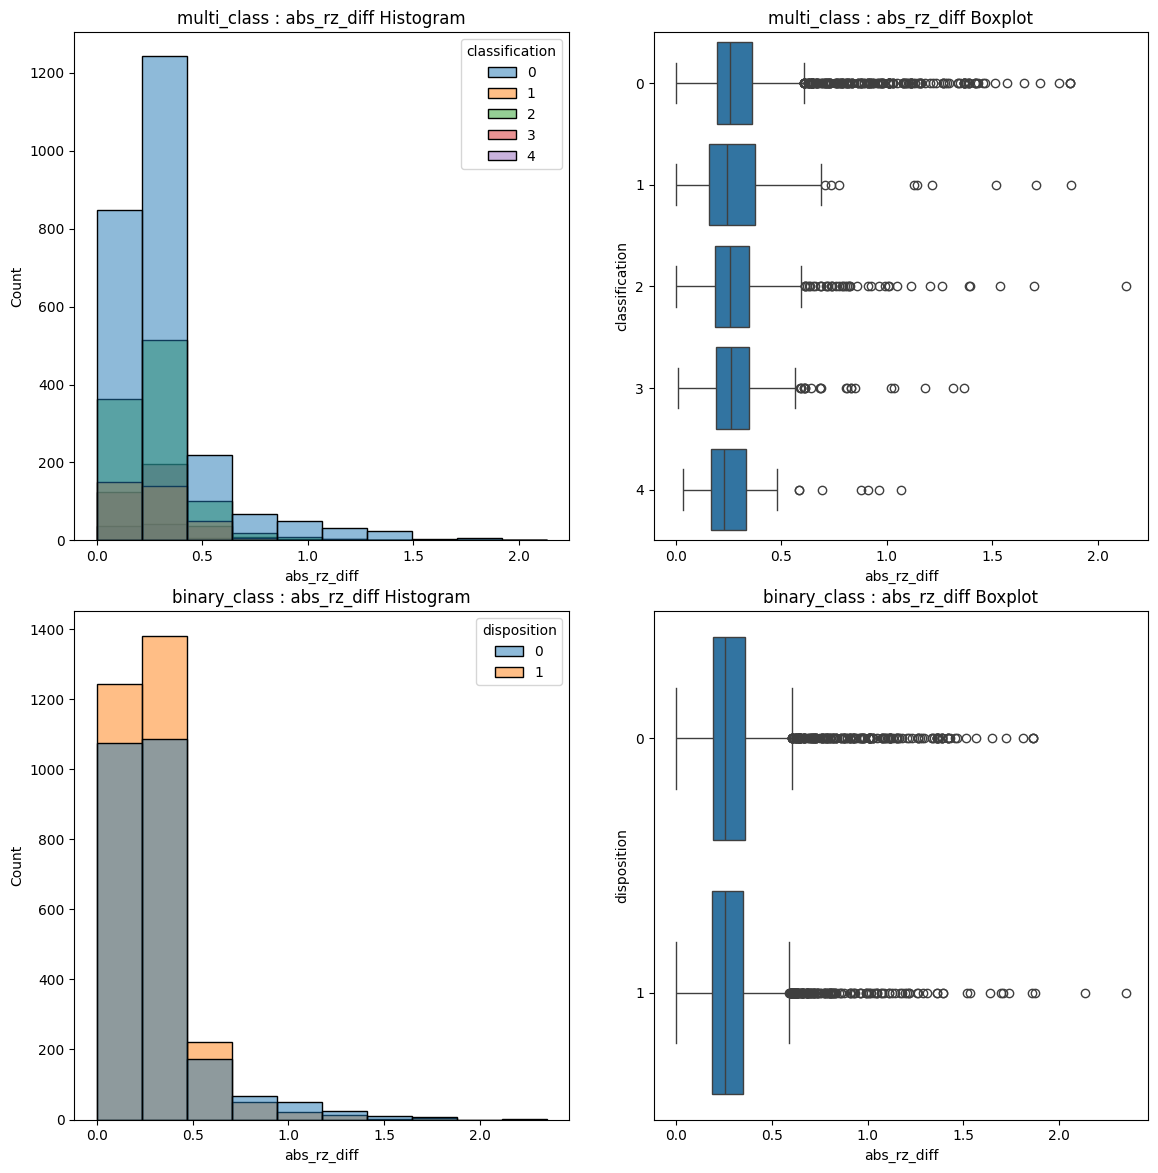

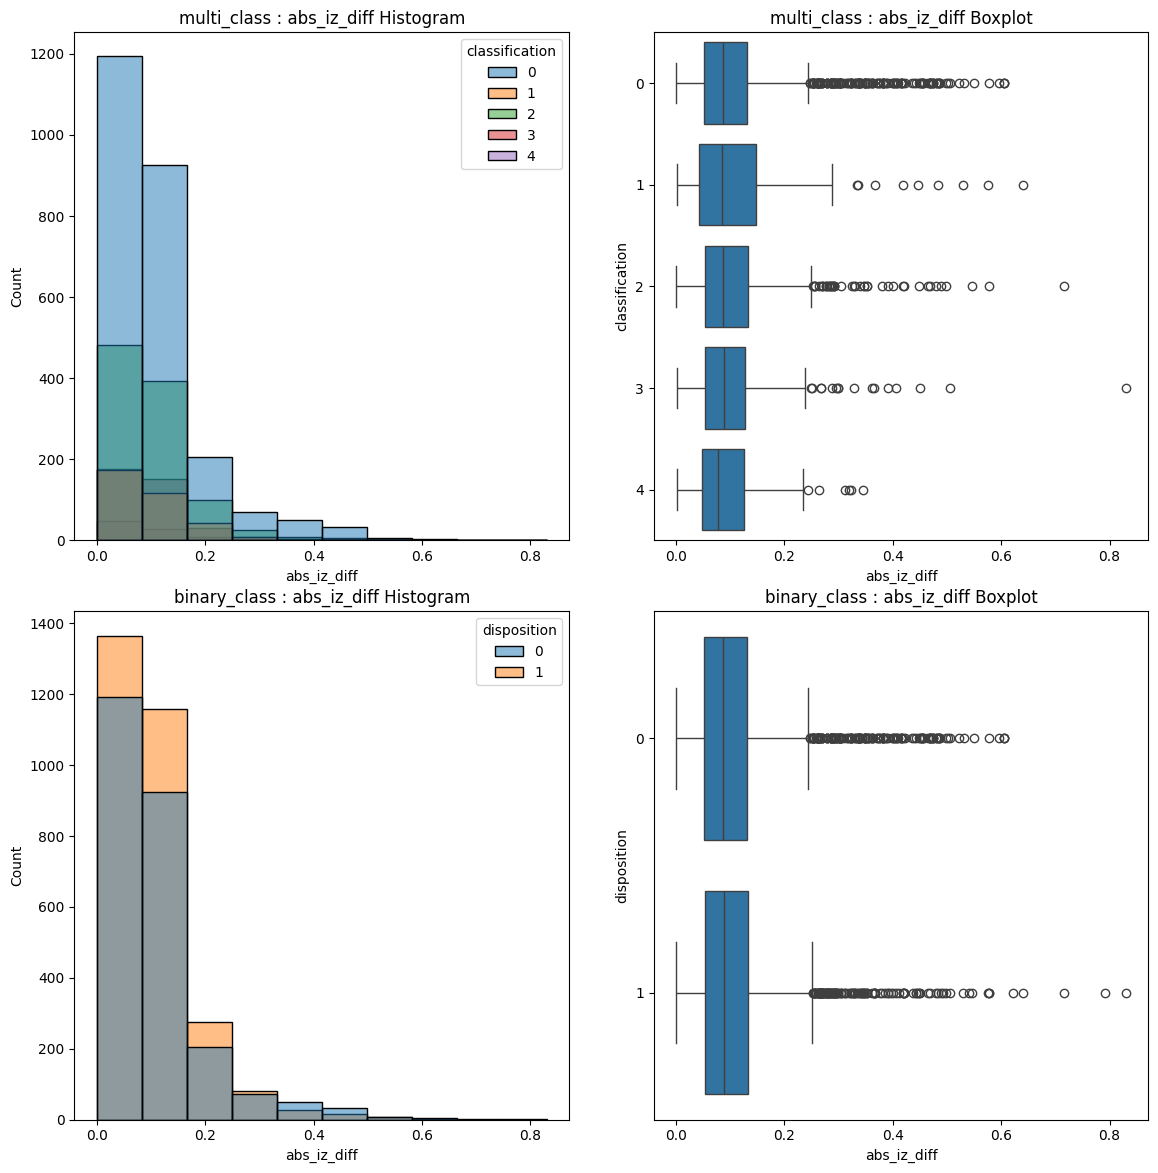

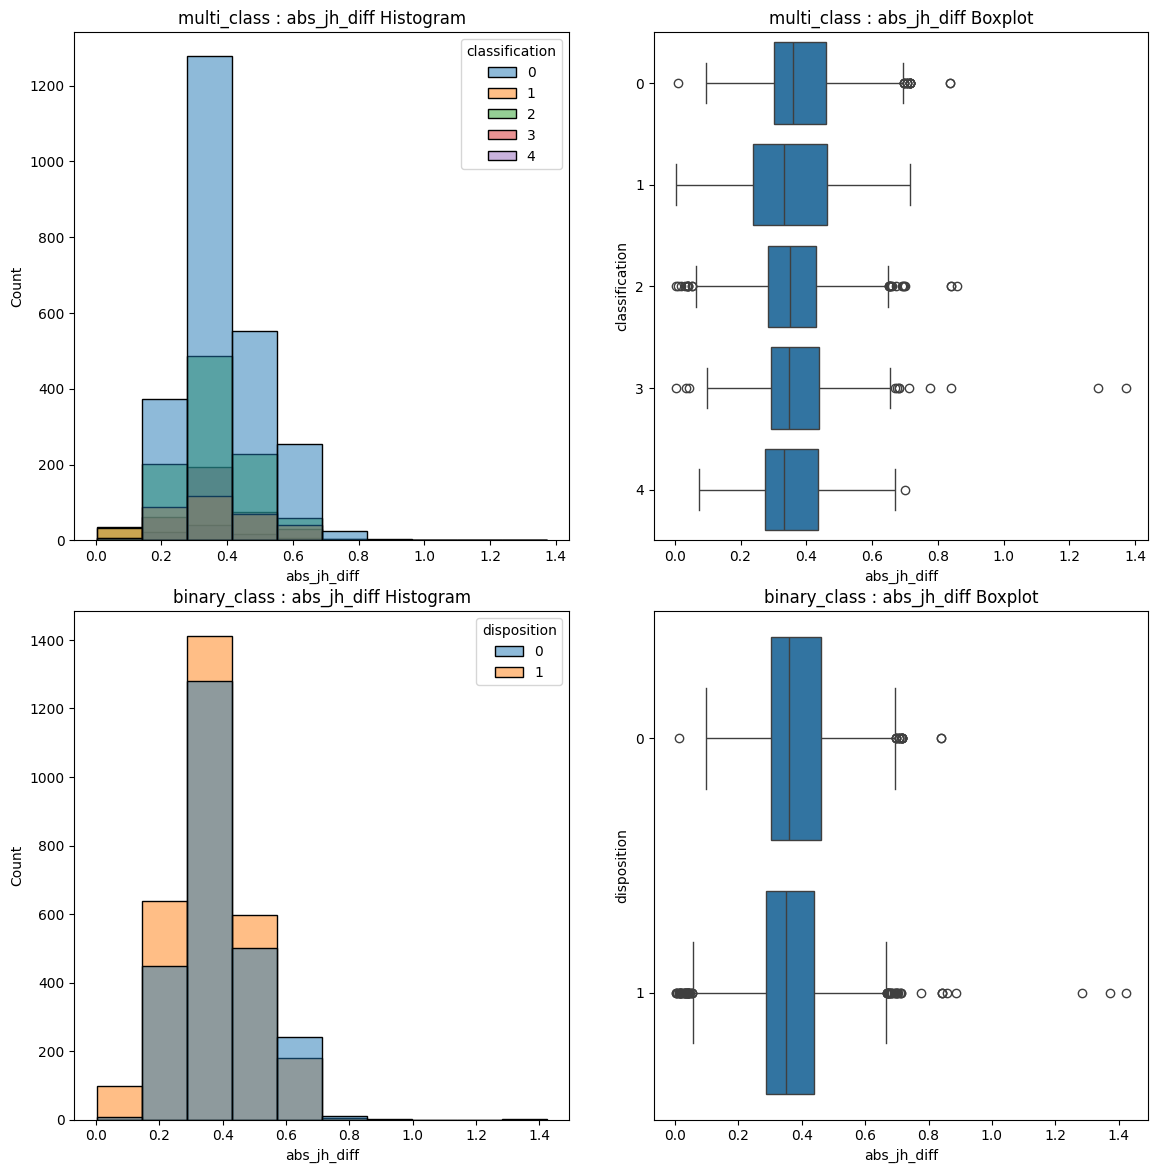

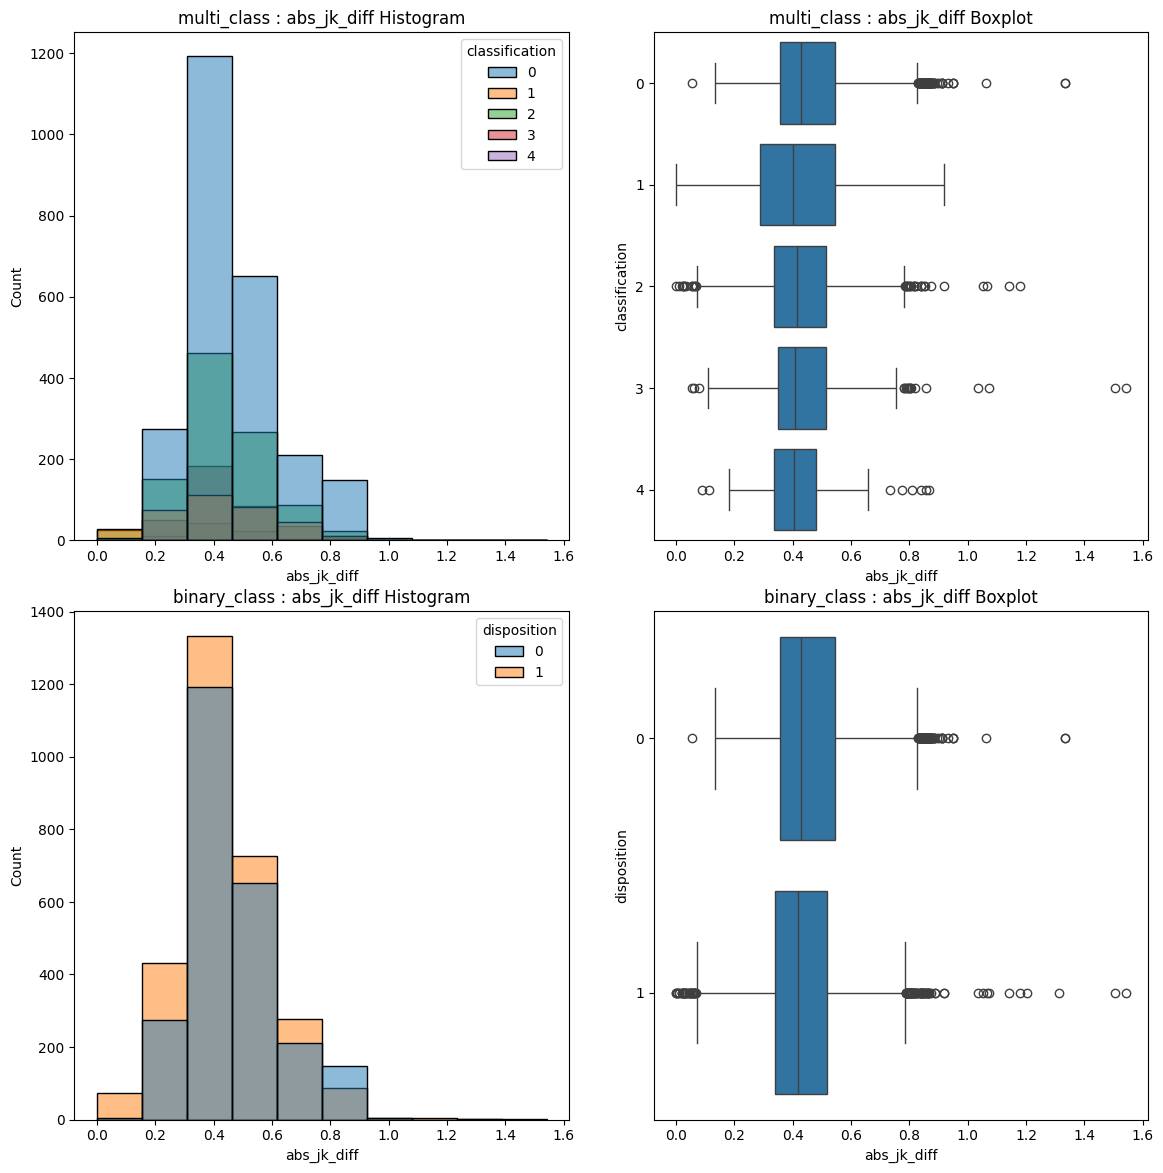

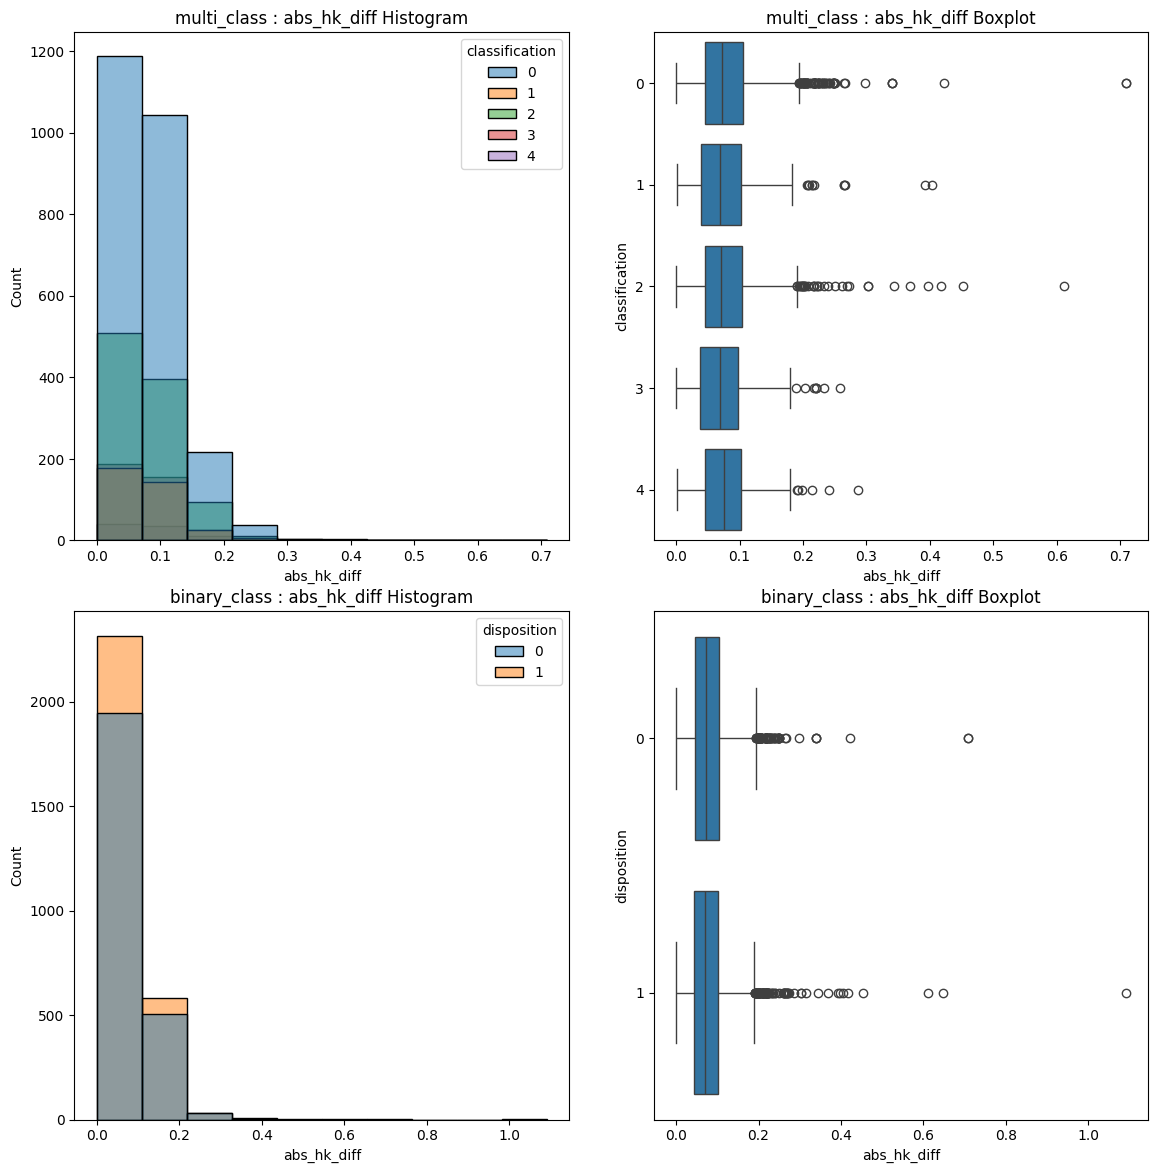

In [10]:
# There are 2 main light-band systems present in the data: griz and JHK
# For each of the systems, create columns using the pairwise combinations of each element
# Each column represents the absolute difference between the frequency bands
kic_mag = ['g_band_mag', 'r_band_mag', 'i_band_mag', 'z_band_mag']
twomass_mag = ['j_band_mag', 'h_band_mag', 'k_band_mag']

# Create griz difference columns
for pair in combinations(kic_mag, 2):
    multi_class['abs_{}{}_diff'.format(pair[0][0], pair[1][0])] = np.abs(multi_class[pair[0]]\
                                                                         - multi_class[pair[1]])
    binary_class['abs_{}{}_diff'.format(pair[0][0], pair[1][0])] = np.abs(binary_class[pair[0]]\
                                                                          - binary_class[pair[1]])

# Create JHK difference columns
for pair in combinations(twomass_mag, 2):
    multi_class['abs_{}{}_diff'.format(pair[0][0], pair[1][0])] = np.abs(multi_class[pair[0]]\
                                                                         - multi_class[pair[1]])
    binary_class['abs_{}{}_diff'.format(pair[0][0], pair[1][0])] = np.abs(binary_class[pair[0]]\
                                                                          - binary_class[pair[1]])

# Inspect histograms and boxplots of newly created columns
diff_col = [x for x in multi_class if 'abs' in x]

for column in diff_col:
    plot_distributions([multi_class, binary_class], column, ['classification', 'disposition'], kde = False, bins = 10)

# Train Test Split and Export Dataframes

In [11]:
# Train test split multi-class dataset, 80/20 split. Write to parquet files for further use.
X_multi = multi_class.drop('classification', axis = 1)
y_multi = multi_class.classification

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi,
                                                                            y_multi,
                                                                            test_size = 0.2,
                                                                            random_state = 42,
                                                                            stratify = y_multi)

train_multi_full = pd.concat([X_train_multi, y_train_multi], axis = 1)
test_multi_full = pd.concat([X_test_multi, y_test_multi], axis = 1)

train_multi_full.to_csv('train_multi.csv')
test_multi_full.to_csv('test_multi.csv')

In [12]:
# Train test split binary class dataset, 80/20 split. Write to parquet files for further use.
X_binary = binary_class.drop('disposition', axis = 1)
y_binary = binary_class.disposition

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary,
                                                                                y_binary,
                                                                                test_size = 0.2,
                                                                                random_state = 42,
                                                                                stratify = y_binary)

train_binary_full = pd.concat([X_train_binary, y_train_binary], axis = 1)
test_binary_full = pd.concat([X_test_binary, y_test_binary], axis = 1)

train_binary_full.to_csv('train_binary.csv')
test_binary_full.to_csv('test_binary.csv')